<h1 style="font-size: 2.5em;">Deep Learning for CIFAR-10 Images Dataset: Optimising Basic and Advanced CNN Architectures for Image Classification</h1>

- [GitHub Repository -- (Gammaploid) ](https://github.com/gammaploid/NN_CFAIR10)
- [CIFAR-10 Convolutional Neural Network (M2,M3,M3o) on Kaggle](https://www.kaggle.com/models/hassanalmosa/convolutional-neural-networks-cifar-10-m2m3m3o)


In [64]:
!pip install torchinfo
!pip install tensorboard
!pip install torchviz
!pip install torchsummary

import random
import numpy as np
from PIL import Image

import torch, torchvision
import torch.optim as optim
import torch.nn as nn
from torchvision import transforms

from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler, SubsetRandomSampler
from torchvision.transforms import Compose, ToTensor, Normalize, ToPILImage, RandomHorizontalFlip, Resize

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from torchvision.transforms import v2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from torchinfo import summary
from torchviz import make_dot

from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import CyclicLR

In [123]:
%run -i handy_code/ModelBuilder.py
%run -i handy_code/weighted_sampler.py
%run -i handy_code/additional_functions.py
%run -i handy_code/res_net34.py

<Figure size 640x480 with 0 Axes>

# 1. Loading Dataset and Exploration 

## 1.1 Data Exploration

In [71]:
torch.manual_seed(42)

# download CIFAR 10 dataset 
train_full = torchvision.datasets.CIFAR10(root='./',
                                         train=True,
                                         download=True)

test_full = torchvision.datasets.CIFAR10(root='./',
                                        train=False,
                                        download=True)

print(f"Training set size: {len(train_full)}")
print(f"Test set size: {len(test_full)}")

Files already downloaded and verified
Files already downloaded and verified
Training set size: 50000
Test set size: 10000


Image type: <class 'PIL.Image.Image'>
Label: 6


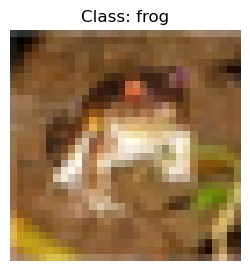

Image type: <class 'PIL.Image.Image'>
Label: 9


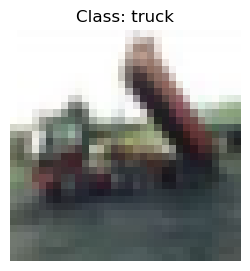

Image type: <class 'PIL.Image.Image'>
Label: 8


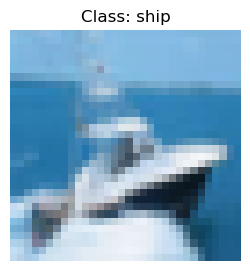

Image type: <class 'PIL.Image.Image'>
Label: 3


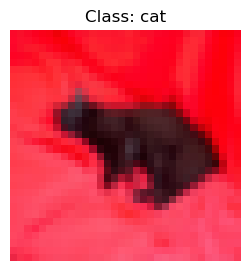

Image type: <class 'PIL.Image.Image'>
Label: 8


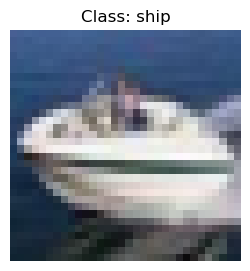

Image type: <class 'PIL.Image.Image'>
Label: 1


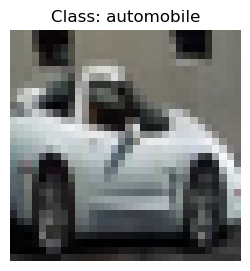

Image type: <class 'PIL.Image.Image'>
Label: 4


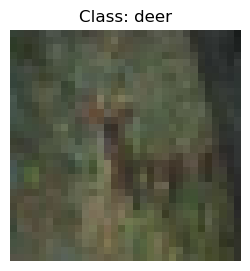

In [72]:
# get a single image ( random picks ) to verify current label mapping
image, label = train_full[0]
print(f"Image type: {type(image)}")
print(f"Label: {label}")

# display the image
plt.figure(figsize=(3,3))
plt.imshow(image)
plt.title(f'Class: {train_full.classes[label]}')
plt.axis('off')
plt.show()


image, label = train_full[2]
print(f"Image type: {type(image)}")
print(f"Label: {label}")

plt.figure(figsize=(3,3))
plt.imshow(image)
plt.title(f'Class: {train_full.classes[label]}')
plt.axis('off')
plt.show()

image, label = train_full[8]
print(f"Image type: {type(image)}")
print(f"Label: {label}")

plt.figure(figsize=(3,3))
plt.imshow(image)
plt.title(f'Class: {train_full.classes[label]}')
plt.axis('off')
plt.show()


image, label = train_full[21]
print(f"Image type: {type(image)}")
print(f"Label: {label}")

plt.figure(figsize=(3,3))
plt.imshow(image)
plt.title(f'Class: {train_full.classes[label]}')
plt.axis('off')
plt.show()


image, label = train_full[222]
print(f"Image type: {type(image)}")
print(f"Label: {label}")


plt.figure(figsize=(3,3))
plt.imshow(image)
plt.title(f'Class: {train_full.classes[label]}')
plt.axis('off')
plt.show()

image, label = train_full[312]
print(f"Image type: {type(image)}")
print(f"Label: {label}")

plt.figure(figsize=(3,3))
plt.imshow(image)
plt.title(f'Class: {train_full.classes[label]}')
plt.axis('off')
plt.show()


image, label = train_full[10]
print(f"Image type: {type(image)}")
print(f"Label: {label}")


plt.figure(figsize=(3,3))
plt.imshow(image)
plt.title(f'Class: {train_full.classes[label]}')
plt.axis('off')
plt.show()

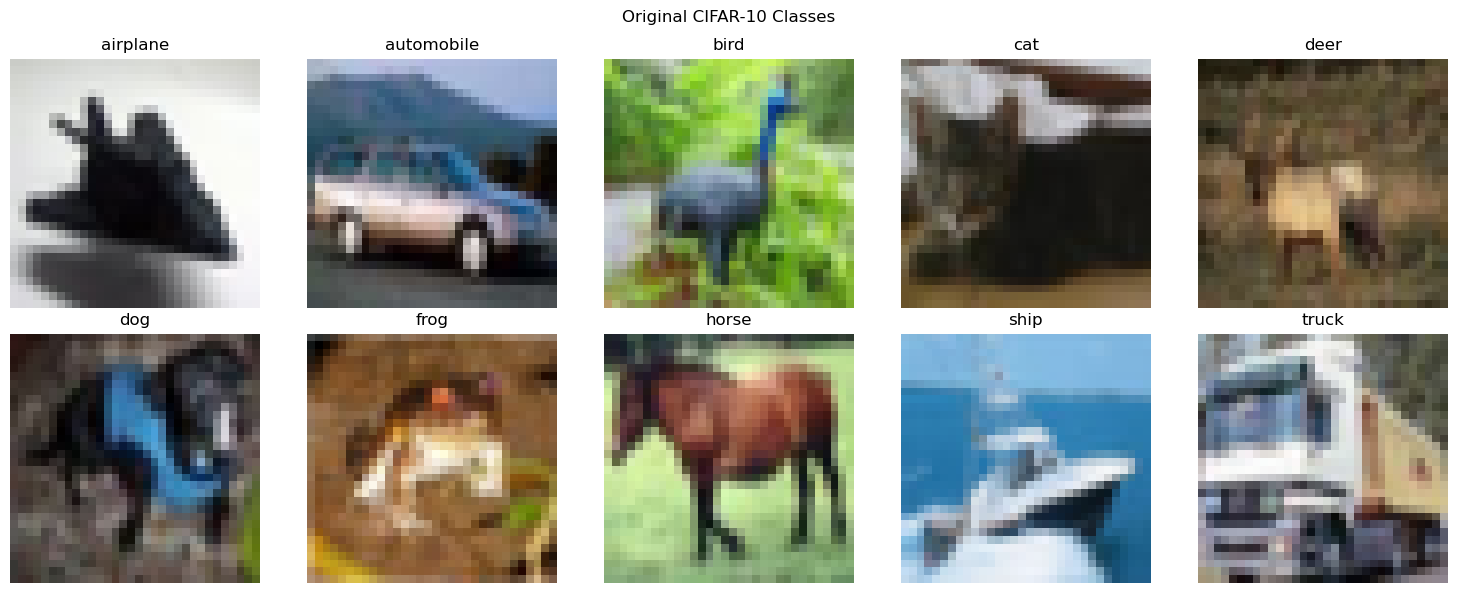

In [73]:
# Original CIFAR 10 classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']


fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for idx, class_idx in enumerate(range(10)):
    #find and display first bunch of images in the training set
    for i in range(len(train_full)):
        if train_full.targets[i] == class_idx:
            img, label = train_full[i]
            axes[idx].imshow(img)
            axes[idx].set_title(classes[label])
            axes[idx].axis('off')
            break

plt.suptitle('Original CIFAR-10 Classes')
plt.tight_layout()
plt.show()

In [74]:
# create a tensor of input images by stacking tensors converted from the training dataset
x_tensor = torch.stack([transforms.ToTensor()(data[0]) for data in train_full])
y_tensor = torch.tensor(train_full.targets)

## 1.2 Class Remaping (Version 2)


Unique labels after mapping: tensor([0, 1, 2, 3, 4, 5])

Mapping verification:
Original class 0 (airplane) -> New class 5
Original class 1 (automobile) -> New class 0
Original class 2 (bird) -> New class 3
Original class 3 (cat) -> New class 4
Original class 4 (deer) -> New class 3
Original class 5 (dog) -> New class 2
Original class 6 (frog) -> New class 1
Original class 7 (horse) -> New class 3
Original class 8 (ship) -> New class 5
Original class 9 (truck) -> New class 0


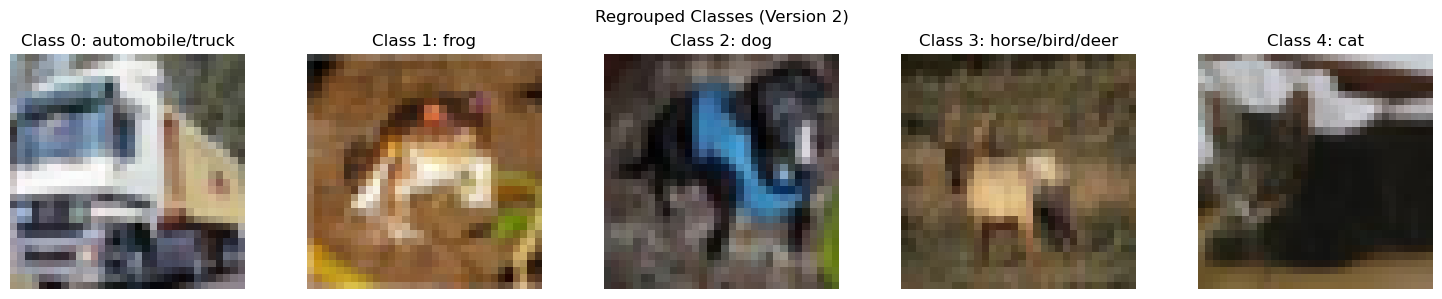

In [75]:
#
# SRN ends with 14 --> 14÷3 = 4 remainder is 2, thus Version 2 mapping used
#

# version 2 remapping, 5 classes, and for the rest of unmapped classes we will label them as "other" class
targets = torch.tensor(train_full.targets)
y_tensor_new = torch.full_like(y_tensor, 5)  # initialise all with 5 

# Mapping for Version 2
y_tensor_new[(y_tensor == 1) | (y_tensor == 9)] = 0  # automobile, truck -> 0
y_tensor_new[y_tensor == 6] = 1  # frog -> 1
y_tensor_new[y_tensor == 5] = 2  # dog -> 2
y_tensor_new[(y_tensor == 7) | (y_tensor == 2) | (y_tensor == 4)] = 3 # horse, bird, deer -> 3
y_tensor_new[y_tensor == 3] = 4  # cat -> 4
# airplane(0) and ship(8) -> becomes 5  (other)

print("\nUnique labels after mapping:", torch.unique(y_tensor_new))
print("\nMapping verification:")
for old_label in range(10):
    new_label = y_tensor_new[y_tensor == old_label][0].item()
    print(f"Original class {old_label} ({classes[old_label]}) -> New class {new_label}")

# new class names for Version 2 + "other" class
new_classes = ["automobile/truck", "frog", "dog", "horse/bird/deer", "cat"]

# display example images for each new class
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
axes = axes.ravel()

for idx, class_idx in enumerate(range(5)):  
    for i in range(len(train_full)):
        if y_tensor_new[i] == class_idx:
            img, _ = train_full[i]
            axes[idx].imshow(img)
            axes[idx].set_title(f"Class {class_idx}: {new_classes[class_idx]}")
            axes[idx].axis("off")
            break

plt.suptitle("Regrouped Classes (Version 2)")
plt.tight_layout()
plt.show()

## 1.3 Transform, Loading Dataset, and Class Balancing


Checking class distribution in splits before weight sampling:
count of label 0.0 = 2986.00
freq of label 0.0 = 19.91
count of label 1.0 = 1556.00
freq of label 1.0 = 10.37
count of label 2.0 = 1426.00
freq of label 2.0 = 9.51
count of label 3.0 = 4488.00
freq of label 3.0 = 29.92
count of label 4.0 = 1508.00
freq of label 4.0 = 10.05
-------------------------------------------------


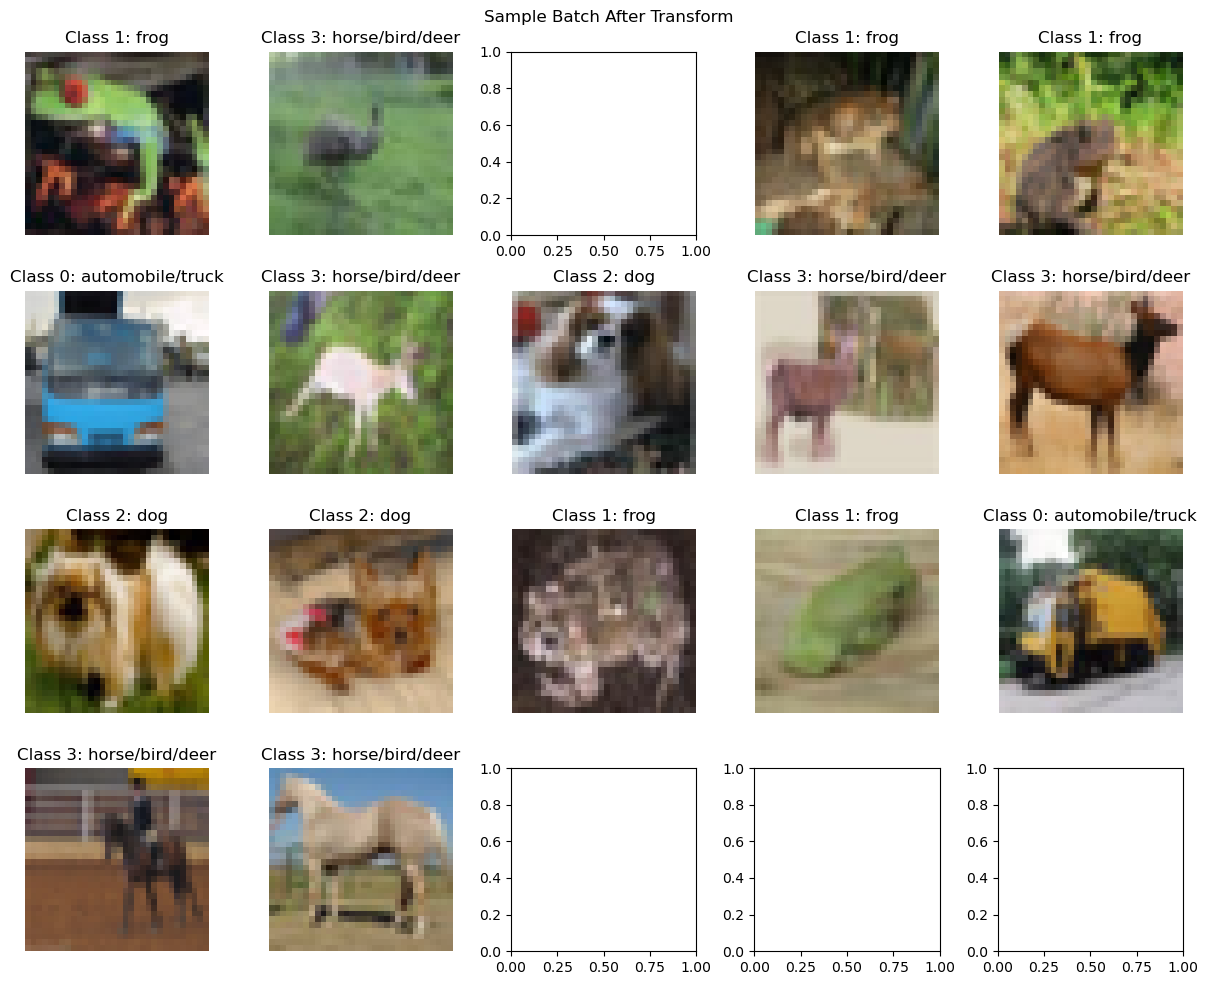

In [76]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# defining transform hyper-parameters
transform = transforms.Compose([])


# create the transformed dataset
dataset = TransformedTensorDataset(
    x_tensor,
    y_tensor_new,
    transform=transform
)

# spliting into train-validation-test sets
train_size, val_size, test_size = 15000, 5000, 5000
train_set, val_set, test_set, _ = torch.utils.data.random_split(
    dataset,[
        train_size,
        val_size,
        test_size,
        len(dataset) - (train_size + val_size + test_size)], # _ for the rest of dataset
)

# BATCH SIZE 

batch_size = 64

#
#CLASS BALANCING
# 

# class distribution check in each set before applying weight sampler  

print("\nChecking class distribution in splits before weight sampling:")

train_loader = DataLoader(train_set, batch_size=batch_size, sampler=None)
val_loader = DataLoader(val_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)


count_freq_in_batch(train_loader_, range(5), len(train_set))  

print("-------------------------------------------------")


# check a single batch
it = iter(train_loader)
images, labels = next(it)

# plots the first 20 images from the batch
fig, axes = plt.subplots(4, 5, figsize=(12, 10))
axes = axes.ravel()

for idx in range(min(20, len(images))):
    img = images[idx]
    label = labels[idx].item()
    if label < len(new_classes):  
        axes[idx].imshow(img.permute(1, 2, 0))
        axes[idx].axis("off")
        axes[idx].set_title(f"Class {label}: {new_classes[label]}")

plt.suptitle("Sample Batch After Transform")
plt.tight_layout()
plt.show()

In [77]:
# sanity check
print(x_tensor.shape)
print(y_tensor.shape)
classes, counts = y_tensor_new.unique(return_counts=True)
print(classes, counts)
classes, counts = y_tensor.unique(return_counts=True)
print(classes, counts)

torch.Size([50000, 3, 32, 32])
torch.Size([50000])
tensor([0, 1, 2, 3, 4, 5]) tensor([10000,  5000,  5000, 15000,  5000, 10000])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]) tensor([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000])


In [78]:
# sanity check
it = iter(train_loader)
item = next(it)
item

[tensor([[[[0.2392, 0.2784, 0.3059,  ..., 0.3059, 0.2784, 0.2275],
           [0.4471, 0.4275, 0.3647,  ..., 0.3216, 0.2784, 0.2353],
           [0.3137, 0.2588, 0.1922,  ..., 0.3686, 0.3608, 0.3176],
           ...,
           [0.0157, 0.0235, 0.0000,  ..., 0.4431, 0.4078, 0.4431],
           [0.0314, 0.0549, 0.0235,  ..., 0.4627, 0.3804, 0.3529],
           [0.1490, 0.1490, 0.1137,  ..., 0.3765, 0.3294, 0.3569]],
 
          [[0.2235, 0.2431, 0.2745,  ..., 0.2549, 0.2275, 0.1843],
           [0.4275, 0.3922, 0.3412,  ..., 0.2863, 0.2392, 0.2000],
           [0.2980, 0.2353, 0.1922,  ..., 0.3451, 0.3255, 0.2824],
           ...,
           [0.0706, 0.0510, 0.0706,  ..., 0.2980, 0.2196, 0.1922],
           [0.0471, 0.0588, 0.0510,  ..., 0.3020, 0.2314, 0.1765],
           [0.1137, 0.0980, 0.0706,  ..., 0.2000, 0.1647, 0.1922]],
 
          [[0.2196, 0.2353, 0.2588,  ..., 0.2000, 0.1882, 0.1490],
           [0.4392, 0.4118, 0.3412,  ..., 0.2235, 0.1961, 0.1686],
           [0.2745, 0.21

# 2. (M2) Model

## 2.1  (M2) - Sequential CNN (2 Convolution Blocks) Model

Epoch 1/210
Epoch 1, Training loss: 1.5529, accuracy: 0.4287, Validation loss: 1.4212, accuracy: 0.4980
Epoch 2/210
Epoch 1, Training loss: 1.3151, accuracy: 0.5268, Validation loss: 1.2796, accuracy: 0.5309
Epoch 3/210
Epoch 1, Training loss: 1.2112, accuracy: 0.5561, Validation loss: 1.2040, accuracy: 0.5599
Epoch 4/210
Epoch 1, Training loss: 1.1474, accuracy: 0.5757, Validation loss: 1.1519, accuracy: 0.5736
Epoch 5/210
Epoch 1, Training loss: 1.0997, accuracy: 0.5944, Validation loss: 1.1117, accuracy: 0.5920
Epoch 6/210
Epoch 1, Training loss: 1.0616, accuracy: 0.6080, Validation loss: 1.0805, accuracy: 0.6036
Epoch 7/210
Epoch 1, Training loss: 1.0310, accuracy: 0.6175, Validation loss: 1.0552, accuracy: 0.6141
Epoch 8/210
Epoch 1, Training loss: 1.0050, accuracy: 0.6273, Validation loss: 1.0337, accuracy: 0.6220
Epoch 9/210
Epoch 1, Training loss: 0.9823, accuracy: 0.6375, Validation loss: 1.0154, accuracy: 0.6297
Epoch 10/210
Epoch 1, Training loss: 0.9622, accuracy: 0.6456, V

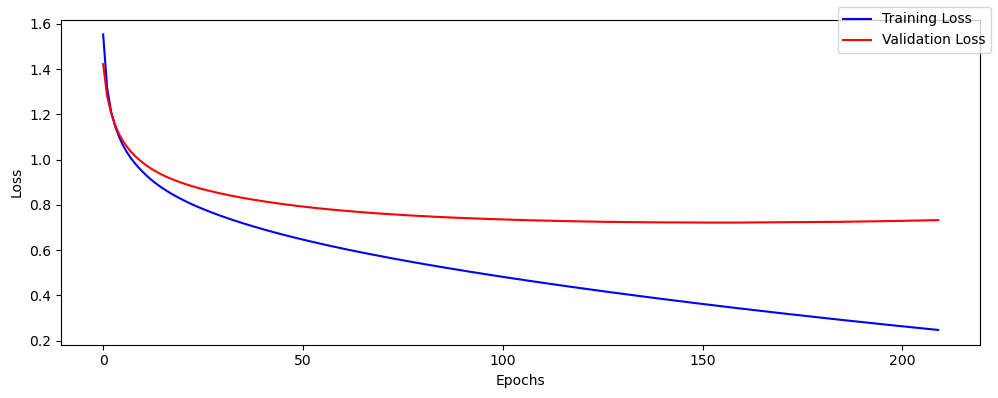

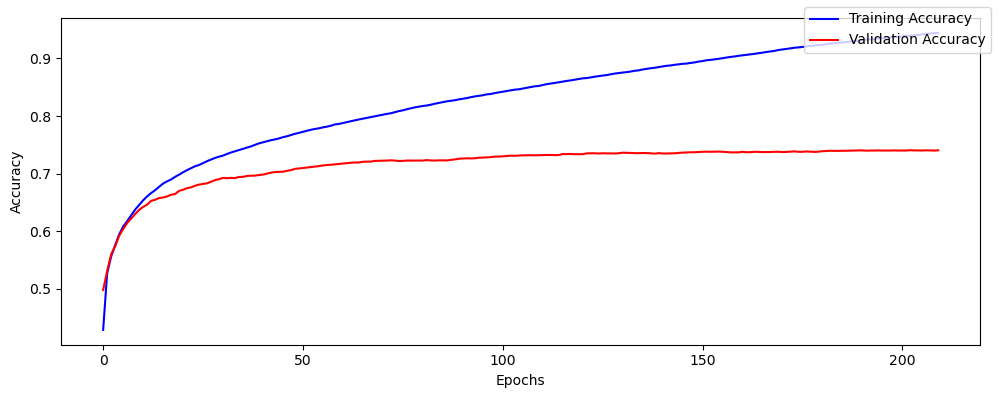

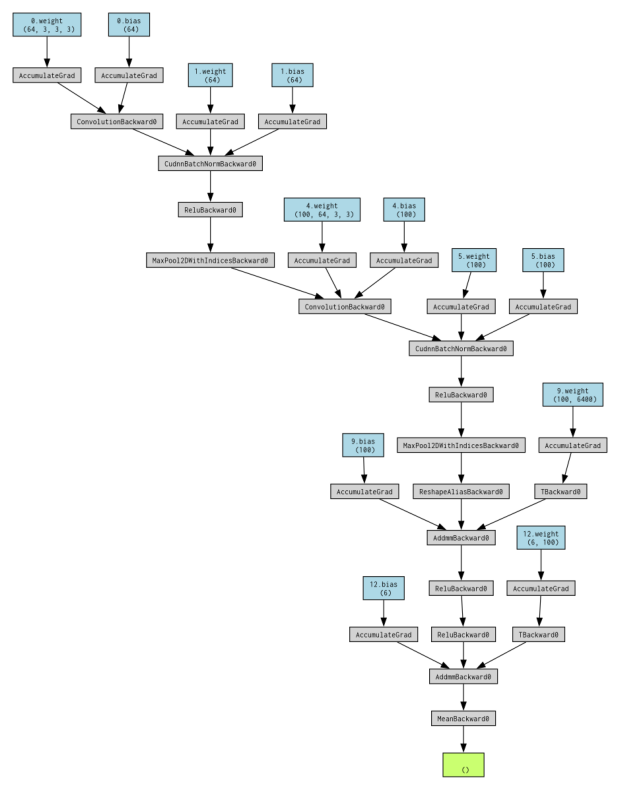

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 6]                    --
├─Conv2d: 1-1                            [1, 64, 32, 32]           1,792
├─BatchNorm2d: 1-2                       [1, 64, 32, 32]           128
├─ReLU: 1-3                              [1, 64, 32, 32]           --
├─MaxPool2d: 1-4                         [1, 64, 16, 16]           --
├─Conv2d: 1-5                            [1, 100, 16, 16]          57,700
├─BatchNorm2d: 1-6                       [1, 100, 16, 16]          200
├─ReLU: 1-7                              [1, 100, 16, 16]          --
├─MaxPool2d: 1-8                         [1, 100, 8, 8]            --
├─Flatten: 1-9                           [1, 6400]                 --
├─Linear: 1-10                           [1, 100]                  640,100
├─ReLU: 1-11                             [1, 100]                  --
├─ReLU: 1-12                             [1, 100]                  --
├

In [54]:
# M2 nn sequential model with 2 convloution blocks
m2_12 =  nn.Sequential(
    # 1st conv block 
    nn.Conv2d(3, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(), 
    nn.MaxPool2d(2, 2),
    
    # 2nd conv block 
    nn.Conv2d(64, 100, kernel_size=3, padding=1),
    nn.BatchNorm2d(100), 
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    nn.Flatten(),
    
    # fc 
    nn.Linear(100 * 8 * 8, 100),
    nn.ReLU(),
    nn.ReLU(), 
    nn.Linear(100, 6)
)

#Cross-entropy loss
loss = nn.CrossEntropyLoss()

# AdamW Optimiser
optimizer = optim.AdamW(
    m2_12.parameters(),
    lr=0.0000003, 
    weight_decay=0.2 
)

#  onecycleLR scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.0001,
    epochs=200,
    steps_per_epoch=len(train_loader),
    pct_start=0.3
)

# train the model
model_buildero = ModelBuilder(m2_12, loss, optimizer, print_loss_freq=1)
model_buildero.set_loaders(train_loader, val_loader)

# training loop including scheduler
for epoch in range(210):
    print(f"Epoch {epoch + 1}/{210}")
    model_buildero.train(n_epochs=1)
    scheduler.step()  # sheduler steps @ each eopch

# plot results
model_buildero.plot_losses()
model_buildero.plot_accuracies()
plt.show()


#sample input/output for summary()
sample_input = torch.randn(2, 3, 32, 32).to(device) 
output = m2_12(sample_input)

# render and plot the model archietichure using make_dot() and summary 
make_dot(output.mean(), params=dict(m2_12.named_parameters())).render("images/m2_12", format="png")
img = Image.open("images/m2_12.png")
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")
plt.show()

print(summary(m2_12, input_size=(1, 3, 32, 32)))

## 2.2 (M2) Model Evaluation

First validation image shape:   torch.Size([1, 3, 32, 32])
First 10 validation labels:   tensor([3, 1, 5, 3, 1, 4, 2, 0, 0, 3])
predictions shape:  (5000, 6)
Unique classes in true labels: tensor([0, 1, 2, 3, 4, 5])
Unique classes in predictions: tensor([0, 1, 2, 3, 4, 5])

First 10 predicted labels : tensor([3, 1, 5, 3, 1, 4, 3, 0, 1, 3])


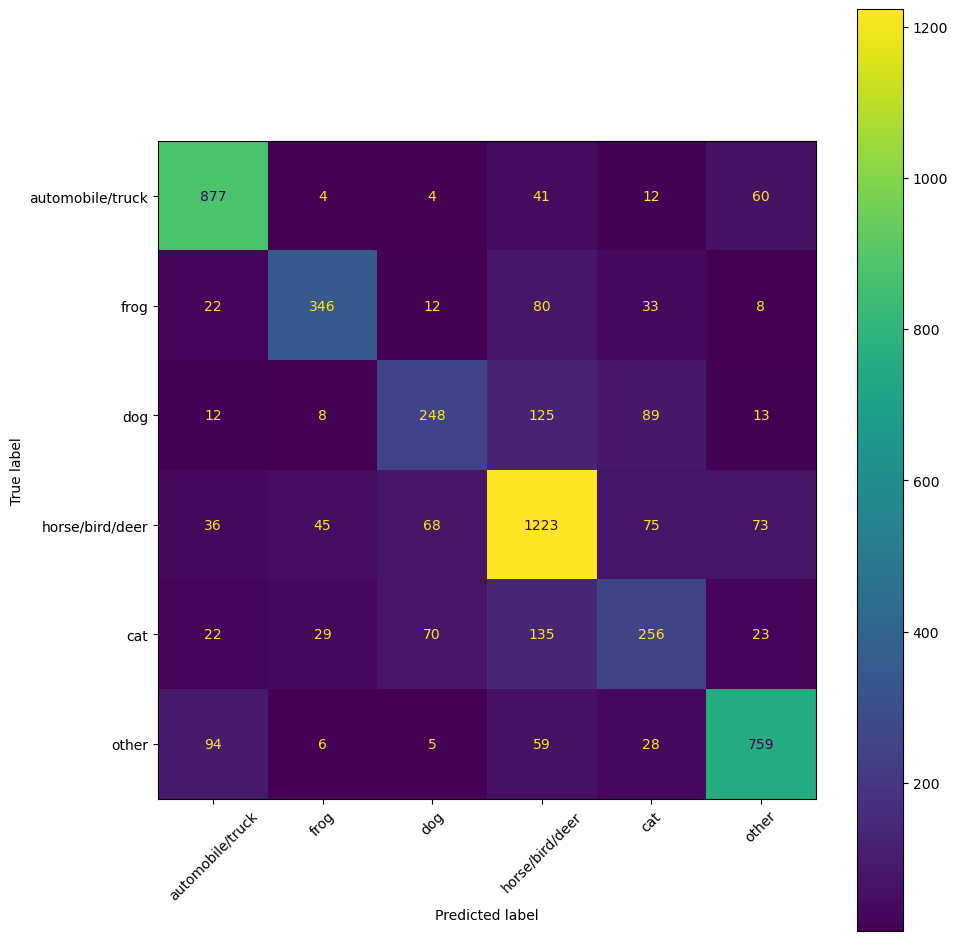

Validation Accuracy: 74.18%


In [58]:
# retrieve features (images here) and labels
x_val = [torch.as_tensor(t[0]).unsqueeze(0) for t in list(val_set)]
y_val = torch.tensor([t[1] for t in list(val_set)])  # Convert to tensor directly

# sanity check
print("First validation image shape:  ", x_val[0].shape)
print("First 10 validation labels:  ", y_val[:10])

# apply the model to each image and reshape prediction tensor
val_predictions = np.array([model_buildero.predict(i) for i in x_val])
val_predictions = val_predictions.squeeze()  
print("predictions shape: ", val_predictions.shape)

# convert to torch tensor so that Softmax can be applied
val_predictions = torch.from_numpy(val_predictions)

# convert predictions to probabilities
val_probab = nn.Softmax(dim=1)(val_predictions)


print("Unique classes in true labels:", torch.unique(y_val))
print("Unique classes in predictions:", torch.unique(val_pred))

# finally, get predicted class labels
val_pred = torch.argmax(val_probab, dim=1)
print("\nFirst 10 predicted labels :", val_pred[:10])


# remapped class names + class for anything else "other"
new_classes = ["automobile/truck", "frog", "dog", "horse/bird/deer", "cat", "other"]

#Confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(
    y_val.cpu().numpy(),
    val_pred.cpu().numpy(),
    display_labels=new_classes,
    ax=ax,
    xticks_rotation=45
)
plt.grid(False)
plt.tight_layout() 
plt.show()

#validation accuracy
val_correct = (val_pred == y_val).float()
val_accuracy = val_correct.mean()
print(f'Validation Accuracy: {val_accuracy*100:.2f}%')

Predictions shape: (5000, 6)

Unique classes in true labels: tensor([0, 1, 2, 3, 4, 5])
Unique classes in predictions: tensor([0, 1, 2, 3, 4, 5])

Sample of predictions: tensor([3, 0, 3, 5, 3, 1, 0, 3, 5, 2, 4, 5, 3, 0, 3, 0, 3, 3, 0, 0])
Sample of true labels: tensor([5, 0, 3, 5, 2, 3, 0, 3, 5, 2, 4, 5, 4, 0, 1, 0, 3, 3, 0, 0])


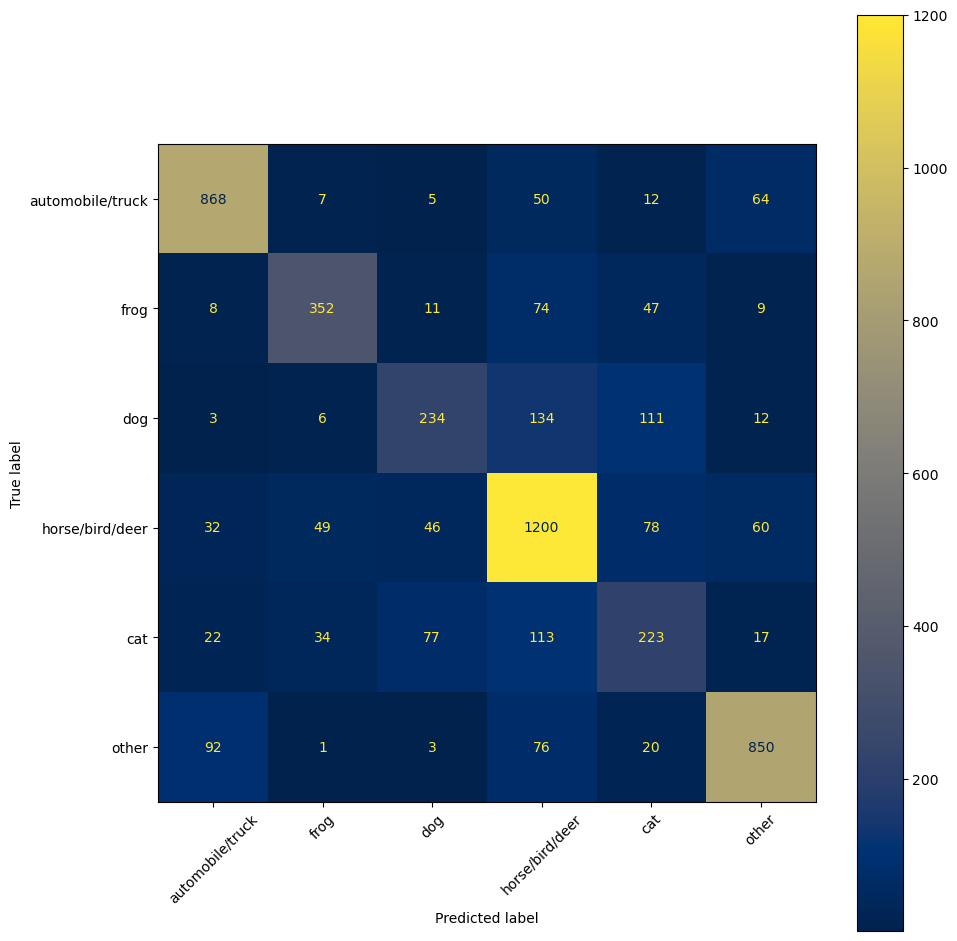


Overall Test Accuracy: 74.54%


In [62]:
# retrieve features (images here) and labels
x_test = [torch.as_tensor(t[0]).unsqueeze(0) for t in list(test_set)]
y_test = torch.tensor([t[1] for t in list(test_set)])

# apply the model and get predictions
test_predictions = np.array([model_buildero.predict(i) for i in x_test])
test_predictions = test_predictions.squeeze()
print("Predictions shape:", test_predictions.shape)

# convert to probabilities and get predicted classes
test_predictions = torch.from_numpy(test_predictions)
test_probab = nn.Softmax(dim=1)(test_predictions)
test_pred = torch.argmax(test_probab, dim=1)


print("\nUnique classes in true labels:", torch.unique(y_test))
print("Unique classes in predictions:", torch.unique(test_pred))
print("\nSample of predictions:", test_pred[:20])
print("Sample of true labels:", y_test[:20])

#Confusion matrix
new_classes = ["automobile/truck", "frog", "dog", "horse/bird/deer", "cat", "other"]
fig, ax = plt.subplots(figsize=(10, 10))
cm = ConfusionMatrixDisplay.from_predictions(
    y_test.cpu().numpy(),
    test_pred.cpu().numpy(),
    display_labels=new_classes,
    ax=ax,
    xticks_rotation=45,
    cmap='cividis'
)
plt.grid(False)
plt.tight_layout()
plt.show()

#test metrics
test_correct = (test_pred == y_test).float()
test_accuracy = test_correct.mean()
print(f'\nOverall Test Accuracy: {test_accuracy*100:.2f}%')

## 2.3. (M2) Analysis
**Two-Blocks CNN Architecture for CIFAR-10**

We conducted extensive experimentation with over **70+ model iterations** in aime to achieve **75% accuracy** threshold with a basic **two-convolutional-blocks architecture** as per the strict constraints instructed in the assignment instructions in building a very basic model architechure (batch size **64**, no data augmentation, no normalisation, and no dropout layers). 

After many exhaustive trials of experimintig with the model layers architechure, optimisers, learning rates, weight decays, the best of our efforts was able to achieve **70-72% accuracy** (see attempts in **Appendix 5.2**) before encountering overfitting issues, which was major challenge with such a basic architecture. After exhaustive trials and experincing despiar of the poor results, and after reviewing literature across **Kaggle** and other resources for similar CNN models experiments on **CIFAR-10** dataset, we were not able to find similar CNN architectures achieving **75% accuracy** to draw from. 

Howevere, the breakthrough came through by implementing more sophisticated optimisation techniques: **learning rate schedulers** (**OneCycleLR**) for controlled learning rate adjustment, **batch normalisation layers**, and **L2 regularisation** (weight decay in optimiser). 

To reach those results for our **M2** model it required from us careful tuning of the sizes of neuronal layer sizes of the convolution blocks and fully connected layer, which consumed a lot of time and costly financially and in  computational resources (~**130+ GPU hours** on Saturn Cloud platform using **Nvidia T4 4/16/32** cores compute units) for numerouns models runs, but eventually those attempted techinques blessed us with yieldig good results.

The validation tests achieved **74.18% accuracy**, with confusion matrices revealing strong performance particularly in **vehicle** and **animal classifications**. The model maintained similar accuracy on the unseen test set, achieving **74.54% accuracy**, with confusion matrices demonstrating consistent cross-category performance and model roboustness. 

While not quite reaching **75%** on the final tests (however was achieved during training-validation), these results suggest that even constrained architectures can approach the given benchmark performance levels through careful optimisation and patiencte, however, further improvements would likely require more sophisticated architectures available like (ResNet, ElasticNet, and others) as such simple architechures struggle with the task and very prone to overfitting, and with additional computational resources.

# 3. (M3) Model

## 3.1 (M3) - Sequential CNN (3 Convolution Blocks) Model

Epoch 1/500
Epoch 1, Training loss: 1.0190, accuracy: 0.6132, Validation loss: 0.9137, accuracy: 0.6493
Epoch 2/500
Epoch 1, Training loss: 0.7749, accuracy: 0.7103, Validation loss: 0.8224, accuracy: 0.6855
Epoch 3/500
Epoch 1, Training loss: 0.6651, accuracy: 0.7556, Validation loss: 0.7707, accuracy: 0.7039
Epoch 4/500
Epoch 1, Training loss: 0.5836, accuracy: 0.7897, Validation loss: 0.7299, accuracy: 0.7201
Epoch 5/500
Epoch 1, Training loss: 0.5169, accuracy: 0.8235, Validation loss: 0.7156, accuracy: 0.7241
Epoch 6/500
Epoch 1, Training loss: 0.4590, accuracy: 0.8482, Validation loss: 0.7173, accuracy: 0.7324
Epoch 7/500
Epoch 1, Training loss: 0.4072, accuracy: 0.8713, Validation loss: 0.6804, accuracy: 0.7443
Epoch 8/500
Epoch 1, Training loss: 0.3664, accuracy: 0.8898, Validation loss: 0.6846, accuracy: 0.7488
Epoch 9/500
Epoch 1, Training loss: 0.3369, accuracy: 0.9022, Validation loss: 0.6695, accuracy: 0.7583
Epoch 10/500
Epoch 1, Training loss: 0.3182, accuracy: 0.9109, V

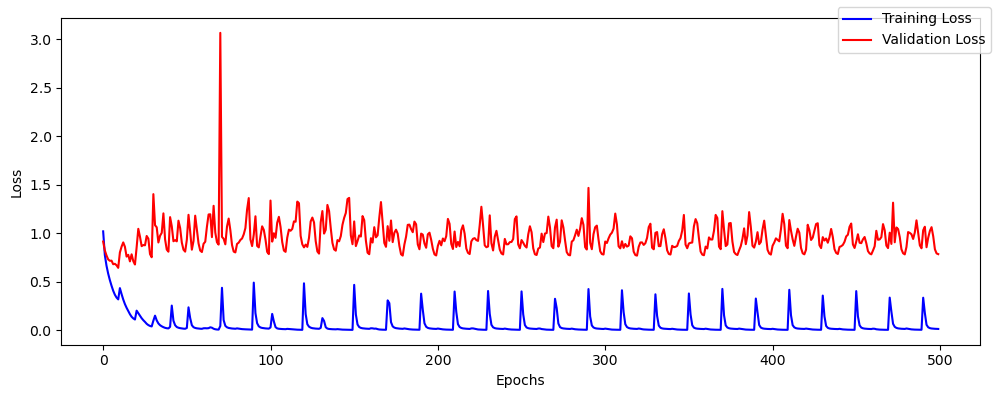

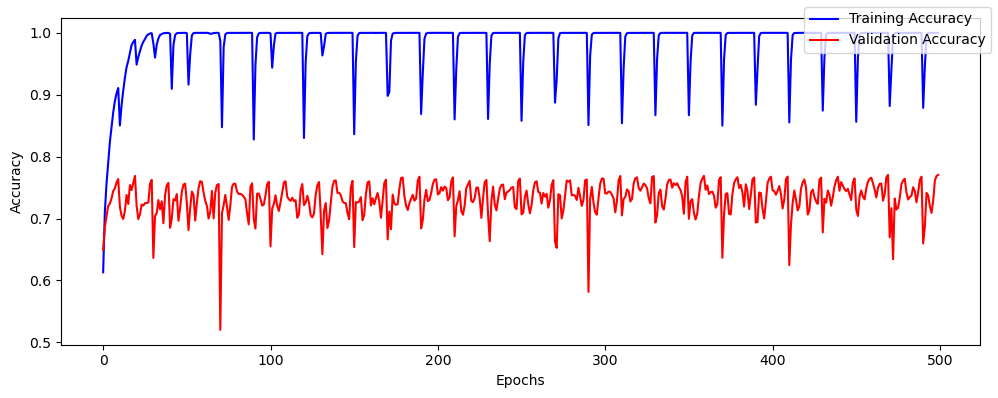

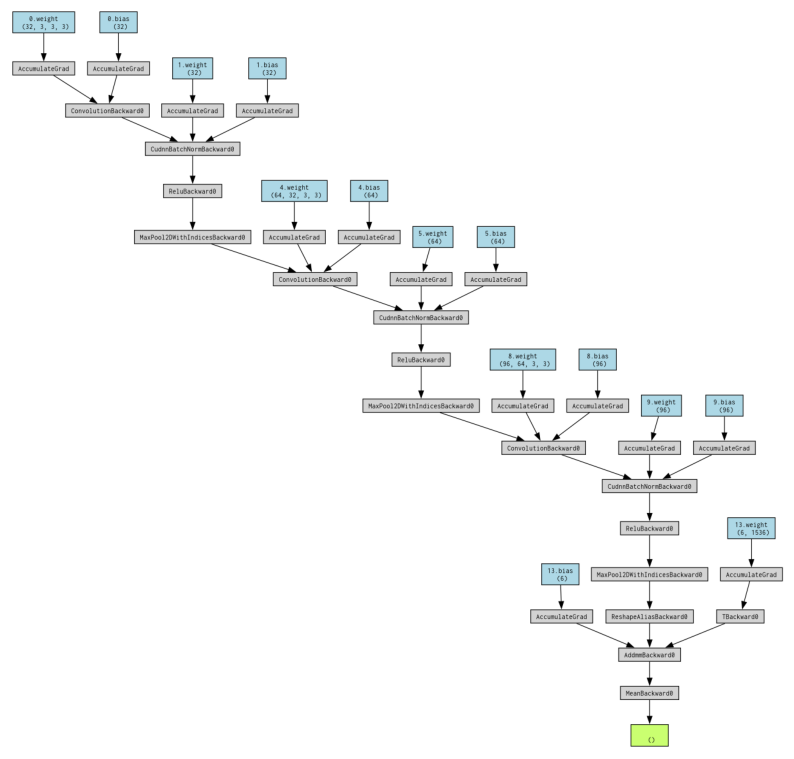

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 6]                    --
├─Conv2d: 1-1                            [1, 32, 32, 32]           896
├─BatchNorm2d: 1-2                       [1, 32, 32, 32]           64
├─ReLU: 1-3                              [1, 32, 32, 32]           --
├─MaxPool2d: 1-4                         [1, 32, 16, 16]           --
├─Conv2d: 1-5                            [1, 64, 16, 16]           18,496
├─BatchNorm2d: 1-6                       [1, 64, 16, 16]           128
├─ReLU: 1-7                              [1, 64, 16, 16]           --
├─MaxPool2d: 1-8                         [1, 64, 8, 8]             --
├─Conv2d: 1-9                            [1, 96, 8, 8]             55,392
├─BatchNorm2d: 1-10                      [1, 96, 8, 8]             192
├─ReLU: 1-11                             [1, 96, 8, 8]             --
├─MaxPool2d: 1-12                        [1, 96, 4, 4]             --
├─Fl

In [103]:
m3_2 = nn.Sequential(
    # First conv block
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    # Second conv block with smaller kernel
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    # Third conv block with smaller kernel
    nn.Conv2d(64, 96, kernel_size=3, padding=1),
    nn.BatchNorm2d(96),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    nn.Flatten(),
    nn.Linear(96 * 4 * 4, 6)
)

# AdamW optimiser
optimizer = optim.AdamW(
    m3_2.parameters(),
    lr=0.0005,  
    weight_decay=0.25  # L2 reguralisation 
)

# cosine annealer warm restart shdeuler
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=10,  # number of epoches for restart
    T_mult=1,  # cycle length
    eta_min=0.000001
)
loss = nn.CrossEntropyLoss()

# build model
model_buildero = ModelBuilder(m3_2, loss, optimizer, print_loss_freq=1)
model_buildero.set_loaders(train_loader, val_loader)

# training loop including scheduler
for epoch in range(500):  
    print(f"Epoch {epoch + 1}/{500}")
    model_buildero.train(n_epochs=1)
    scheduler.step() # sheduler steps @ each eopch



# plot results
#model_buildero.save_checkpoint("m3_2.pth")
model_buildero.plot_losses()
model_buildero.plot_accuracies()
plt.show()

#sample input/output for summary()
sample_input = torch.randn(2, 3, 32, 32).to(device) 
output = m3_2(sample_input)

# render and plot the model archietichure using make_dot() and summary 
make_dot(output.mean(), params=dict(m3_2.named_parameters())).render("images/m3_2", format="png")
img = Image.open("images/m3_2.png")
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")
plt.show()

# Print model summary
print(summary(m3_2, input_size=(1, 3, 32, 32)))

## 3.2 (M3) Model Evaluation 

 First validation image shape :   torch.Size([1, 3, 32, 32])
First 10 validation labels:   tensor([3, 1, 5, 2, 5, 1, 0, 1, 1, 1])
Predictions shape:   (5000, 6)

First 10 predicted labels : tensor([2, 1, 5, 1, 5, 1, 0, 1, 1, 3])


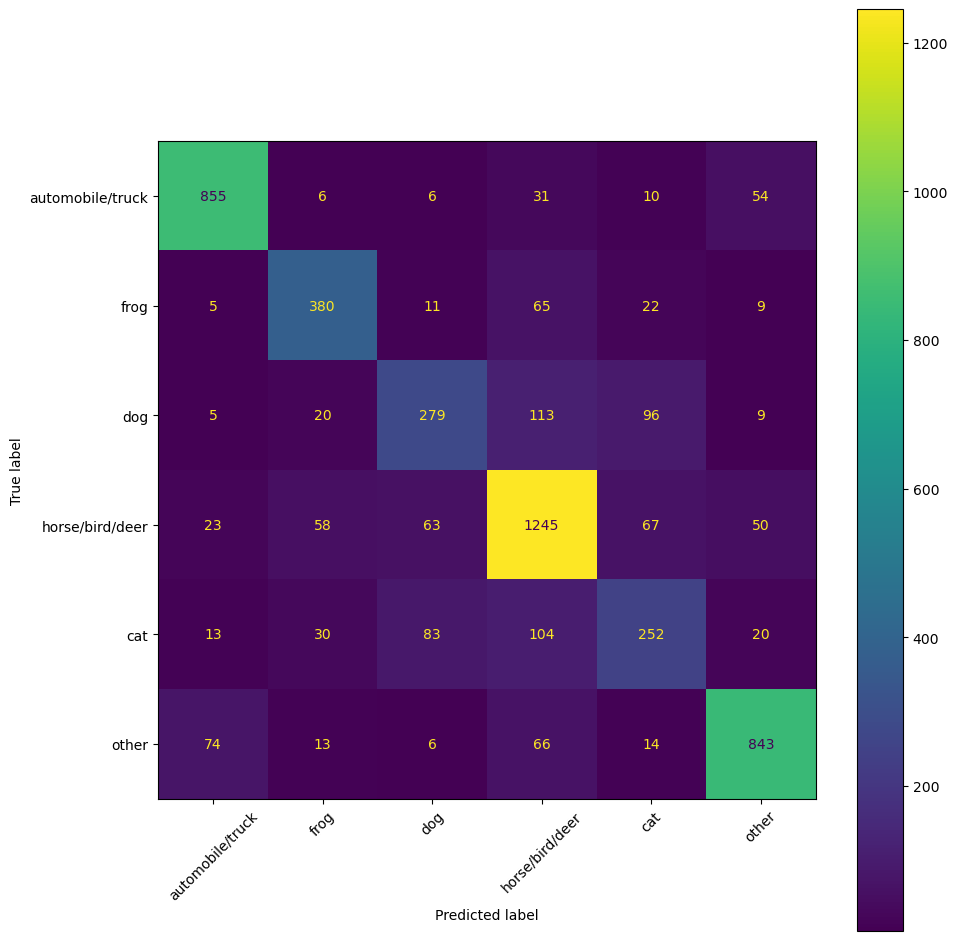


Validation Accuracy : 77.08%


In [104]:
# retrieve features (images here) and labels
x_val = [torch.as_tensor(t[0]).unsqueeze(0) for t in list(val_set)]
y_val = torch.tensor([t[1] for t in list(val_set)])  # Convert to tensor directly

# sanity check
print(" First validation image shape :  ", x_val[0].shape)
print("First 10 validation labels:  ", y_val[:10])

# apply the model to each image and reshape prediction tensor
val_predictions = np.array([model_buildero.predict(i) for i in x_val])
val_predictions = val_predictions.squeeze()
print("Predictions shape:  ", val_predictions.shape)

# convert to torch tensor so that Softmax can be applied
val_predictions = torch.from_numpy(val_predictions)

# convert predictions to probabilities
val_probab = nn.Softmax(dim=1)(val_predictions)

# finally, get predicted class labels
val_pred = torch.argmax(val_probab, dim=1)
print("\nFirst 10 predicted labels :", val_pred[:10])

#Confusion matrix
new_classes = ["automobile/truck", "frog", "dog", "horse/bird/deer", "cat", "other"]
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(
    y_val.cpu().numpy(),
    val_pred.cpu().numpy(),
    display_labels=new_classes,
    ax=ax,
    xticks_rotation=45,
)
plt.grid(False)
plt.tight_layout()
plt.show()

#calculate validation accuracy
val_correct = (val_pred == y_val).float()
val_accuracy = val_correct.mean()
print(f'\nValidation Accuracy : {val_accuracy*100:.2f}%')


First validation image shape: torch.Size([1, 3, 32, 32])
1st 10 validation labels: tensor([2, 2, 5, 3, 3, 3, 0, 3, 2, 3])
Predictions shape : (5000, 6)


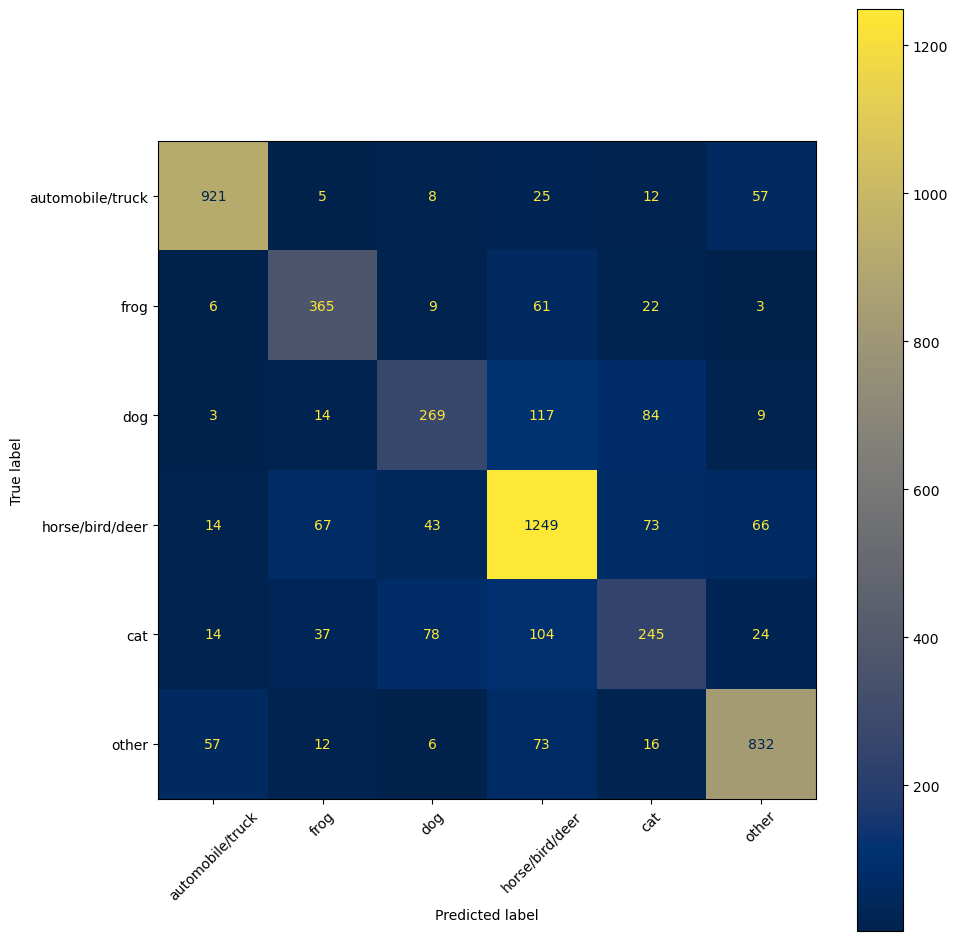


Test Accuracy : 77.62%


In [105]:

# retrieve features (images here) and labels
x_test = [torch.as_tensor(t[0]).unsqueeze(0) for t in list(test_set)]
y_test = torch.tensor([t[1] for t in list(test_set)])

# sanity check
print("First validation image shape:", x_test[0].shape)
print("1st 10 validation labels:", y_test[:10])

# apply the model to each image and reshape prediction tensor
test_predictions = np.array([model_buildero.predict(i) for i in x_test])
test_predictions = test_predictions.squeeze()
print("Predictions shape :", test_predictions.shape)

 

# convert to torch tensor so that Softmax can be applied
test_predictions = torch.from_numpy(test_predictions)

# convert predictions to probabilities
test_probab = nn.Softmax(dim=1)(test_predictions)

# finally, get predicted class labels
test_pred = torch.argmax(test_probab, dim=1)

#Confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(
    y_test.cpu().numpy(),
    test_pred.cpu().numpy(),
    display_labels=new_classes,
    ax=ax,
    xticks_rotation=45,
    cmap='cividis'
)
plt.grid(False)
plt.tight_layout()
plt.show()

#calculate test accuracy
test_correct = (test_pred == y_test).float()
test_accuracy = test_correct.mean()
print(f'\nTest Accuracy : {test_accuracy*100:.2f}%')


## 3.3 (M3) Analysis
**Three-Block CNN Architecture**

Our experimentation with the **three-block CNN (M3)** proved more efficient than **M2**, requiring less computational effort in general to achieve better results. While the model allowed for less constraints with 3 convloutional blocks we had more flexibility in tuning the model and achieving better performance as well, in this model we as well more advanced optimisation techniques were requiered, as initial attempts without **schedulers, normalisation** and **weight decay** struggled to exceed **73-74% accuracy** (see attempts in **Appendix 5.2**), and eventually the models will start to overfit and consquently prefom poorly on more generaliased data, hence we had no option but to implement these methods due to time, computational, and financial constraints.

The model achieved **77.08% validation accuracy** and **77.62% test accuracy**, showcasing strong consistency across datasets. The confusion matrices demonstrate robust classification performance, particularly for **vehicle** and **animal categories**.

In training this model, we witnessed unusual periodic spikes in the validation loss graph, after investigation we deduced those flactuations were because of **CosineAnnealingWarmRestart scheduler's** warm restarts and its restart cycle **T_0=10** hyper-paramter, though these fluctuations did not impair the model's performance and roboustness.

The model can be further improved with more training and further tuning **CosineAnnealingWarmRestart** hyper-parameters.


# 4. (M3o) Optimised Model

## 4.1 Transformation 2.0, Loading Dataset, and Class Balancing


Checking class distribution in splits before weight sampling:
count of label 0.0 = 3018.00
freq of label 0.0 = 20.12
count of label 1.0 = 1522.00
freq of label 1.0 = 10.15
count of label 2.0 = 1561.00
freq of label 2.0 = 10.41
count of label 3.0 = 4477.00
freq of label 3.0 = 29.85
count of label 4.0 = 1493.00
freq of label 4.0 = 9.95
-------------------------------------------------

Checking class distribution in splits after weight sampling:
count of label 0.0 = 2444.00
freq of label 0.0 = 16.29
count of label 1.0 = 2447.00
freq of label 1.0 = 16.31
count of label 2.0 = 2386.00
freq of label 2.0 = 15.91
count of label 3.0 = 2438.00
freq of label 3.0 = 16.25


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..2.115826].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..1.6463127].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..2.1264887].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..2.0273557].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..2.1264887].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..2.100835].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737.

count of label 4.0 = 2471.00
freq of label 4.0 = 16.47


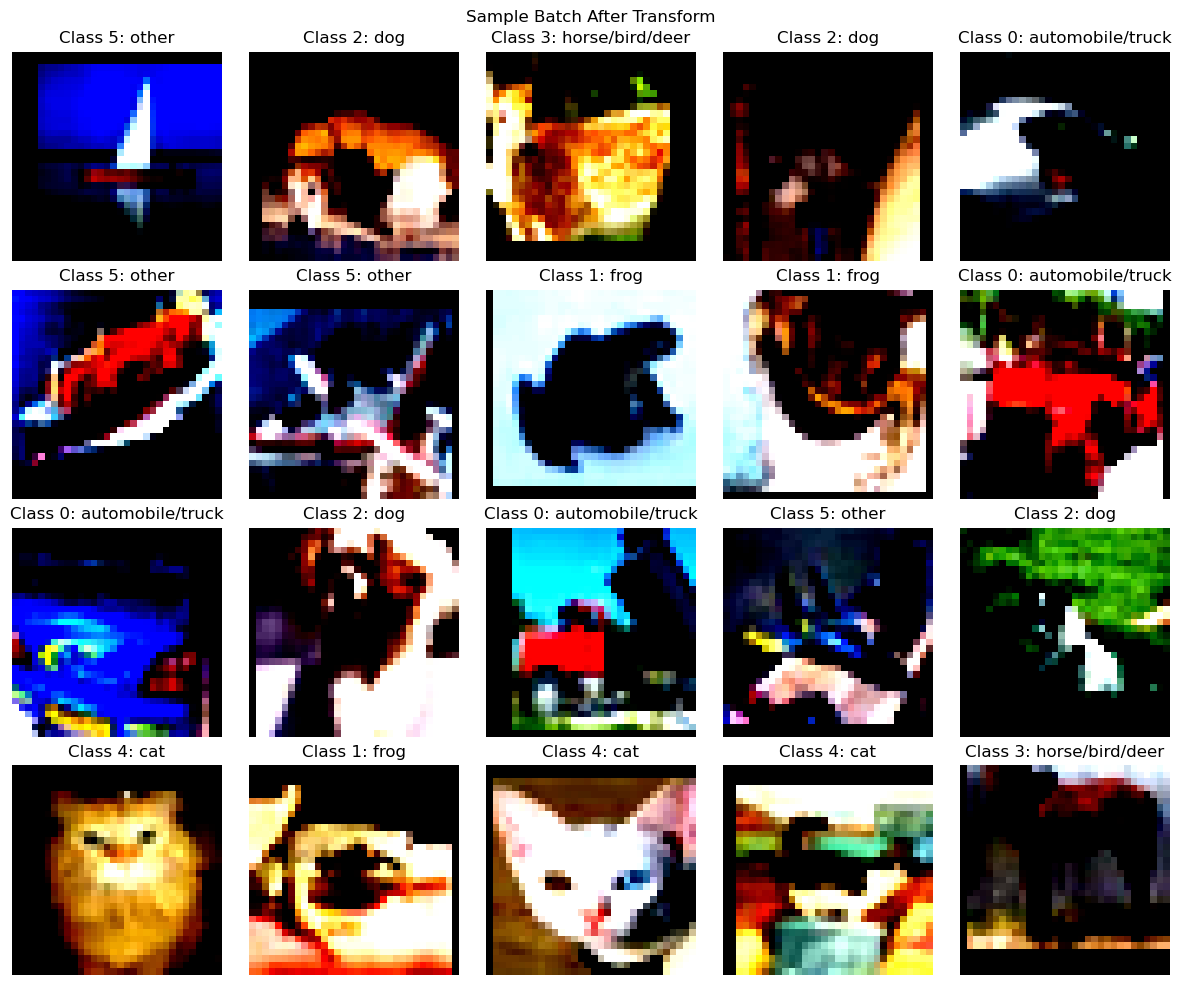

In [107]:
#device = torch.device("cuda")
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),  # More efficient than affine
    v2.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2470, 0.2435, 0.2616]
    )
])

dataset = TransformedTensorDataset(
    x_tensor,
    y_tensor_new,
    transform=transform)

# spliting into train-validation-test sets
train_size, val_size, test_size = 15000, 5000, 5000
train_set, val_set, test_set, _ = torch.utils.data.random_split(
    dataset,[
        train_size,
        val_size,
        test_size,
        len(dataset) - (train_size + val_size + test_size)], # _ for the rest of dataset
)


# BATCH SIZE 

batch_size = 64

#
#CLASS BALANCING
# 

# class distribution check in each set before applying weight sampler  

print("\nChecking class distribution in splits before weight sampling:")

train_loader_ = DataLoader(train_set, batch_size=batch_size, sampler=None)
val_loader_ = DataLoader(val_set, batch_size=batch_size)
test_loader_ = DataLoader(test_set, batch_size=batch_size)


count_freq_in_batch(train_loader_, range(5), len(train_set))  

print("-------------------------------------------------")


# class distribution check in each set after applying weight sampler 
print("\nChecking class distribution in splits after weight sampling:")

train_sampler = weighted_sampler(y_tensor_new[train_set.indices], device)

train_loader_op = DataLoader(train_set, batch_size=batch_size, sampler=train_sampler)
val_loader_op = DataLoader(val_set, batch_size=batch_size)
test_loader_op = DataLoader(test_set, batch_size=batch_size)


# counts frequency in batches 
count_freq_in_batch(train_loader_op, range(5), len(train_set))  

# check a single batch
it = iter(train_loader_op)
images, labels = next(it)

# plots the first 20 images from the batch
fig, axes = plt.subplots(4, 5, figsize=(12, 10))
axes = axes.ravel()

for idx in range(min(20, len(images))):
    img = images[idx]
    label = labels[idx].item()
    if label < len(new_classes):  
        axes[idx].imshow(img.permute(1, 2, 0))
        axes[idx].axis("off")
        axes[idx].set_title(f"Class {label}: {new_classes[label]}")

plt.suptitle("Sample Batch After Transform")
plt.tight_layout()
plt.show()

## 4.2 (M3 Optimised) - Sequential CNN (3 Convolution Blocks) Model

Epoch 1/300
Epoch 1, Training loss: 1.6474, accuracy: 0.3042, Validation loss: 1.4511, accuracy: 0.4007
Epoch 2/300
Epoch 1, Training loss: 1.4867, accuracy: 0.3869, Validation loss: 1.3271, accuracy: 0.4608
Epoch 3/300
Epoch 1, Training loss: 1.4265, accuracy: 0.4200, Validation loss: 1.3016, accuracy: 0.4808
Epoch 4/300
Epoch 1, Training loss: 1.3892, accuracy: 0.4342, Validation loss: 1.2496, accuracy: 0.5160
Epoch 5/300
Epoch 1, Training loss: 1.3400, accuracy: 0.4597, Validation loss: 1.2234, accuracy: 0.5101
Epoch 6/300
Epoch 1, Training loss: 1.3128, accuracy: 0.4750, Validation loss: 1.2026, accuracy: 0.5271
Epoch 7/300
Epoch 1, Training loss: 1.2880, accuracy: 0.4865, Validation loss: 1.1787, accuracy: 0.5324
Epoch 8/300
Epoch 1, Training loss: 1.2716, accuracy: 0.4917, Validation loss: 1.1539, accuracy: 0.5394
Epoch 9/300
Epoch 1, Training loss: 1.2686, accuracy: 0.4949, Validation loss: 1.1231, accuracy: 0.5532
Epoch 10/300
Epoch 1, Training loss: 1.2361, accuracy: 0.5053, V

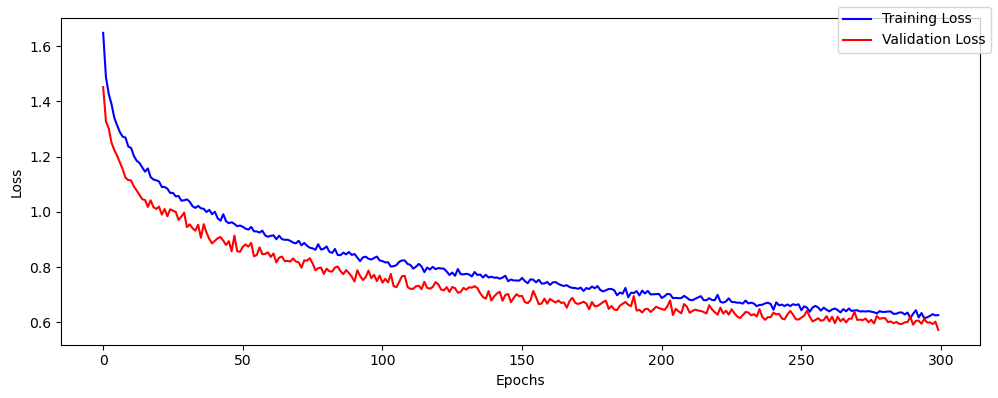

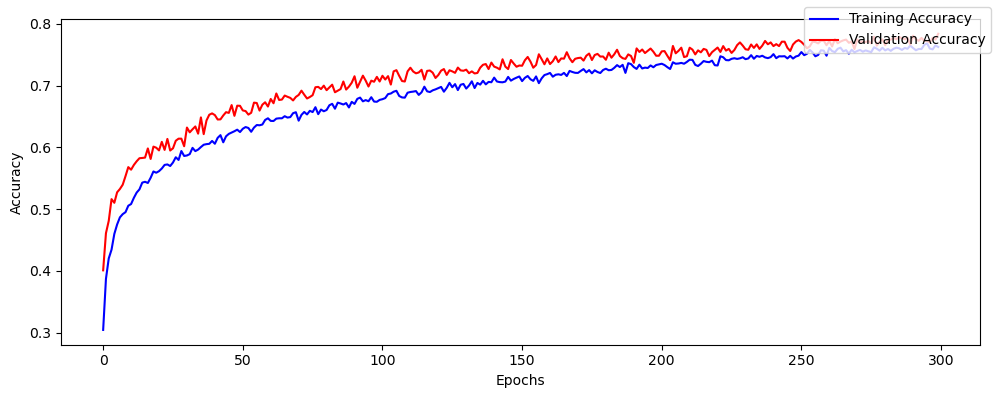

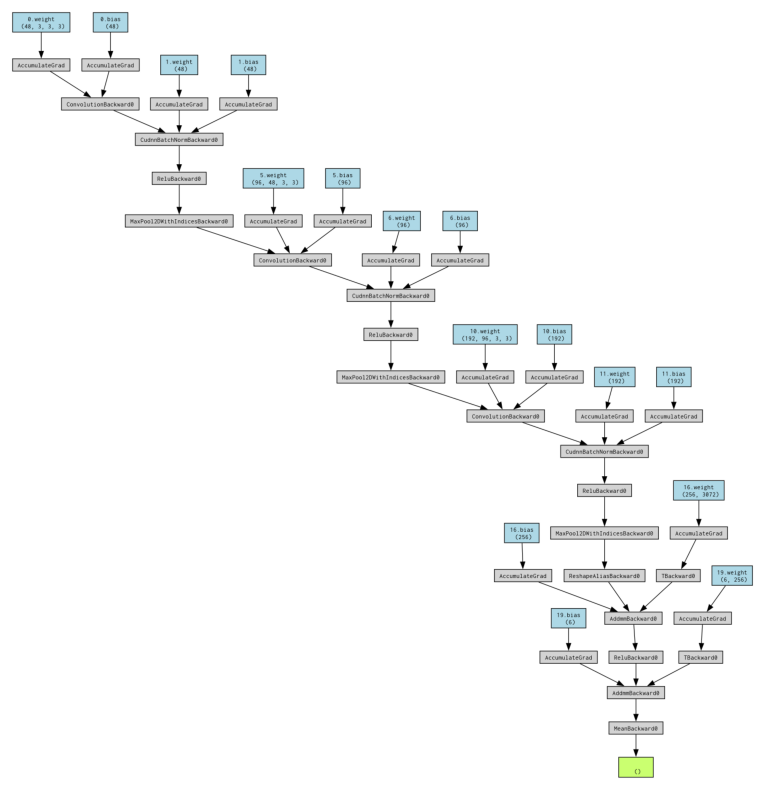

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 6]                    --
├─Conv2d: 1-1                            [1, 48, 32, 32]           1,344
├─BatchNorm2d: 1-2                       [1, 48, 32, 32]           96
├─ReLU: 1-3                              [1, 48, 32, 32]           --
├─Dropout2d: 1-4                         [1, 48, 32, 32]           --
├─MaxPool2d: 1-5                         [1, 48, 16, 16]           --
├─Conv2d: 1-6                            [1, 96, 16, 16]           41,568
├─BatchNorm2d: 1-7                       [1, 96, 16, 16]           192
├─ReLU: 1-8                              [1, 96, 16, 16]           --
├─Dropout2d: 1-9                         [1, 96, 16, 16]           --
├─MaxPool2d: 1-10                        [1, 96, 8, 8]             --
├─Conv2d: 1-11                           [1, 192, 8, 8]            166,080
├─BatchNorm2d: 1-12                      [1, 192, 8, 8]            384
├

In [113]:
m3_o0 =nn.Sequential(
    
    nn.Conv2d(3, 48, kernel_size=3, padding=1),  
    nn.BatchNorm2d(48),
    nn.ReLU(),
    nn.Dropout2d(0.2),
    nn.MaxPool2d(2, 2),
    
    
    nn.Conv2d(48, 96, kernel_size=3, padding=1),  
    nn.BatchNorm2d(96),
    nn.ReLU(),
    nn.Dropout2d(0.3),
    nn.MaxPool2d(2, 2),
    
    
    nn.Conv2d(96, 192, kernel_size=3, padding=1),  
    nn.BatchNorm2d(192),
    nn.ReLU(),
    nn.Dropout2d(0.4),
    nn.MaxPool2d(2, 2),
    
    nn.Flatten(),
    nn.Linear(192 * 4 * 4, 256), 
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 6)
)

# AdamW optimiser
optimizer = optim.AdamW(
    m3_o0.parameters(),
    lr=0.001,  
    weight_decay=0.05  
)


scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.001,
    epochs=300,
    steps_per_epoch=len(train_loader_op),
    pct_start=0.2, 
    div_factor=25,
    final_div_factor=1000,
    anneal_strategy='cos'
)

loss = nn.CrossEntropyLoss()

# train the model
model_buildero = ModelBuilder(m3_o0, loss, optimizer, print_loss_freq=1)
model_buildero.set_loaders(train_loader_op, val_loader_op)


for epoch in range(300):
    print(f"Epoch {epoch + 1}/{300}")
    model_buildero.train(n_epochs=1)
    scheduler.step()  

#model_buildero.save_checkpoint("m3_o.pth")
model_buildero.plot_losses()
model_buildero.plot_accuracies()
plt.show()

# Render and plot the model architecture
sample_input = torch.randn(2, 3, 32, 32).to(device) 
output = m3_o0(sample_input)

make_dot(output.mean(), params=dict(m3_o0.named_parameters())).render("images/m3_o0", format="png")
img = Image.open("images/m3_o0.png")
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")
plt.show()


print(summary(m3_o0, input_size=(1, 3, 32, 32)))


## 4.3 (M3o) Model Evaluation 

First validation image shape:   torch.Size([1, 3, 32, 32])
First 10 validation labels :   tensor([5, 4, 2, 5, 3, 5, 1, 2, 1, 4])
predictions shape :  (5000, 6)
Unique classes in true labels: tensor([0, 1, 2, 3, 4, 5])
Unique classes in predictions: tensor([0, 1, 2, 3, 4, 5])

First 10 predicted labels : tensor([5, 4, 3, 0, 5, 5, 1, 4, 1, 3])


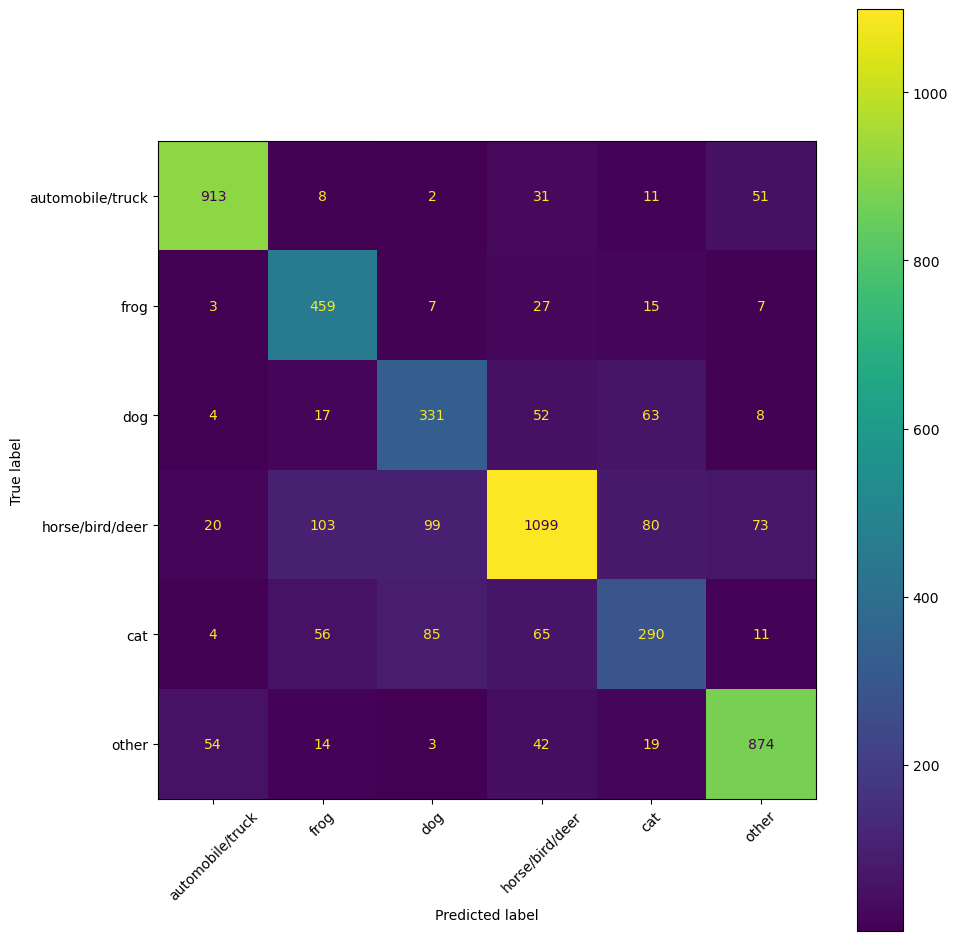

Validation Accuracy: 79.32%


In [114]:
# retrieve features (images here) and labels
x_val = [torch.as_tensor(t[0]).unsqueeze(0) for t in list(val_set)]
y_val = torch.tensor([t[1] for t in list(val_set)])  # Convert to tensor directly

# sanity check
print("First validation image shape:  ", x_val[0].shape)
print("First 10 validation labels :  ", y_val[:10])

# apply the model to each image and reshape prediction tensor
val_predictions = np.array([model_buildero.predict(i) for i in x_val])
val_predictions = val_predictions.squeeze()  
print("predictions shape : ", val_predictions.shape)

# convert to torch tensor so that Softmax can be applied
val_predictions = torch.from_numpy(val_predictions)

# convert predictions to probabilities
val_probab = nn.Softmax(dim=1)(val_predictions)

print("Unique classes in true labels:", torch.unique(y_val))
print("Unique classes in predictions:", torch.unique(val_pred))

# finally, get predicted class labels
val_pred = torch.argmax(val_probab, dim=1)
print("\nFirst 10 predicted labels :", val_pred[:10])

# remapped class names + class for anything else "other"
new_classes = ["automobile/truck", "frog", "dog", "horse/bird/deer", "cat", "other"]

#Confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(
    y_val.cpu().numpy(),
    val_pred.cpu().numpy(),
    display_labels=new_classes,
    ax=ax,
    xticks_rotation=45
)
plt.grid(False)
plt.tight_layout() 
plt.show()

#validation accuracy
val_correct = (val_pred == y_val).float()
val_accuracy = val_correct.mean()
print(f'Validation Accuracy: {val_accuracy*100:.2f}%')

Predictions shape: (5000, 6)

Unique classes in true labels: tensor([0, 1, 2, 3, 4, 5])
Unique classes in predictions: tensor([0, 1, 2, 3, 4, 5])

Sample of predictions: tensor([0, 5, 4, 3, 0, 0, 5, 4, 3, 0, 3, 0, 3, 5, 5, 4, 0, 5, 2, 5])
Sample of true labels: tensor([0, 3, 4, 3, 0, 0, 5, 3, 3, 5, 3, 0, 3, 5, 5, 4, 0, 5, 3, 5])


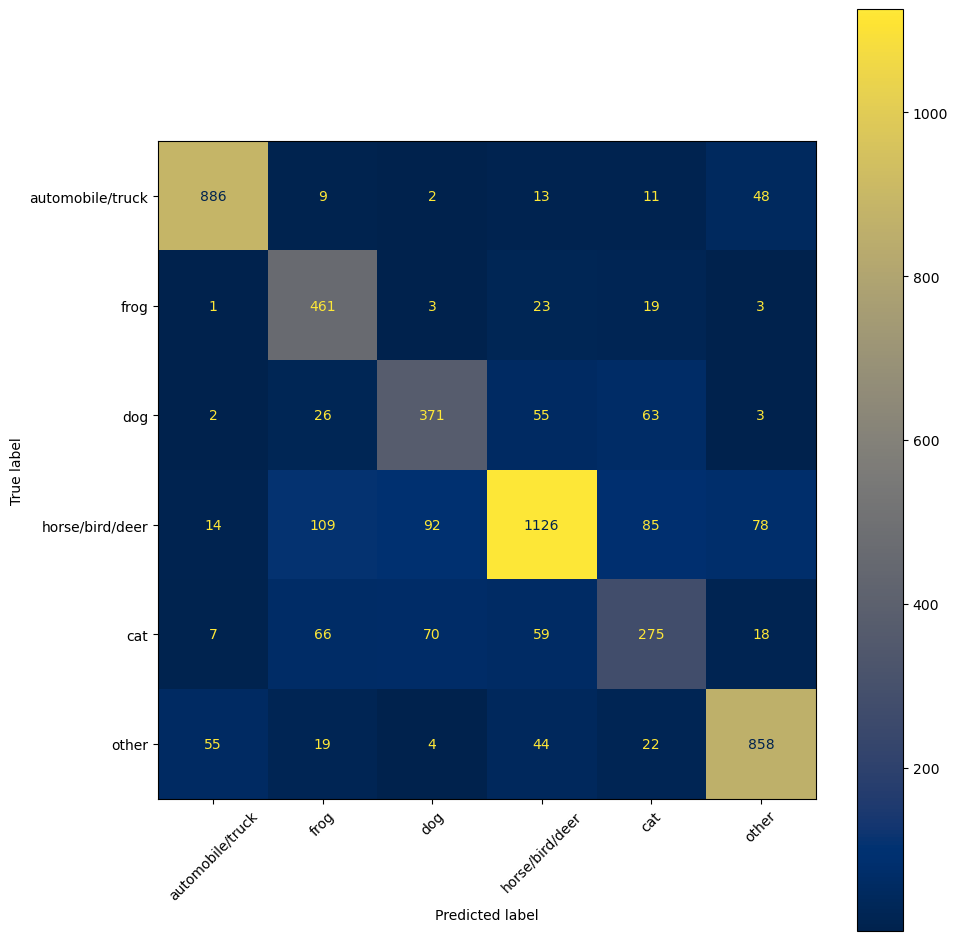


Overall Test Accuracy: 79.54%


In [115]:
# retrieve features (images here) and labels
x_test = [torch.as_tensor(t[0]).unsqueeze(0) for t in list(test_set)]
y_test = torch.tensor([t[1] for t in list(test_set)])

# apply the model and get predictions
test_predictions = np.array([model_buildero.predict(i) for i in x_test])
test_predictions = test_predictions.squeeze()
print("Predictions shape:", test_predictions.shape)

# convert to probabilities and get predicted classes
test_predictions = torch.from_numpy(test_predictions)
test_probab = nn.Softmax(dim=1)(test_predictions)
test_pred = torch.argmax(test_probab, dim=1)

# Diagnostics
print("\nUnique classes in true labels:", torch.unique(y_test))
print("Unique classes in predictions:", torch.unique(test_pred))
print("\nSample of predictions:", test_pred[:20])
print("Sample of true labels:", y_test[:20])

# Confusion matrix
new_classes = ["automobile/truck", "frog", "dog", "horse/bird/deer", "cat", "other"]
fig, ax = plt.subplots(figsize=(10, 10))
cm = ConfusionMatrixDisplay.from_predictions(
    y_test.cpu().numpy(),
    test_pred.cpu().numpy(),
    display_labels=new_classes,
    ax=ax,
    xticks_rotation=45,
    cmap='cividis'
)
plt.grid(False)
plt.tight_layout()
plt.show()

# Calculate overall and per-class metrics
test_correct = (test_pred == y_test).float()
test_accuracy = test_correct.mean()
print(f'\nOverall Test Accuracy: {test_accuracy*100:.2f}%')

## 4.4 (M3o) Analysis
 **Optimised Three-Block CNN Architecture (M3o)**

Building upon our **M3 architecture**, we developed an optimised model version (**M3o**) with three convolusional blocks by significantly deepening the model's neuronal layers count. We increased Conv2d filter sizes progressively (48->96->192) compared to **M3's** (32->64->96) and introduced gradually increasing **dropout layers** (0.2->0.3->0.4) through out the convolutional blocks with a final dropout of **0.5** in the fully connected layer.

The enhanced architecture combined with careful tuning of the **OneCycleLR scheduler**, **L2 regularisation weight decay** (0.05), and basic **data augmentation** (horizontal flips, random crops, and normalisation), yielded impressive results. We experimnted with more extensive augmentation methods seen in litereture review popularly done on **CIFAR-10**, but eventually they were avoided as they rendered our model very slow and we are limited by computaional resources .
The model achieved **79.32% validation accuracy** and **79.54% test accuracy** demonstrating remarkable improvement over both **M2** and base **M3 models**. The confusion matrices demonstrated good classification performance, particularly in distinguishing between similar categories (**cats/dogs, vehicles**) indicating reliable class separation and genralisation.

Furthermore, the loss graph show healthy convergence without indication of overfitting suggesting effective regularisation through our dropout strategy, and more room to obtain higher accuracy with further training and those improvements can be further improved using further data augmenation techniques, batch sizes, and many other hyperparamters tuning. 

Finally, we also tinkerd with **ResNet34**, and **VGG** style with 3 Conv2d blocks architecture, the **ResNet34** model yielded an impressive **74% accuracy** in just **30 epochs** without any signs of overfitting, showcasing how effective residual connections can be and the room for obtaining much better accuracy with more training, while the **VGG** model managed to reach **70% accuracy** without signs of overfitting in only **30 epochs** that also showcases room for improvment with more training. These models results can be seen below in **(Appendix 5.1)** 



# 5. Appendix: Additional Models Experimentation 

## 5.1 Experimnatl Models

### 5.1.1 VGG Model

Epoch 1, Training loss: 1.5800, accuracy: 0.3278, Validation loss: 1.4489, accuracy: 0.3643
Epoch 2, Training loss: 1.3890, accuracy: 0.4234, Validation loss: 1.3091, accuracy: 0.4375
Epoch 3, Training loss: 1.2656, accuracy: 0.4801, Validation loss: 1.2233, accuracy: 0.4806
Epoch 4, Training loss: 1.2165, accuracy: 0.4956, Validation loss: 1.1798, accuracy: 0.5067
Epoch 5, Training loss: 1.1555, accuracy: 0.5344, Validation loss: 1.1173, accuracy: 0.5441
Epoch 6, Training loss: 1.1118, accuracy: 0.5534, Validation loss: 1.1053, accuracy: 0.5548
Epoch 7, Training loss: 1.0757, accuracy: 0.5711, Validation loss: 1.1393, accuracy: 0.5405
Epoch 8, Training loss: 1.0539, accuracy: 0.5811, Validation loss: 1.0399, accuracy: 0.5870
Epoch 9, Training loss: 1.0243, accuracy: 0.5871, Validation loss: 1.0193, accuracy: 0.5949
Epoch 10, Training loss: 0.9893, accuracy: 0.6030, Validation loss: 0.9838, accuracy: 0.6161
Epoch 11, Training loss: 0.9652, accuracy: 0.6127, Validation loss: 0.9857, acc

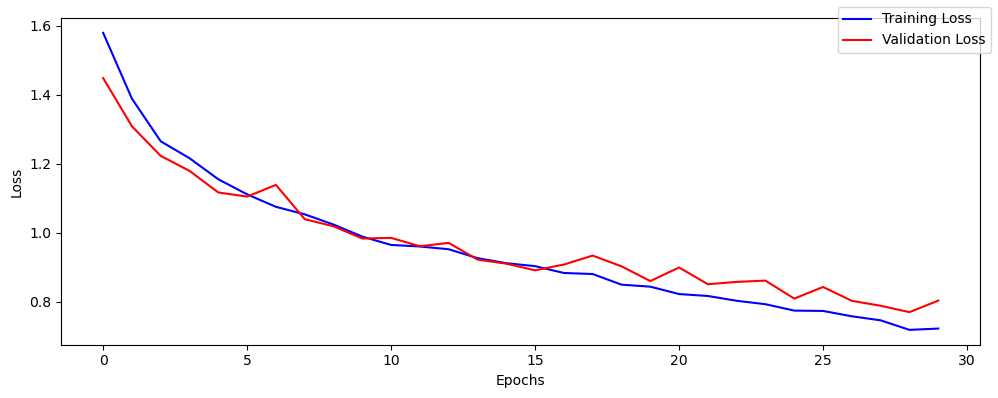

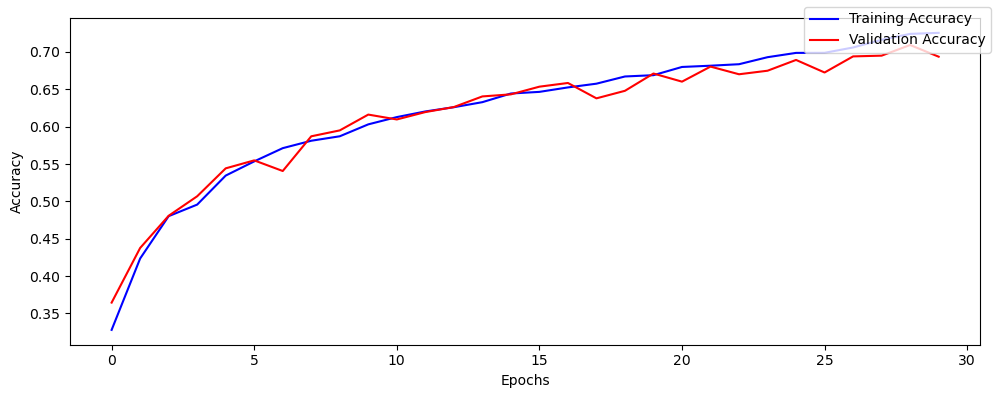

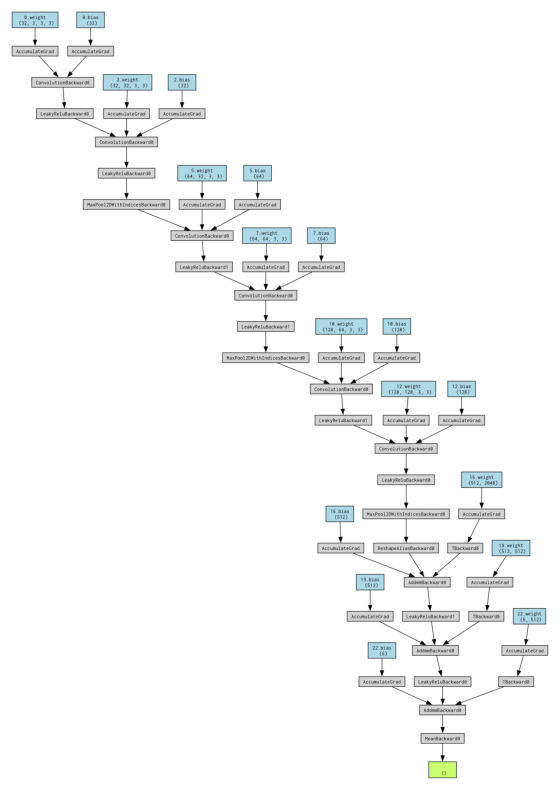

Model Architecture:
Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 6]                    --
├─Conv2d: 1-1                            [1, 32, 32, 32]           896
├─LeakyReLU: 1-2                         [1, 32, 32, 32]           --
├─Conv2d: 1-3                            [1, 32, 32, 32]           9,248
├─LeakyReLU: 1-4                         [1, 32, 32, 32]           --
├─MaxPool2d: 1-5                         [1, 32, 16, 16]           --
├─Conv2d: 1-6                            [1, 64, 16, 16]           18,496
├─LeakyReLU: 1-7                         [1, 64, 16, 16]           --
├─Conv2d: 1-8                            [1, 64, 16, 16]           36,928
├─LeakyReLU: 1-9                         [1, 64, 16, 16]           --
├─MaxPool2d: 1-10                        [1, 64, 8, 8]             --
├─Conv2d: 1-11                           [1, 128, 8, 8]            73,856
├─LeakyReLU: 1-12                        [1, 128,

In [128]:
vgg_model = nn.Sequential(
    # 1st conv block
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.LeakyReLU(),
    nn.Conv2d(32, 32, kernel_size=3, padding=1),
    nn.LeakyReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    # 2nd conv block
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.LeakyReLU(inplace=True),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.LeakyReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    # 3rd conv block
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.LeakyReLU(inplace=True),
    nn.Conv2d(128, 128, kernel_size=3, padding=1),
    nn.LeakyReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    nn.Flatten(),
    
    # fc
    nn.Linear(2048, 512),
    nn.LeakyReLU(inplace=True),
    nn.Dropout(0.3),
    nn.Linear(512, 512),
    nn.LeakyReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 6)
)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg_model.parameters(), lr=0.0001, weight_decay=0.00001)

model_builder = ModelBuilder(vgg_model, loss, optimizer, print_loss_freq=1)
model_builder.set_loaders(train_loader_op, val_loader_op)

model_builder.train(n_epochs=30)

# plot training results
model_builder.plot_losses()
model_builder.plot_accuracies()

plt.show()

# render and plot the model archietichure using make_dot() and summary
sample_input = torch.randn(2, 3, 32, 32).to(device) 
output = vgg_model(sample_input)

make_dot(output.mean(), params=dict(vgg_model.named_parameters())).render("images/cifar10_model_vgg", format="png")
img = Image.open("images/cifar10_model_vgg.png")
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")  
plt.show()


print("Model Architecture:")
print(summary(vgg_model, input_size=(1, 3, 32, 32)))

### 5.1.2 ResNet34 Model

In [49]:
import torch.nn.functional as F

class ResidualBlock(nn.Module):
   
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=6):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(512, num_classes)

    
    def _make_layer(self, block, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels , kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        layers = []    
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)


        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def ResNet34(num_classes=6):
    return ResNet(ResidualBlock, [3, 4, 6, 3], num_classes=num_classes)


Checking class distribution in splits before weight sampling:
count of label 0.0 = 3039.00
freq of label 0.0 = 20.26
count of label 1.0 = 1518.00
freq of label 1.0 = 10.12
count of label 2.0 = 1482.00
freq of label 2.0 = 9.88
count of label 3.0 = 4464.00
freq of label 3.0 = 29.76
count of label 4.0 = 1493.00
freq of label 4.0 = 9.95
-------------------------------------------------

Checking class distribution in splits after weight sampling:
count of label 0.0 = 2512.00
freq of label 0.0 = 16.75
count of label 1.0 = 2485.00
freq of label 1.0 = 16.57
count of label 2.0 = 2501.00
freq of label 2.0 = 16.67
count of label 3.0 = 2542.00
freq of label 3.0 = 16.95


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..1.3051336].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..1.9171237].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..1.8759745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..2.1264887].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..1.8050807].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..1.845993].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737

count of label 4.0 = 2505.00
freq of label 4.0 = 16.70


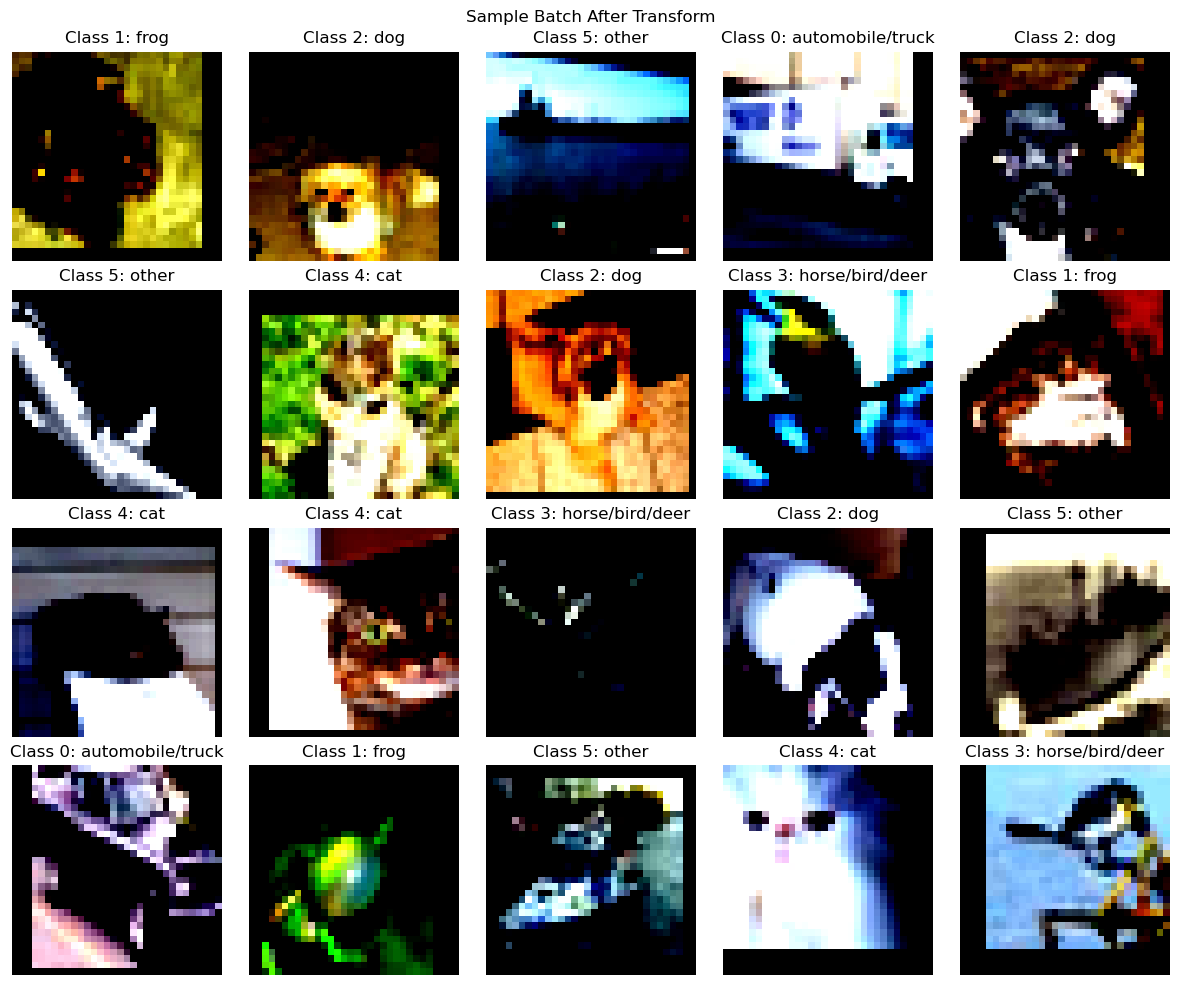

In [120]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform_res = transforms.Compose([
    transforms.Resize((224,224)),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.225, 0.225, 0.225]),
    transforms.ColorJitter(0.1, 0.1, 0.1),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.2),  
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
])


dataset = TransformedTensorDataset(
    x_tensor,
    y_tensor_new,
    transform=transform)

# spliting into train-validation-test sets
train_size, val_size, test_size = 15000, 5000, 5000
train_set, val_set, test_set, _ = torch.utils.data.random_split(
    dataset,[
        train_size,
        val_size,
        test_size,
        len(dataset) - (train_size + val_size + test_size)], # _ for the rest of dataset
)


# BATCH SIZE 

batch_size = 64

#
#CLASS BALANCING
# 

# class distribution check in each set before applying weight sampler  

print("\nChecking class distribution in splits before weight sampling:")

train_loader_ = DataLoader(train_set, batch_size=batch_size, sampler=None)
val_loader_ = DataLoader(val_set, batch_size=batch_size)
test_loader_ = DataLoader(test_set, batch_size=batch_size)


count_freq_in_batch(train_loader_, range(5), len(train_set))  

print("-------------------------------------------------")


# class distribution check in each set after applying weight sampler 
print("\nChecking class distribution in splits after weight sampling:")

train_sampler = weighted_sampler(y_tensor_new[train_set.indices], device)

train_loader_op = DataLoader(train_set, batch_size=batch_size, sampler=train_sampler)
val_loader_op = DataLoader(val_set, batch_size=batch_size)
test_loader_op = DataLoader(test_set, batch_size=batch_size)


# counts frequency in batches 
count_freq_in_batch(train_loader_op, range(5), len(train_set))  

# check a single batch
it = iter(train_loader_op)
images, labels = next(it)

# plots the first 20 images from the batch
fig, axes = plt.subplots(4, 5, figsize=(12, 10))
axes = axes.ravel()

for idx in range(min(20, len(images))):
    img = images[idx]
    label = labels[idx].item()
    if label < len(new_classes):  
        axes[idx].imshow(img.permute(1, 2, 0))
        axes[idx].axis("off")
        axes[idx].set_title(f"Class {label}: {new_classes[label]}")

plt.suptitle("Sample Batch After Transform")
plt.tight_layout()
plt.show()

Epoch 1, Training loss: 1.4313, accuracy: 0.4239, Validation loss: 1.2335, accuracy: 0.5299
Epoch 2, Training loss: 1.1727, accuracy: 0.5344, Validation loss: 1.1196, accuracy: 0.5607
Epoch 10, Training loss: 0.7929, accuracy: 0.6969, Validation loss: 0.8725, accuracy: 0.6756
Epoch 11, Training loss: 0.7684, accuracy: 0.7044, Validation loss: 0.8075, accuracy: 0.6966
Epoch 12, Training loss: 0.7498, accuracy: 0.7115, Validation loss: 0.7819, accuracy: 0.7164
Epoch 13, Training loss: 0.7128, accuracy: 0.7236, Validation loss: 0.8264, accuracy: 0.6966
Epoch 14, Training loss: 0.7109, accuracy: 0.7288, Validation loss: 0.7904, accuracy: 0.7093
Epoch 15, Training loss: 0.6729, accuracy: 0.7472, Validation loss: 0.8855, accuracy: 0.6642
Epoch 16, Training loss: 0.6786, accuracy: 0.7398, Validation loss: 0.7954, accuracy: 0.7025
Epoch 17, Training loss: 0.6387, accuracy: 0.7604, Validation loss: 0.7591, accuracy: 0.7102
Epoch 18, Training loss: 0.6532, accuracy: 0.7493, Validation loss: 0.79

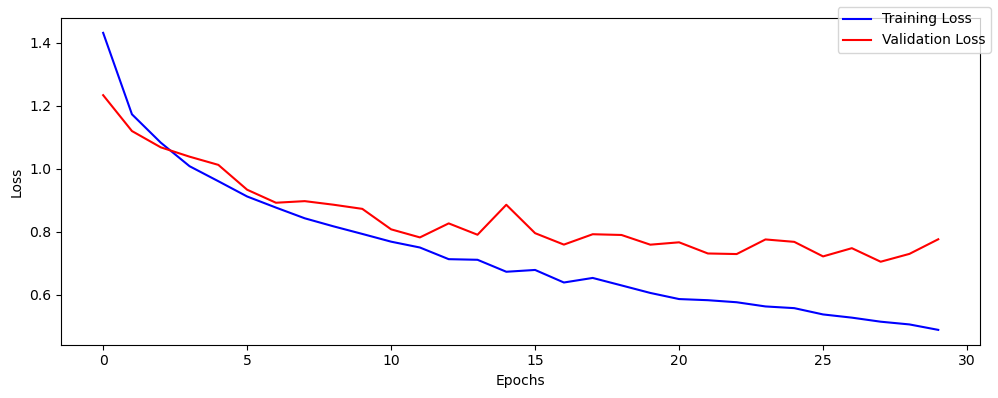

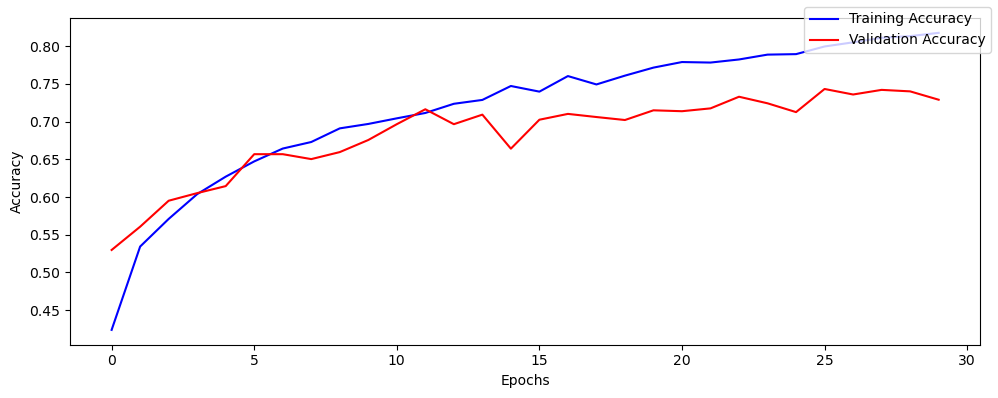

In [127]:
model = ResNet34(num_classes=6)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay = 0.001, momentum = 0.9)  

model_builder = ModelBuilder(
    model=model,
    loss_fn=loss,
    optimizer=optimizer,
    print_loss_freq=1
)


model_builder.set_loaders(train_loader_op, val_loader_op)


model_builder.train(n_epochs=30)
model_builder.plot_losses()
model_builder.plot_accuracies()


## 5.2 Model Attempts

### 5.2.1 M2 - Bad ( 70% accuracy + class balanced)

--------------
Epoch 1, Training loss: 1.7905, accuracy: 0.1689, Validation loss: 1.7829, accuracy: 0.2093
Epoch 2, Training loss: 1.7858, accuracy: 0.1662, Validation loss: 1.7740, accuracy: 0.2104
Epoch 3, Training loss: 1.7794, accuracy: 0.1776, Validation loss: 1.7680, accuracy: 0.2215
Epoch 4, Training loss: 1.7720, accuracy: 0.2115, Validation loss: 1.7594, accuracy: 0.2757
Epoch 5, Training loss: 1.7589, accuracy: 0.2693, Validation loss: 1.7415, accuracy: 0.2658
Epoch 6, Training loss: 1.7420, accuracy: 0.2728, Validation loss: 1.7229, accuracy: 0.3050
Epoch 7, Training loss: 1.7226, accuracy: 0.3130, Validation loss: 1.7064, accuracy: 0.3200
Epoch 8, Training loss: 1.6998, accuracy: 0.3450, Validation loss: 1.6828, accuracy: 0.3406
Epoch 9, Training loss: 1.6737, accuracy: 0.3587, Validation loss: 1.6601, accuracy: 0.3408
Epoch 10, Training loss: 1.6525, accuracy: 0.3752, Validation loss: 1.6296, accuracy: 0.3594
Epoch 11, Training loss: 1.6256, accuracy: 0.3834, Validation lo

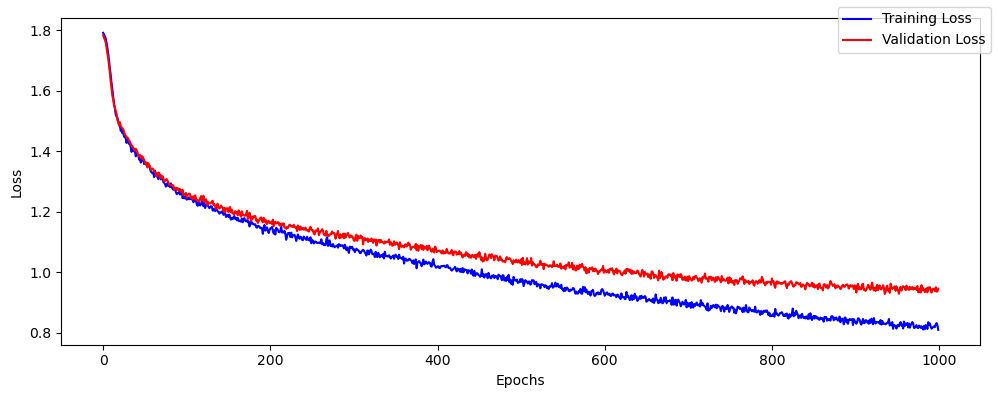

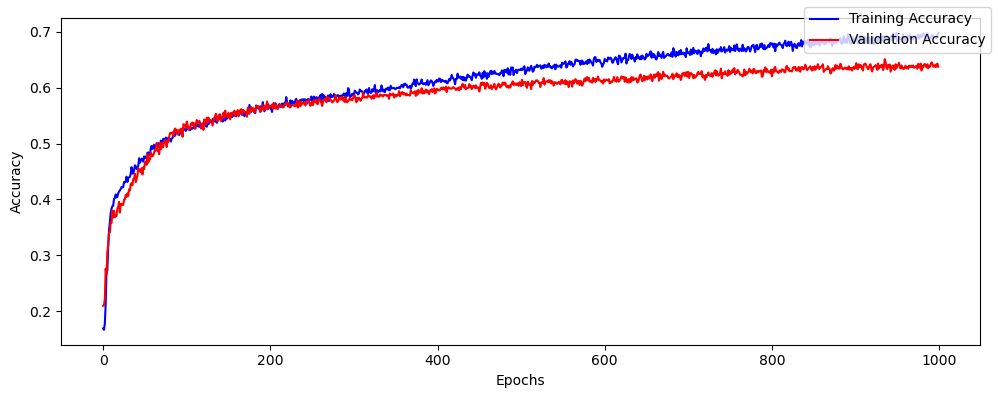

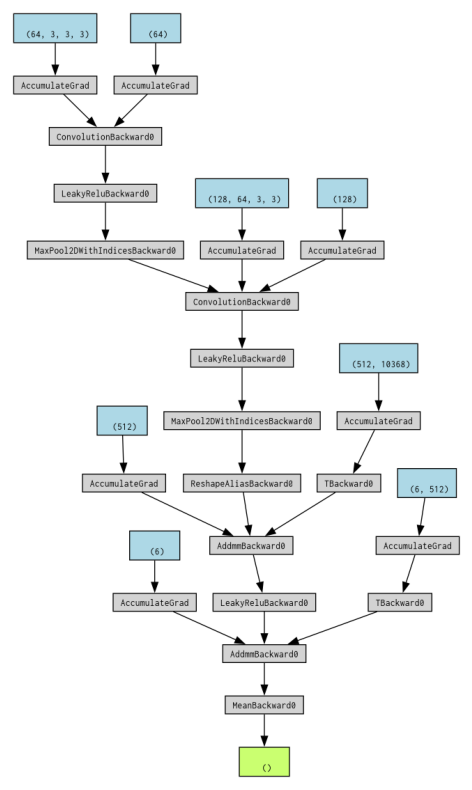

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 6]                    --
├─Conv2d: 1-1                            [1, 32, 34, 34]           896
├─LeakyReLU: 1-2                         [1, 32, 34, 34]           --
├─MaxPool2d: 1-3                         [1, 32, 17, 17]           --
├─Conv2d: 1-4                            [1, 32, 19, 19]           9,248
├─LeakyReLU: 1-5                         [1, 32, 19, 19]           --
├─MaxPool2d: 1-6                         [1, 32, 9, 9]             --
├─Flatten: 1-7                           [1, 2592]                 --
├─Linear: 1-8                            [1, 128]                  331,904
├─LeakyReLU: 1-9                         [1, 128]                  --
├─Linear: 1-10                           [1, 6]                    774
Total params: 342,822
Trainable params: 342,822
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 4.71
Input size (MB): 0.01
Forward/bac

In [61]:
m2 =  nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=2),  
    nn.LeakyReLU(0.1),
    nn.MaxPool2d(2, 2),
    
    nn.Conv2d(32, 32, kernel_size=3, padding=2),  
    nn.LeakyReLU(0.1),
    nn.MaxPool2d(2, 2),
    
    nn.Flatten(),
    
    nn.Linear(2592, 128),  
    nn.LeakyReLU(0.1),
    nn.Linear(128,6) )


print("--------------")


loss = nn.CrossEntropyLoss()

optimizer = optim.AdamW(
    m2.parameters(),
    lr=0.000003,
    weight_decay=0.01,
)


model_builder = ModelBuilder(m2, loss, optimizer, print_loss_freq=1)
model_builder.set_loaders(train_loader, val_loader)

# train the model
model_builder.train(n_epochs=1000)
model_builder.save_checkpoint("checkpoint1.pth")

# plot results
model_builder.plot_losses()
model_builder.plot_accuracies()
plt.show()





#sample input/output for summary()
sample_input = torch.randn(2, 3, 32, 32).to(device) 
output = m2(sample_input)

# render and plot the model archietichure using make_dot() and summary 
make_dot(output.mean(), params=dict(m2.named_parameters())).render("images/cifar10_model_m2", format="png")
img = Image.open("images/cifar10_model_m2.png")
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")  
plt.show()


print(summary(m2, input_size=(1, 3, 32, 32)))

Epoch 1, Training loss: 0.8246, accuracy: 0.6892, Validation loss: 0.9521, accuracy: 0.6347
Epoch 2, Training loss: 0.8264, accuracy: 0.6912, Validation loss: 0.9448, accuracy: 0.6355
Epoch 3, Training loss: 0.8082, accuracy: 0.6992, Validation loss: 0.9291, accuracy: 0.6462
Epoch 4, Training loss: 0.8164, accuracy: 0.6944, Validation loss: 0.9464, accuracy: 0.6367
Epoch 5, Training loss: 0.8178, accuracy: 0.6882, Validation loss: 0.9302, accuracy: 0.6452
Epoch 6, Training loss: 0.8160, accuracy: 0.6941, Validation loss: 0.9509, accuracy: 0.6345
Epoch 7, Training loss: 0.8091, accuracy: 0.6938, Validation loss: 0.9381, accuracy: 0.6410
Epoch 8, Training loss: 0.8122, accuracy: 0.6924, Validation loss: 0.9361, accuracy: 0.6402
Epoch 9, Training loss: 0.8143, accuracy: 0.6924, Validation loss: 0.9295, accuracy: 0.6452
Epoch 10, Training loss: 0.8224, accuracy: 0.6889, Validation loss: 0.9411, accuracy: 0.6369
Epoch 11, Training loss: 0.8275, accuracy: 0.6876, Validation loss: 0.9305, acc

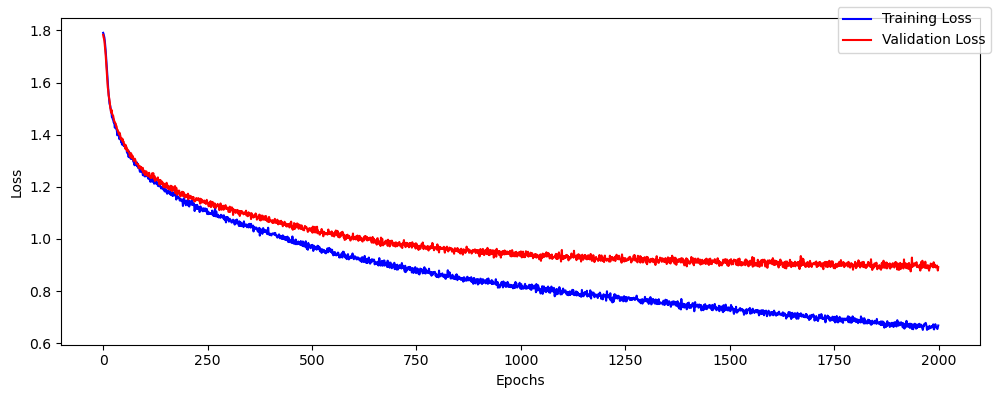

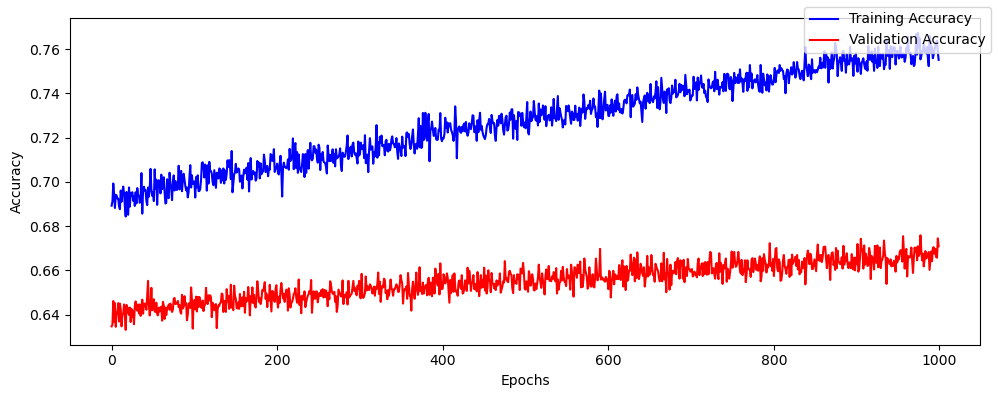

In [63]:
m2_cont = ModelBuilder(m2, loss, optimizer, print_loss_freq=1)


# get the model parameters from the checkpoint
m2_cont.load_checkpoint('checkpoint1.pth')
# provide data to our new model builder object
m2_cont.set_loaders(train_loader, val_loader)
m2_cont.train(n_epochs=1000)
model_builder.save_checkpoint("checkpoint11.pth")

m2_cont.plot_losses()
m2_cont.plot_accuracies()
plt.show()

Epoch 1, Training loss: 0.6735, accuracy: 0.7583, Validation loss: 0.8900, accuracy: 0.6699
Epoch 2, Training loss: 0.6478, accuracy: 0.7677, Validation loss: 0.8852, accuracy: 0.6721
Epoch 3, Training loss: 0.6582, accuracy: 0.7590, Validation loss: 0.8831, accuracy: 0.6735
Epoch 4, Training loss: 0.6593, accuracy: 0.7684, Validation loss: 0.8926, accuracy: 0.6675
Epoch 5, Training loss: 0.6502, accuracy: 0.7649, Validation loss: 0.8968, accuracy: 0.6679
Epoch 6, Training loss: 0.6601, accuracy: 0.7614, Validation loss: 0.8954, accuracy: 0.6683
Epoch 7, Training loss: 0.6698, accuracy: 0.7560, Validation loss: 0.8914, accuracy: 0.6679
Epoch 8, Training loss: 0.6506, accuracy: 0.7659, Validation loss: 0.9064, accuracy: 0.6626
Epoch 9, Training loss: 0.6508, accuracy: 0.7639, Validation loss: 0.9046, accuracy: 0.6650
Epoch 10, Training loss: 0.6532, accuracy: 0.7613, Validation loss: 0.8933, accuracy: 0.6671
Epoch 11, Training loss: 0.6620, accuracy: 0.7590, Validation loss: 0.8800, acc

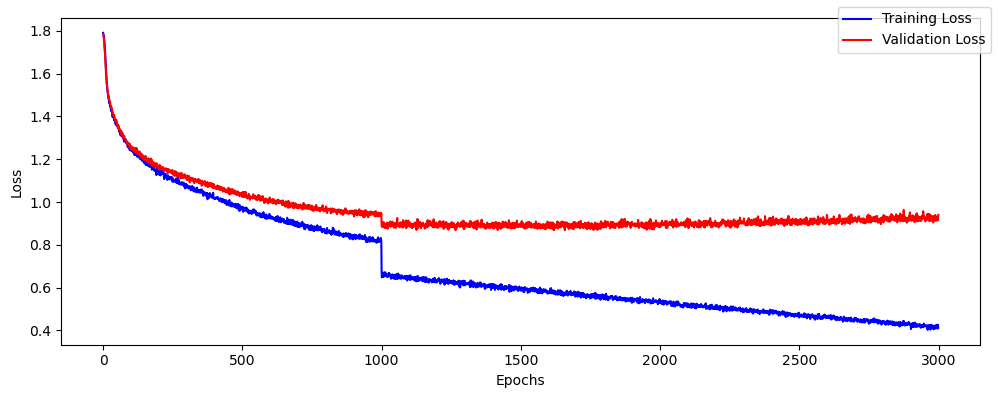

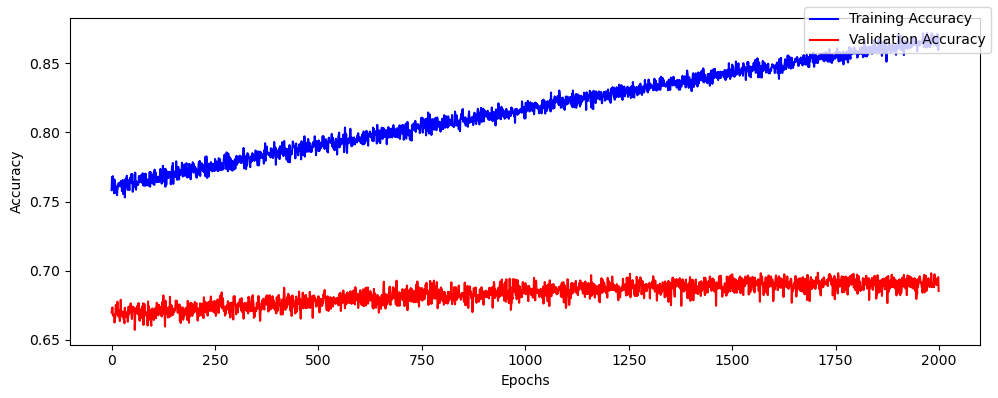

In [64]:
m2_cont2 = ModelBuilder(m2, loss, optimizer, print_loss_freq=1)


# get the model parameters from the checkpoint
m2_cont2.load_checkpoint('checkpoint11.pth')
# provide data to our new model builder object
m2_cont2.set_loaders(train_loader, val_loader)
m2_cont2.train(n_epochs=2000)
model_builder.save_checkpoint("checkpoint111.pth")

m2_cont2.plot_losses()
m2_cont2.plot_accuracies()
plt.show()

In [ ]:
m2_cont = ModelBuilder(m2, loss, optimizer, print_loss_freq=1)


# get the model parameters from the checkpoint
m2_cont.load_checkpoint('checkpoint1_.pth')
# provide data to our new model builder object
m2_cont.set_loaders(train_loader, val_loader)
m2_cont.train(n_epochs=500)
model_builder.save_checkpoint("checkpoint1_1.pth")

m2_cont.plot_losses()
m2_cont.plot_accuracies()
plt.show()

Epoch 1, Training loss: 0.5827, accuracy: 0.7912, Validation loss: 0.8507, accuracy: 0.6855
Epoch 2, Training loss: 0.5806, accuracy: 0.7897, Validation loss: 0.7974, accuracy: 0.7093
Epoch 3, Training loss: 0.5853, accuracy: 0.7943, Validation loss: 0.8081, accuracy: 0.6980
Epoch 4, Training loss: 0.5929, accuracy: 0.7866, Validation loss: 0.8109, accuracy: 0.7047
Epoch 5, Training loss: 0.5754, accuracy: 0.7963, Validation loss: 0.8099, accuracy: 0.7019
Epoch 6, Training loss: 0.5788, accuracy: 0.7963, Validation loss: 0.8386, accuracy: 0.6889
Epoch 7, Training loss: 0.5887, accuracy: 0.7904, Validation loss: 0.8284, accuracy: 0.7008
Epoch 8, Training loss: 0.5913, accuracy: 0.7909, Validation loss: 0.8048, accuracy: 0.7031
Epoch 9, Training loss: 0.5911, accuracy: 0.7901, Validation loss: 0.8797, accuracy: 0.6739
Epoch 10, Training loss: 0.5861, accuracy: 0.7910, Validation loss: 0.8196, accuracy: 0.7006
Epoch 11, Training loss: 0.5892, accuracy: 0.7919, Validation loss: 0.8004, acc

### 5.2.2 M2 - Bad ( 68% accuracy + class balanced)

--------------
Epoch 1, Training loss: 1.3535, accuracy: 0.4789, Validation loss: 1.2426, accuracy: 0.5208
Epoch 2, Training loss: 1.1730, accuracy: 0.5521, Validation loss: 1.1239, accuracy: 0.5795
Epoch 3, Training loss: 1.0778, accuracy: 0.5911, Validation loss: 1.1347, accuracy: 0.5692
Epoch 4, Training loss: 1.0209, accuracy: 0.6137, Validation loss: 1.0607, accuracy: 0.5886
Epoch 5, Training loss: 0.9867, accuracy: 0.6286, Validation loss: 1.3329, accuracy: 0.5089
Epoch 6, Training loss: 0.9607, accuracy: 0.6410, Validation loss: 0.9478, accuracy: 0.6371
Epoch 7, Training loss: 0.9407, accuracy: 0.6484, Validation loss: 0.9566, accuracy: 0.6351
Epoch 8, Training loss: 0.9132, accuracy: 0.6584, Validation loss: 1.0125, accuracy: 0.6009
Epoch 9, Training loss: 0.8822, accuracy: 0.6710, Validation loss: 0.9332, accuracy: 0.6473
Epoch 10, Training loss: 0.8694, accuracy: 0.6741, Validation loss: 0.9564, accuracy: 0.6299
Epoch 11, Training loss: 0.8520, accuracy: 0.6839, Validation lo

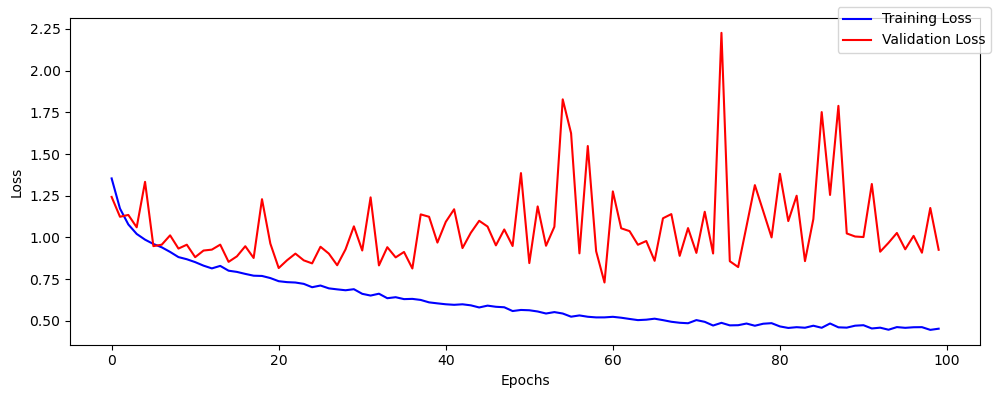

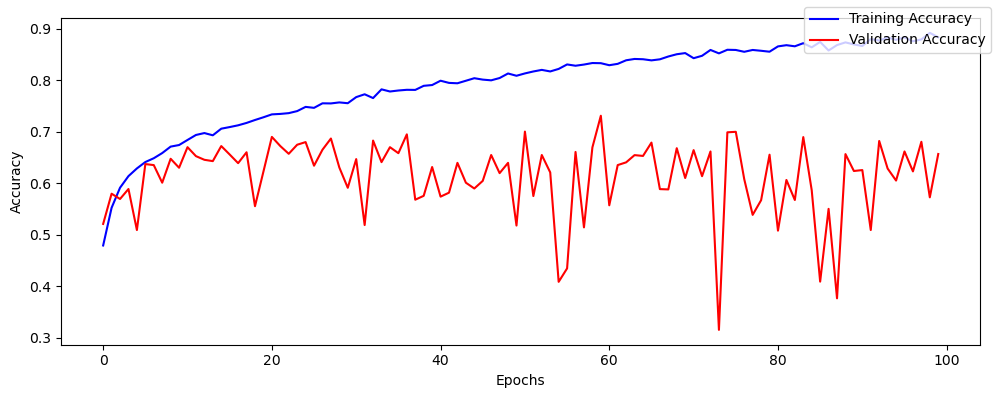

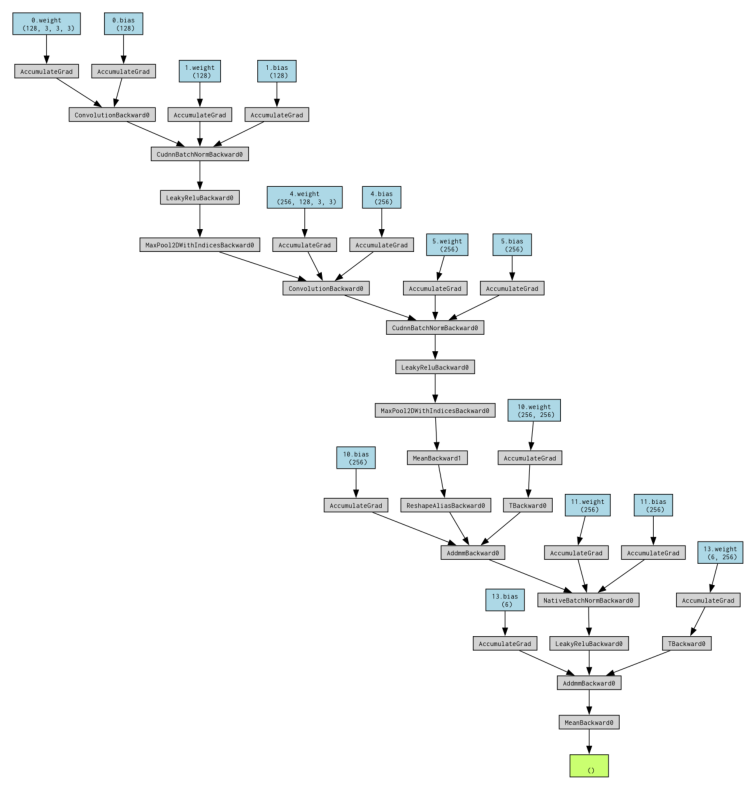

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 6]                    --
├─Conv2d: 1-1                            [1, 128, 32, 32]          3,584
├─BatchNorm2d: 1-2                       [1, 128, 32, 32]          256
├─LeakyReLU: 1-3                         [1, 128, 32, 32]          --
├─MaxPool2d: 1-4                         [1, 128, 16, 16]          --
├─Conv2d: 1-5                            [1, 256, 16, 16]          295,168
├─BatchNorm2d: 1-6                       [1, 256, 16, 16]          512
├─LeakyReLU: 1-7                         [1, 256, 16, 16]          --
├─MaxPool2d: 1-8                         [1, 256, 8, 8]            --
├─AdaptiveAvgPool2d: 1-9                 [1, 256, 1, 1]            --
├─Flatten: 1-10                          [1, 256]                  --
├─Linear: 1-11                           [1, 256]                  65,792
├─BatchNorm1d: 1-12                      [1, 256]                  512


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
m2.to(device)  # Move the model to the same device as the input data
from torchviz import make_dot
m2 = nn.Sequential(
    # Conv2d( in_channels, out_channels, kernel_size) B,3,32,32
    nn.Conv2d(3, 128, 3, stride= 1, padding=1),  nn.BatchNorm2d(128), nn.LeakyReLU(0.1) , nn.MaxPool2d(2, 2), # B,32,16,16
    nn.Conv2d(128, 256, 3, stride= 1, padding=1), nn.BatchNorm2d(256), nn.LeakyReLU(0.1), nn.MaxPool2d(2, 2), # B,32,8,8
    nn.AdaptiveAvgPool2d(1), 
    nn.Flatten(),
    nn.Linear(256, 256), nn.BatchNorm1d(256), nn.LeakyReLU(0.1),
    nn.Linear(256, 6)
)

print("--------------")


loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    m2.parameters(),
    lr=0.003,
    weight_decay=0.05,
)

model_builder = ModelBuilder(m2, loss, optimizer, print_loss_freq=1)
model_builder.set_loaders(train_loader, val_loader)

# train the model
model_builder.train(n_epochs=100)
model_builder.save_checkpoint("checkpoint1111111.pth")

# plot training results
model_builder.plot_losses()
model_builder.plot_accuracies()
plt.show()



# render and plot the model archietichure using make_dot() and summary 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_data = torch.randn(1, 3, 32, 32)  
input_data = input_data.to(device)  


output = m2(input_data)


make_dot(output.mean(), params=dict(m2.named_parameters())).render("images/cifar10_model_m2___", format="png")
img = Image.open("images/cifar10_model_m2___.png")
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")  
plt.show()


print(summary(m2, input_size=(1, 3, 32, 32)))


### 5.2.3 M2 - Bad ( 73% accuracy + class balanced)

--------------
Epoch 1, Training loss: 1.4425, accuracy: 0.4308, Validation loss: 1.3413, accuracy: 0.4581
Epoch 2, Training loss: 1.2095, accuracy: 0.5254, Validation loss: 1.4174, accuracy: 0.4331
Epoch 3, Training loss: 1.1299, accuracy: 0.5560, Validation loss: 1.2694, accuracy: 0.4955
Epoch 4, Training loss: 1.0772, accuracy: 0.5737, Validation loss: 1.4556, accuracy: 0.4379
Epoch 5, Training loss: 1.0387, accuracy: 0.5918, Validation loss: 1.0654, accuracy: 0.5761
Epoch 6, Training loss: 1.0229, accuracy: 0.5980, Validation loss: 1.1711, accuracy: 0.5510
Epoch 7, Training loss: 1.0046, accuracy: 0.6080, Validation loss: 1.0744, accuracy: 0.5789
Epoch 8, Training loss: 0.9860, accuracy: 0.6136, Validation loss: 1.0274, accuracy: 0.5965
Epoch 9, Training loss: 0.9692, accuracy: 0.6193, Validation loss: 0.9714, accuracy: 0.6270
Epoch 10, Training loss: 0.9577, accuracy: 0.6271, Validation loss: 1.1973, accuracy: 0.5508
Epoch 11, Training loss: 0.9507, accuracy: 0.6263, Validation lo

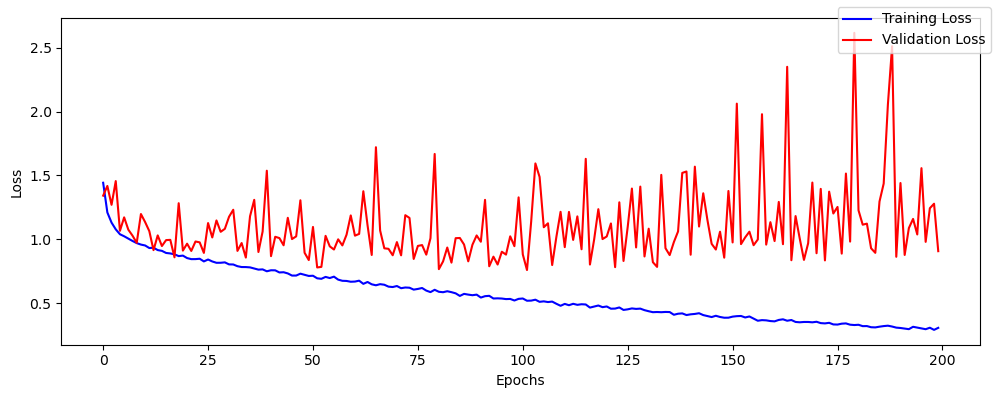

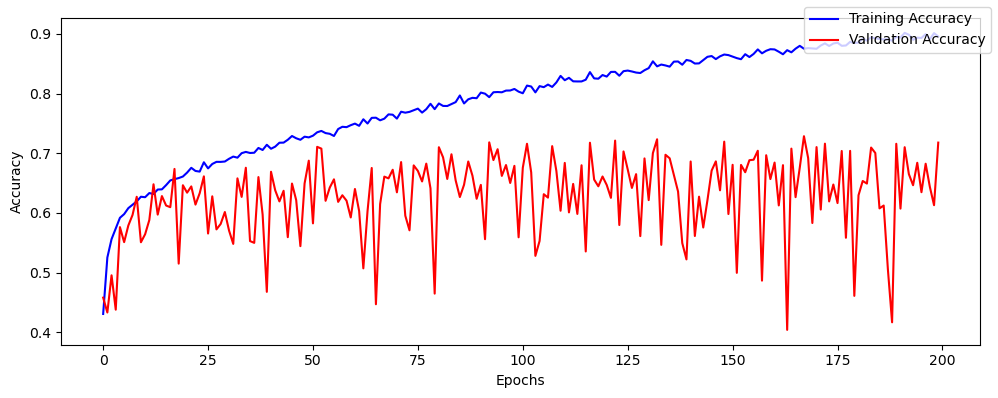

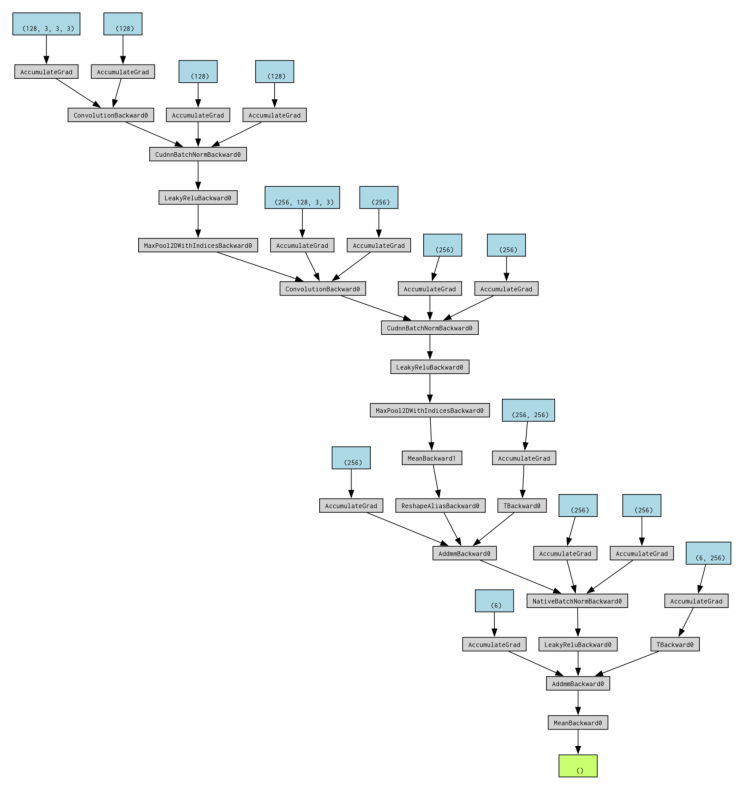

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 6]                    --
├─Conv2d: 1-1                            [1, 64, 34, 34]           1,792
├─BatchNorm2d: 1-2                       [1, 64, 34, 34]           128
├─LeakyReLU: 1-3                         [1, 64, 34, 34]           --
├─MaxPool2d: 1-4                         [1, 64, 17, 17]           --
├─Conv2d: 1-5                            [1, 64, 19, 19]           36,928
├─BatchNorm2d: 1-6                       [1, 64, 19, 19]           128
├─LeakyReLU: 1-7                         [1, 64, 19, 19]           --
├─MaxPool2d: 1-8                         [1, 64, 9, 9]             --
├─AdaptiveAvgPool2d: 1-9                 [1, 64, 1, 1]             --
├─Flatten: 1-10                          [1, 64]                   --
├─Linear: 1-11                           [1, 128]                  8,320
├─LeakyReLU: 1-12                        [1, 128]                  --
├─L

In [22]:


m2 =  nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=3, padding=2),
    nn.BatchNorm2d(64), 
    nn.LeakyReLU(0.1),
    nn.MaxPool2d(2, 2),
    
    
    nn.Conv2d(64, 64, kernel_size=3, padding=2),  
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.1),
    nn.MaxPool2d(2, 2),
    nn.AdaptiveAvgPool2d(1),
    
    nn.Flatten(),
    
    nn.Linear(64, 128),  
    nn.LeakyReLU(0.1),
    nn.Linear(128,6) )


print("--------------")


loss = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    m2.parameters(),
    lr=0.0003,
    weight_decay=0.01,
)

model_builder = ModelBuilder(m2, loss, optimizer, print_loss_freq=1)
model_builder.set_loaders(train_loader, val_loader)

# train the model
model_builder.train(n_epochs=200)
model_builder.save_checkpoint("checkpoint1.pth")

# plot training results
model_builder.plot_losses()
model_builder.plot_accuracies()
plt.show()



# render and plot the model archietichure using make_dot() and summary 

#sample input/output for summary()
sample_input = torch.randn(2, 3, 32, 32).to(device) 
output = m2(sample_input)


make_dot(output.mean(), params=dict(m2.named_parameters())).render("images/cifar10_model_m2_2", format="png")
img = Image.open("images/cifar10_model_m2_2.png")
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")  
plt.show()


print(summary(m2, input_size=(1, 3, 32, 32)))


In [ ]:
m2_cont = ModelBuilder(m2, loss, optimizer, print_loss_freq=1)


m2_cont.load_checkpoint('checkpoint1.pth')
m2_cont.set_loaders(train_loader, val_loader)
m2_cont.train(n_epochs=200)
model_builder.save_checkpoint("checkpoint11.pth")

m2_cont.plot_losses()
m2_cont.plot_accuracies()
plt.show()

Epoch 1, Training loss: 0.3027, accuracy: 0.8910, Validation loss: 1.2510, accuracy: 0.6434
Epoch 2, Training loss: 0.2921, accuracy: 0.8963, Validation loss: 1.0257, accuracy: 0.6865
Epoch 3, Training loss: 0.2830, accuracy: 0.9058, Validation loss: 1.2873, accuracy: 0.6371
Epoch 4, Training loss: 0.2870, accuracy: 0.9011, Validation loss: 1.4420, accuracy: 0.6052
Epoch 5, Training loss: 0.3008, accuracy: 0.8934, Validation loss: 0.9242, accuracy: 0.7023
Epoch 6, Training loss: 0.2618, accuracy: 0.9148, Validation loss: 1.0324, accuracy: 0.6667
Epoch 7, Training loss: 0.2836, accuracy: 0.9037, Validation loss: 1.1141, accuracy: 0.6893
Epoch 8, Training loss: 0.2911, accuracy: 0.8980, Validation loss: 1.3303, accuracy: 0.6260
Epoch 9, Training loss: 0.2714, accuracy: 0.9076, Validation loss: 1.0227, accuracy: 0.6711
Epoch 10, Training loss: 0.2820, accuracy: 0.9034, Validation loss: 1.1812, accuracy: 0.6392
Epoch 11, Training loss: 0.2591, accuracy: 0.9142, Validation loss: 1.1396, acc

### 5.2.4 M2 - Bad ( 71% accuracy + class balanced)

--------------
Epoch 1, Training loss: 1.4425, accuracy: 0.4308, Validation loss: 1.3413, accuracy: 0.4581
Epoch 2, Training loss: 1.2095, accuracy: 0.5254, Validation loss: 1.4174, accuracy: 0.4331
Epoch 3, Training loss: 1.1299, accuracy: 0.5560, Validation loss: 1.2694, accuracy: 0.4955
Epoch 4, Training loss: 1.0772, accuracy: 0.5737, Validation loss: 1.4556, accuracy: 0.4379
Epoch 5, Training loss: 1.0387, accuracy: 0.5918, Validation loss: 1.0654, accuracy: 0.5761
Epoch 6, Training loss: 1.0229, accuracy: 0.5980, Validation loss: 1.1711, accuracy: 0.5510
Epoch 7, Training loss: 1.0046, accuracy: 0.6080, Validation loss: 1.0744, accuracy: 0.5789
Epoch 8, Training loss: 0.9860, accuracy: 0.6136, Validation loss: 1.0274, accuracy: 0.5965
Epoch 9, Training loss: 0.9692, accuracy: 0.6193, Validation loss: 0.9714, accuracy: 0.6270
Epoch 10, Training loss: 0.9577, accuracy: 0.6271, Validation loss: 1.1973, accuracy: 0.5508
Epoch 11, Training loss: 0.9507, accuracy: 0.6263, Validation lo

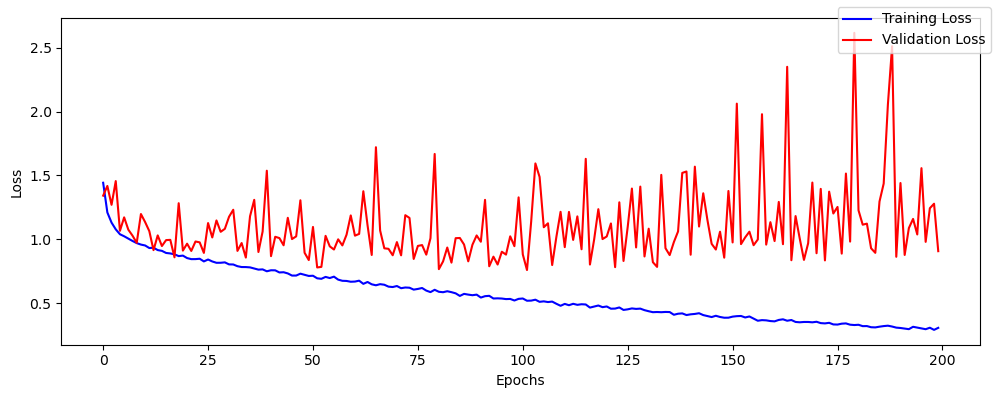

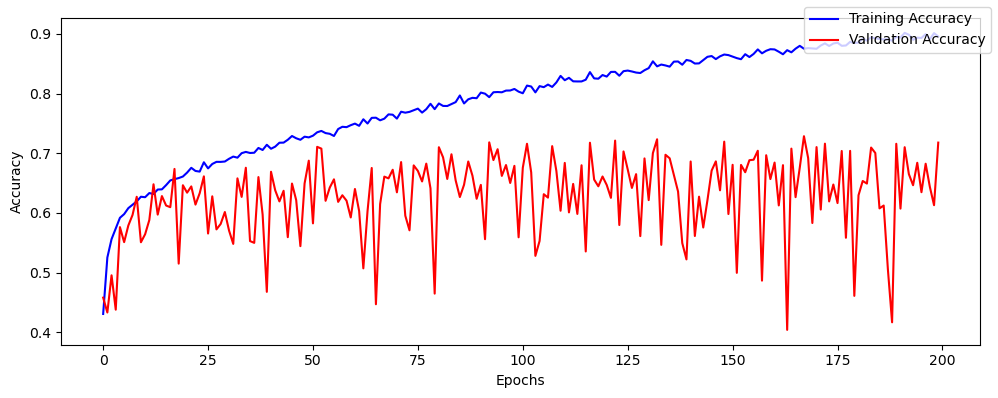

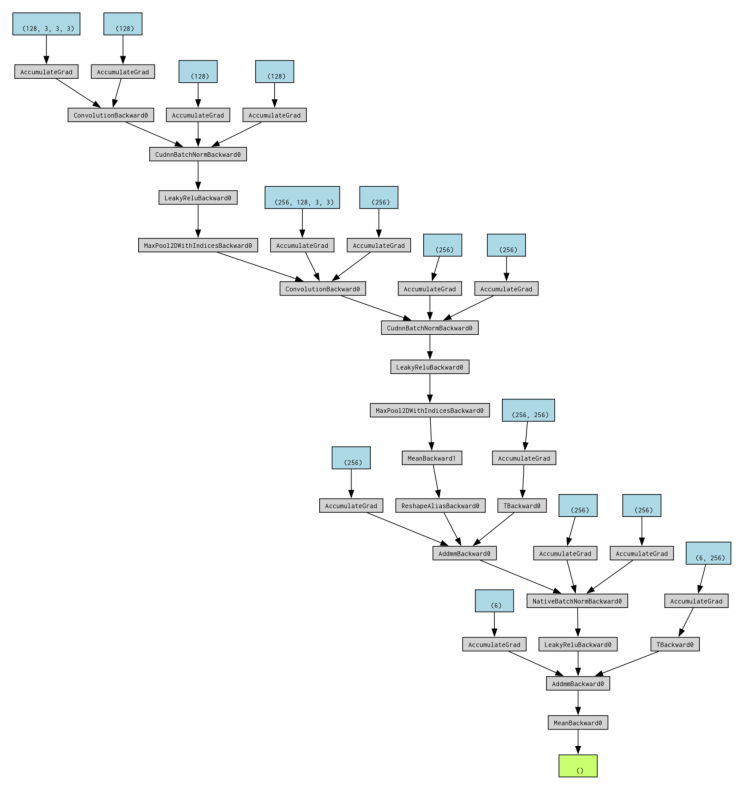

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 6]                    --
├─Conv2d: 1-1                            [1, 64, 34, 34]           1,792
├─BatchNorm2d: 1-2                       [1, 64, 34, 34]           128
├─LeakyReLU: 1-3                         [1, 64, 34, 34]           --
├─MaxPool2d: 1-4                         [1, 64, 17, 17]           --
├─Conv2d: 1-5                            [1, 64, 19, 19]           36,928
├─BatchNorm2d: 1-6                       [1, 64, 19, 19]           128
├─LeakyReLU: 1-7                         [1, 64, 19, 19]           --
├─MaxPool2d: 1-8                         [1, 64, 9, 9]             --
├─AdaptiveAvgPool2d: 1-9                 [1, 64, 1, 1]             --
├─Flatten: 1-10                          [1, 64]                   --
├─Linear: 1-11                           [1, 128]                  8,320
├─LeakyReLU: 1-12                        [1, 128]                  --
├─L

In [22]:

m2 =  nn.Sequential(

    nn.Conv2d(3, 64, kernel_size=3, padding=2),
    nn.BatchNorm2d(64), 
    nn.LeakyReLU(0.1),
    nn.MaxPool2d(2, 2),
    
    
    nn.Conv2d(64, 64, kernel_size=3, padding=2),  
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.1),
    nn.MaxPool2d(2, 2),
    nn.AdaptiveAvgPool2d(1),
    
    nn.Flatten(),
    
    
    nn.Linear(64, 128),  
    nn.LeakyReLU(0.1),
    nn.Linear(128,6) )

print("--------------")


loss = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    m2.parameters(),
    lr=0.0003,
    weight_decay=0.01,
)

model_builder = ModelBuilder(m2, loss, optimizer, print_loss_freq=1)
model_builder.set_loaders(train_loader, val_loader)

# train the model
model_builder.train(n_epochs=200)
model_builder.save_checkpoint("checkpoint1.pth")

# plot training results
model_builder.plot_losses()
model_builder.plot_accuracies()
plt.show()


#sample input/output for summary()
sample_input = torch.randn(2, 3, 32, 32).to(device) 
output = m2(sample_input)


# render and plot the model archietichure using make_dot() and summary 


make_dot(output.mean(), params=dict(m2.named_parameters())).render("images/cifar10_model_m2_2", format="png")
img = Image.open("images/cifar10_model_m2_2.png")
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")  
plt.show()


print(summary(m2, input_size=(1, 3, 32, 32)))


Epoch 1, Training loss: 0.3027, accuracy: 0.8910, Validation loss: 1.2510, accuracy: 0.6434
Epoch 2, Training loss: 0.2921, accuracy: 0.8963, Validation loss: 1.0257, accuracy: 0.6865
Epoch 3, Training loss: 0.2830, accuracy: 0.9058, Validation loss: 1.2873, accuracy: 0.6371
Epoch 4, Training loss: 0.2870, accuracy: 0.9011, Validation loss: 1.4420, accuracy: 0.6052
Epoch 5, Training loss: 0.3008, accuracy: 0.8934, Validation loss: 0.9242, accuracy: 0.7023
Epoch 6, Training loss: 0.2618, accuracy: 0.9148, Validation loss: 1.0324, accuracy: 0.6667
Epoch 7, Training loss: 0.2836, accuracy: 0.9037, Validation loss: 1.1141, accuracy: 0.6893
Epoch 8, Training loss: 0.2911, accuracy: 0.8980, Validation loss: 1.3303, accuracy: 0.6260
Epoch 9, Training loss: 0.2714, accuracy: 0.9076, Validation loss: 1.0227, accuracy: 0.6711
Epoch 10, Training loss: 0.2820, accuracy: 0.9034, Validation loss: 1.1812, accuracy: 0.6392
Epoch 11, Training loss: 0.2591, accuracy: 0.9142, Validation loss: 1.1396, acc

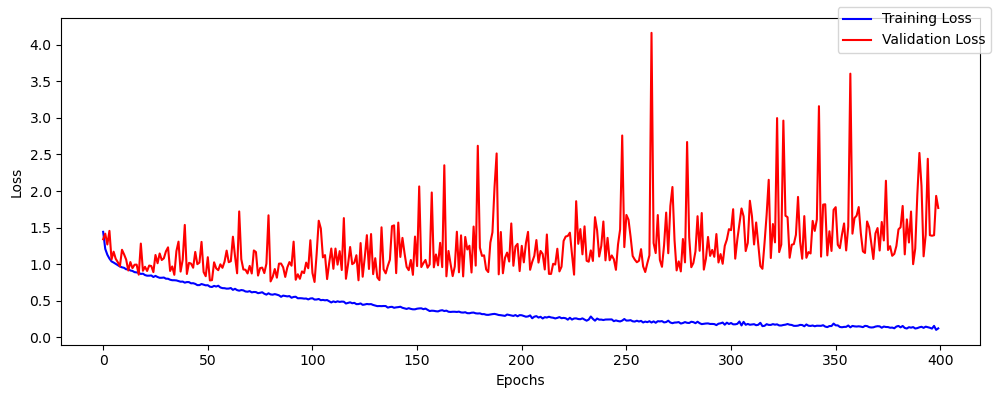

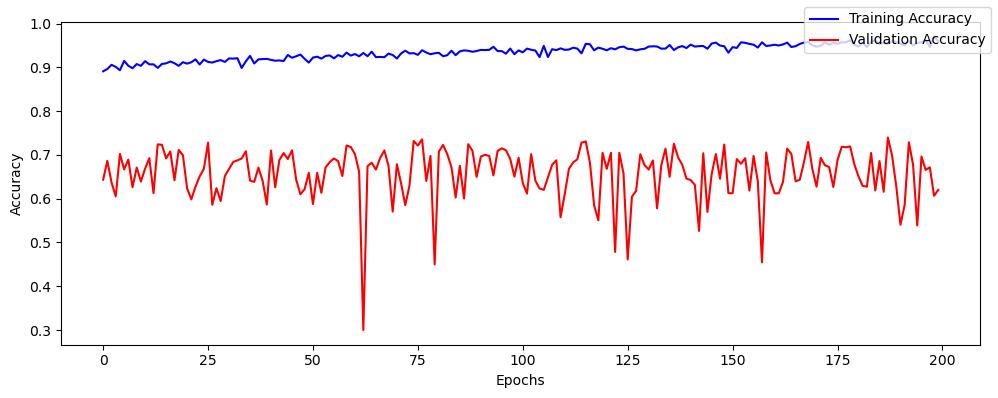

In [23]:
m2_cont = ModelBuilder(m2, loss, optimizer, print_loss_freq=1)


m2_cont.load_checkpoint('checkpoint1.pth')
m2_cont.set_loaders(train_loader, val_loader)
m2_cont.train(n_epochs=200)
model_builder.save_checkpoint("checkpoint11.pth")

m2_cont.plot_losses()
m2_cont.plot_accuracies()
plt.show()

### 5.2.5 M2 - Bad ( 70% accuracy + class balanced)

Epoch 1, Training loss: 1.3456, accuracy: 0.4492, Validation loss: 1.3756, accuracy: 0.4640
Epoch 2, Training loss: 1.1954, accuracy: 0.5193, Validation loss: 1.9379, accuracy: 0.3730
Epoch 3, Training loss: 1.1145, accuracy: 0.5554, Validation loss: 1.3740, accuracy: 0.4846
Epoch 4, Training loss: 1.0703, accuracy: 0.5772, Validation loss: 1.0745, accuracy: 0.5736
Epoch 5, Training loss: 1.0325, accuracy: 0.5982, Validation loss: 1.1397, accuracy: 0.5455
Epoch 6, Training loss: 1.0094, accuracy: 0.6119, Validation loss: 1.5819, accuracy: 0.4504
Epoch 10, Training loss: 0.9147, accuracy: 0.6438, Validation loss: 1.1604, accuracy: 0.5633
Epoch 11, Training loss: 0.8872, accuracy: 0.6600, Validation loss: 0.9547, accuracy: 0.6452
Epoch 12, Training loss: 0.8769, accuracy: 0.6565, Validation loss: 1.0241, accuracy: 0.6159
Epoch 13, Training loss: 0.8416, accuracy: 0.6721, Validation loss: 1.4880, accuracy: 0.4974
Epoch 14, Training loss: 0.8391, accuracy: 0.6768, Validation loss: 1.0395, 

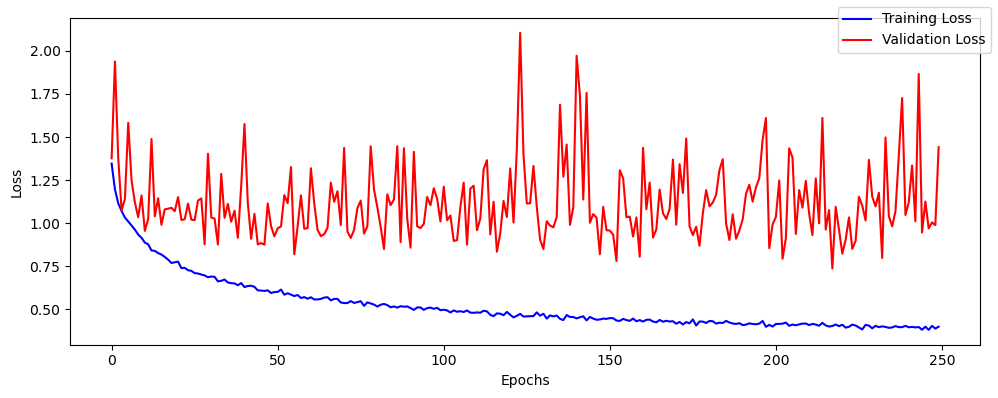

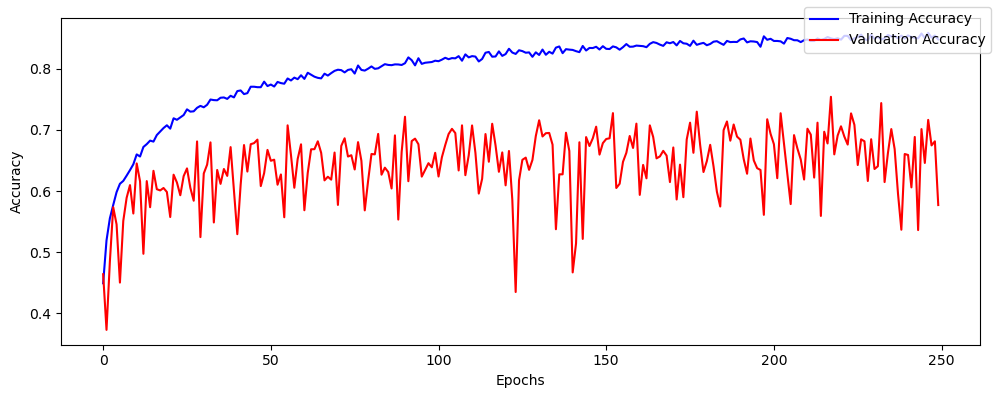

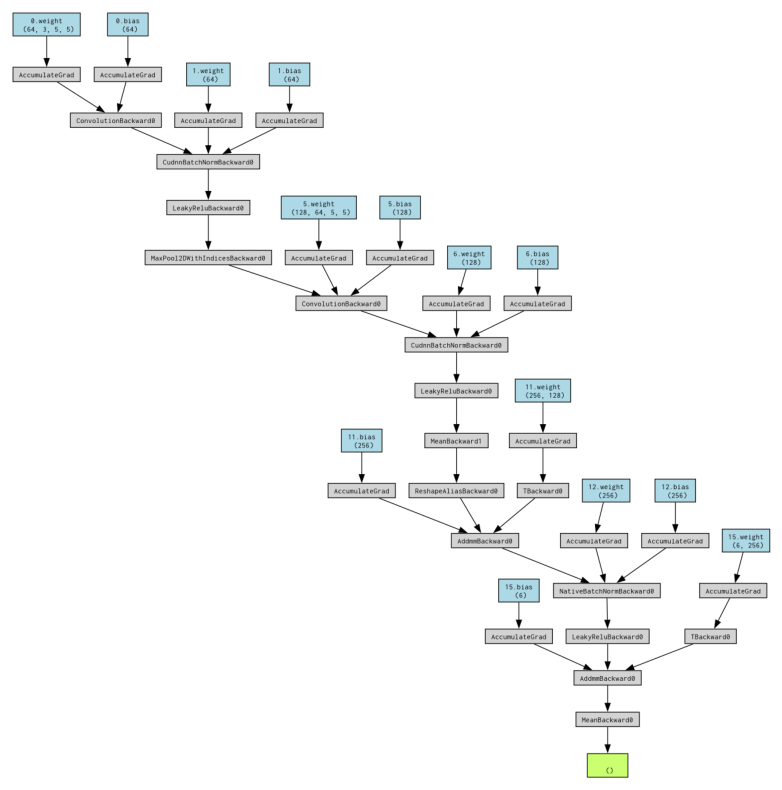

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: [Conv2d: 1]

In [18]:

m2_op = nn.Sequential(
           
            nn.Conv2d(3, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.Dropout(0.3),    
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),
            
            # 2nd convolutional block
            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),           
            nn.Dropout(0.3),
            nn.LeakyReLU(0.1),
            nn.AdaptiveAvgPool2d((1, 1)),
            
            nn.Flatten(),

            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3), 
            nn.LeakyReLU(0.1),
            nn.Linear(256, 6)  
        )




loss = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    m2_op.parameters(),
    lr=0.0027,
    weight_decay=0.005,
)

model_builder = ModelBuilder(m2_op, loss, optimizer, print_loss_freq=1)
model_builder.set_loaders(train_loader, val_loader)

model_builder.train(n_epochs=250)
model_builder.save_checkpoint("checkpoint6")

# plot  results
model_builder.plot_losses()
model_builder.plot_accuracies()
plt.show()



# render and plot the model archietichure using make_dot() and summary 
sample_input = torch.randn(2, 3, 32, 32).to(device)   
output = m2_op(sample_input)

make_dot(output.mean(), params=dict(m2_op.named_parameters())).render("images/cifar10_model_m2_op", format="png")
img = Image.open("images/cifar10_model_m2_op.png")
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")  
plt.show()


print(summary(m2_op, input_size=(3, 32, 32)))  


### 5.2.6 M2 - Bad ( 73 % accuracy + class balanced)

--------------
Epoch 1, Training loss: 1.7899, accuracy: 0.1670, Validation loss: 1.7692, accuracy: 0.1062
Epoch 2, Training loss: 1.7767, accuracy: 0.1672, Validation loss: 1.7561, accuracy: 0.1244
Epoch 3, Training loss: 1.7626, accuracy: 0.1986, Validation loss: 1.7446, accuracy: 0.1760
Epoch 4, Training loss: 1.7505, accuracy: 0.2473, Validation loss: 1.7335, accuracy: 0.2364
Epoch 5, Training loss: 1.7420, accuracy: 0.2742, Validation loss: 1.7238, accuracy: 0.2854
Epoch 6, Training loss: 1.7305, accuracy: 0.3093, Validation loss: 1.7146, accuracy: 0.3232
Epoch 7, Training loss: 1.7195, accuracy: 0.3317, Validation loss: 1.7042, accuracy: 0.3347
Epoch 8, Training loss: 1.7083, accuracy: 0.3490, Validation loss: 1.6945, accuracy: 0.3459
Epoch 9, Training loss: 1.6985, accuracy: 0.3552, Validation loss: 1.6852, accuracy: 0.3495
Epoch 10, Training loss: 1.6888, accuracy: 0.3595, Validation loss: 1.6746, accuracy: 0.3525
Epoch 11, Training loss: 1.6790, accuracy: 0.3695, Validation lo

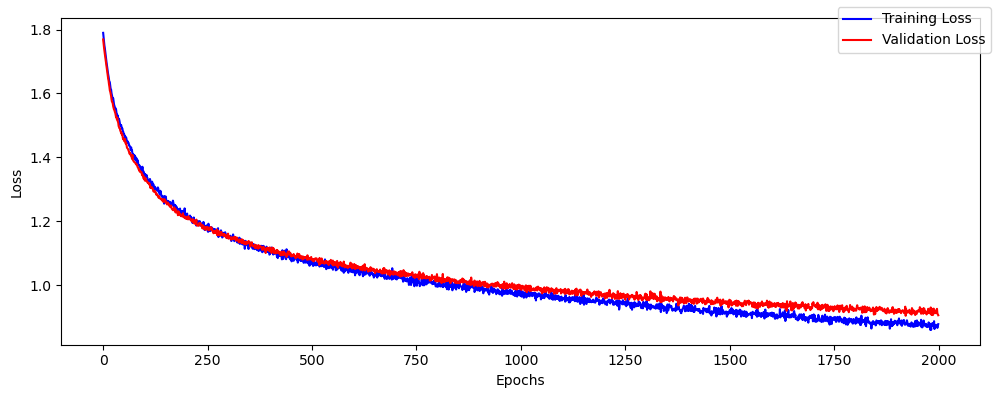

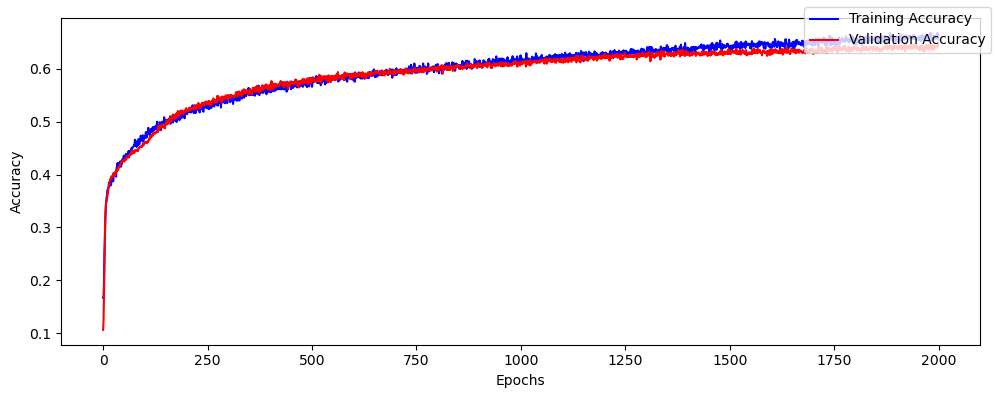

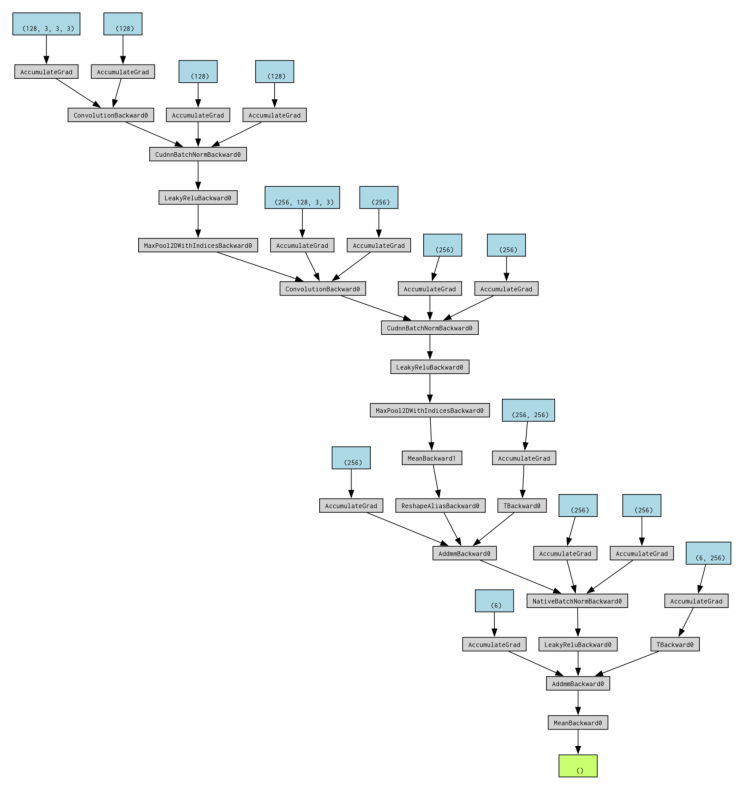

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 6]                    --
├─Conv2d: 1-1                            [1, 32, 34, 34]           896
├─BatchNorm2d: 1-2                       [1, 32, 34, 34]           64
├─LeakyReLU: 1-3                         [1, 32, 34, 34]           --
├─MaxPool2d: 1-4                         [1, 32, 17, 17]           --
├─Conv2d: 1-5                            [1, 32, 19, 19]           9,248
├─BatchNorm2d: 1-6                       [1, 32, 19, 19]           64
├─LeakyReLU: 1-7                         [1, 32, 19, 19]           --
├─MaxPool2d: 1-8                         [1, 32, 9, 9]             --
├─AdaptiveAvgPool2d: 1-9                 [1, 32, 1, 1]             --
├─Flatten: 1-10                          [1, 32]                   --
├─Linear: 1-11                           [1, 128]                  4,224
├─LeakyReLU: 1-12                        [1, 128]                  --
├─Linear

In [26]:
m2 =  nn.Sequential(
    
    nn.Conv2d(3, 32, kernel_size=3, padding=2),
    nn.BatchNorm2d(32), 
    nn.LeakyReLU(0.1),
    nn.MaxPool2d(2, 2),

    nn.Conv2d(32, 32, kernel_size=3, padding=2), 
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.1),
    nn.MaxPool2d(2, 2),
    nn.AdaptiveAvgPool2d(1),
    
    nn.Flatten(),
    
    
    nn.Linear(32, 128),  
    nn.LeakyReLU(0.1),
    nn.Linear(128,6) )


print("--------------")


loss = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    m2.parameters(),
    lr=0.000003,
    weight_decay=0.01,
)

 
model_builder = ModelBuilder(m2, loss, optimizer, print_loss_freq=1)
model_builder.set_loaders(train_loader, val_loader)

# train the model
model_builder.train(n_epochs=2000)
model_builder.save_checkpoint("checkpoint1.pth")

# plot training results
model_builder.plot_losses()
model_builder.plot_accuracies()
plt.show()



# render and plot the model archietichure using make_dot() and summary 


make_dot(output.mean(), params=dict(m2.named_parameters())).render("images/cifar10_model_m2_2", format="png")
img = Image.open("images/cifar10_model_m2_2.png")
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")  
plt.show()


print(summary(m2, input_size=(1, 3, 32, 32)))


### 5.2.7 M2 - Bad ( 73% accuracy + class balanced + StepLR scheduler )

--------------
Epoch 1/100
Epoch 1, Training loss: 1.5289, accuracy: 0.3870, Validation loss: 1.3934, accuracy: 0.4227
Epoch 2/100
Epoch 1, Training loss: 1.2635, accuracy: 0.5117, Validation loss: 1.2013, accuracy: 0.5431
Epoch 3/100
Epoch 1, Training loss: 1.1605, accuracy: 0.5524, Validation loss: 1.1053, accuracy: 0.5882
Epoch 4/100
Epoch 1, Training loss: 1.1107, accuracy: 0.5666, Validation loss: 1.1083, accuracy: 0.5623
Epoch 5/100
Epoch 1, Training loss: 1.0494, accuracy: 0.5914, Validation loss: 1.0422, accuracy: 0.5955
Epoch 6/100
Epoch 1, Training loss: 1.0067, accuracy: 0.6115, Validation loss: 1.0171, accuracy: 0.6038
Epoch 7/100
Epoch 1, Training loss: 0.9706, accuracy: 0.6220, Validation loss: 1.0049, accuracy: 0.6084
Epoch 8/100
Epoch 1, Training loss: 0.9252, accuracy: 0.6411, Validation loss: 1.0095, accuracy: 0.6025
Epoch 9/100
Epoch 1, Training loss: 0.9100, accuracy: 0.6517, Validation loss: 0.9591, accuracy: 0.6236
Epoch 10/100
Epoch 1, Training loss: 0.8967, accu

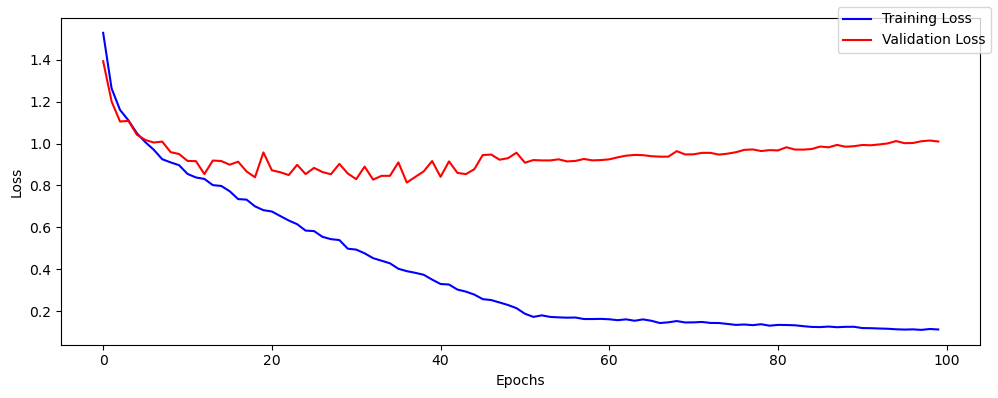

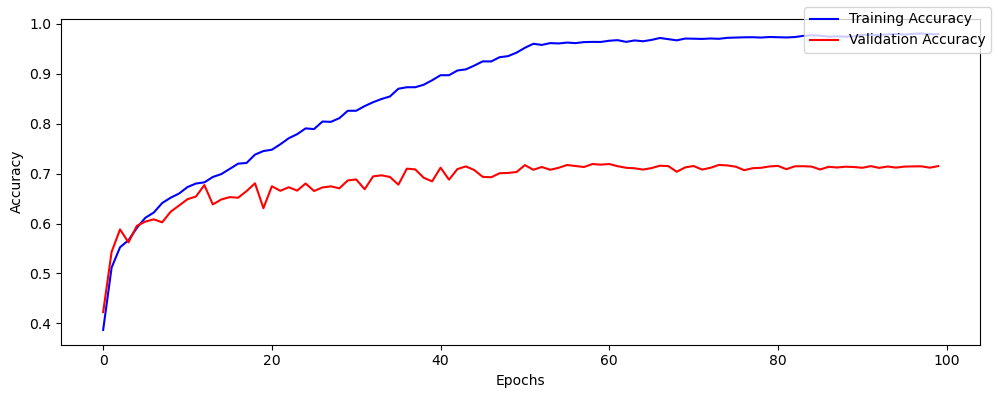

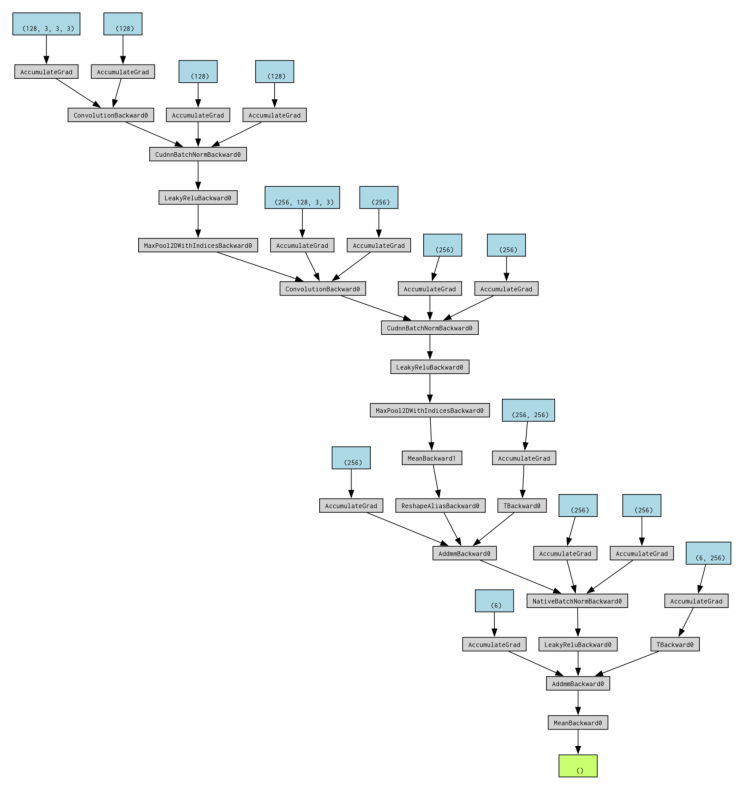

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 64, 32, 32]           1,792
├─LeakyReLU: 1-2                         [1, 64, 32, 32]           --
├─MaxPool2d: 1-3                         [1, 64, 16, 16]           --
├─Conv2d: 1-4                            [1, 64, 16, 16]           36,928
├─LeakyReLU: 1-5                         [1, 64, 16, 16]           --
├─MaxPool2d: 1-6                         [1, 64, 8, 8]             --
├─Flatten: 1-7                           [1, 4096]                 --
├─Linear: 1-8                            [1, 512]                  2,097,664
├─LeakyReLU: 1-9                         [1, 512]                  --
├─Linear: 1-10                           [1, 10]                   5,130
Total params: 2,141,514
Trainable params: 2,141,514
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 13.39
Input size (MB): 0.01

In [45]:

m2o =  nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=3, padding=1), 
    #nn.BatchNorm2d(64),  
    nn.LeakyReLU(),  
    nn.MaxPool2d(2, 2), 

    nn.Conv2d(64, 64, kernel_size=3, padding=1),  
    #nn.BatchNorm2d(64),
    nn.LeakyReLU(), 
    nn.MaxPool2d(2, 2),

    nn.Flatten(),
    nn.Linear(64 * 8 * 8, 512),  
    nn.LeakyReLU(),
    nn.Linear(512, 10)  
)

print("--------------")



optimizer = optim.AdamW(
    m2o.parameters(),
    lr=0.0001,  
    weight_decay=0.01,
)


scheduler = StepLR(optimizer, step_size=50, gamma=0.1)  # Reduce LR every 50 epochs by factor of 0.1


model_buildero = ModelBuilder(m2o, loss, optimizer, print_loss_freq=1)
model_buildero.set_loaders(train_loader, val_loader)


for epoch in range(100):  
    print(f"Epoch {epoch + 1}/{100}")
    model_buildero.train(n_epochs=1)  
    scheduler.step() 

# plot results
model_buildero.save_checkpoint("checkpoint112.pth")
model_buildero.plot_losses()
model_buildero.plot_accuracies()
plt.show()





#sample input/output for summary()

sample_input = torch.randn(2, 3, 32, 32).to(device) 
output = m2o(sample_input)


# render and plot the model archietichure using make_dot() and summary 
make_dot(output.mean(), params=dict(m2o.named_parameters())).render("cifar10_model_m2_2_2o", format="png")
img = Image.open("cifar10_model_m2_2_2o.png")
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")  
plt.show()


print(summary(m2o, input_size=(1, 3, 32, 32)))


### 5.2.8  M2 - Okay ( 73% accuracy + class balanced + StepLR $ cosine annealer scheduler )

--------------
Epoch 1/100
Epoch 1, Training loss: 1.3478, accuracy: 0.4978, Validation loss: 1.1776, accuracy: 0.5481
Epoch 2/100
Epoch 1, Training loss: 1.0518, accuracy: 0.6076, Validation loss: 0.9939, accuracy: 0.6242
Epoch 3/100
Epoch 1, Training loss: 0.9409, accuracy: 0.6475, Validation loss: 0.9494, accuracy: 0.6329
Epoch 4/100
Epoch 1, Training loss: 0.8764, accuracy: 0.6732, Validation loss: 0.9152, accuracy: 0.6493
Epoch 5/100
Epoch 1, Training loss: 0.8098, accuracy: 0.7043, Validation loss: 0.9038, accuracy: 0.6485
Epoch 6/100
Epoch 1, Training loss: 0.7791, accuracy: 0.7149, Validation loss: 0.8226, accuracy: 0.6877
Epoch 7/100
Epoch 1, Training loss: 0.7231, accuracy: 0.7404, Validation loss: 0.8406, accuracy: 0.6750
Epoch 8/100
Epoch 1, Training loss: 0.7040, accuracy: 0.7479, Validation loss: 0.8501, accuracy: 0.6723
Epoch 9/100
Epoch 1, Training loss: 0.6742, accuracy: 0.7590, Validation loss: 0.8102, accuracy: 0.6932
Epoch 10/100
Epoch 1, Training loss: 0.6346, accu

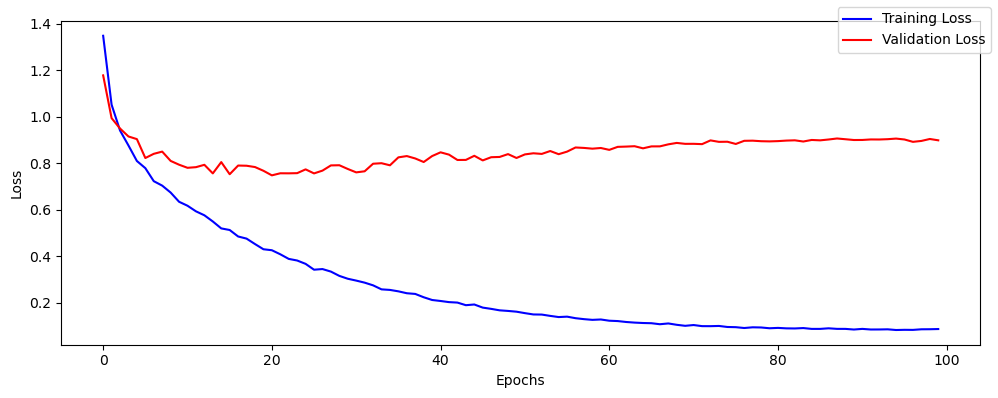

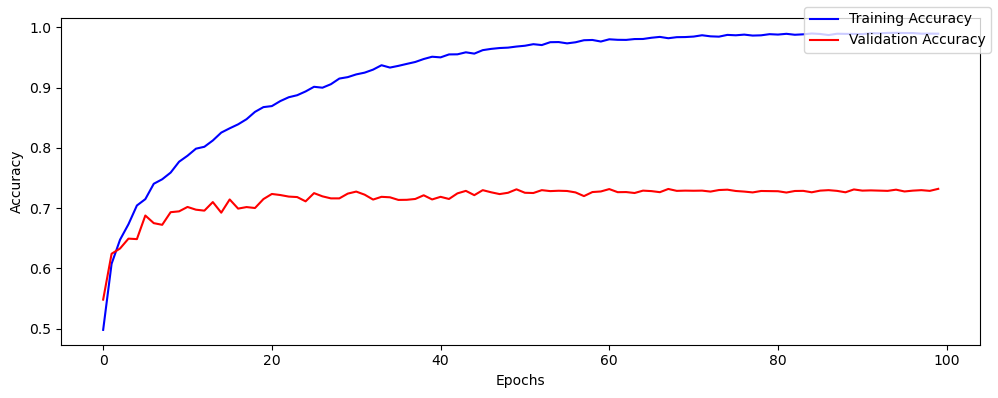

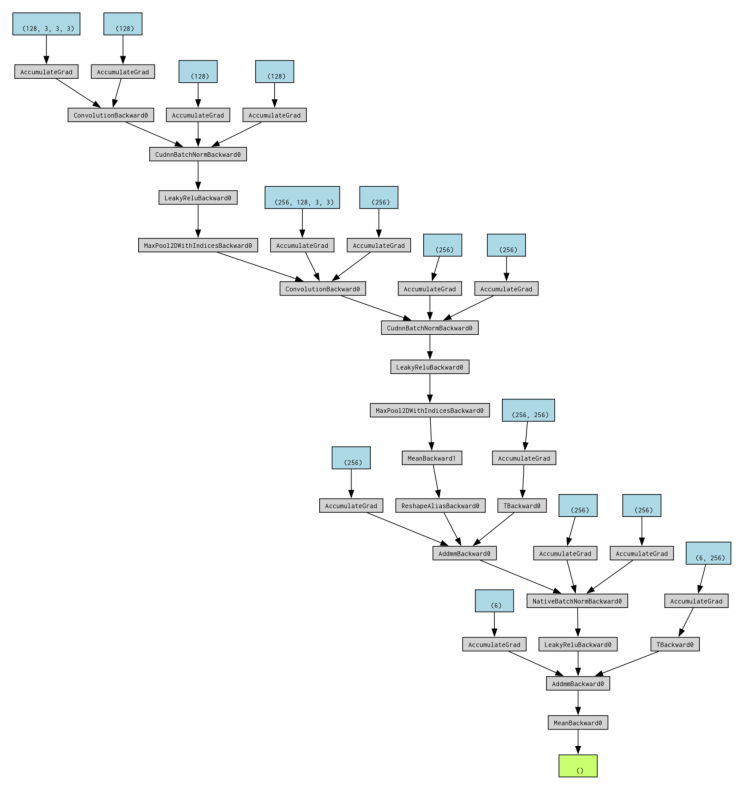

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 64, 32, 32]           1,792
├─BatchNorm2d: 1-2                       [1, 64, 32, 32]           128
├─LeakyReLU: 1-3                         [1, 64, 32, 32]           --
├─MaxPool2d: 1-4                         [1, 64, 16, 16]           --
├─Conv2d: 1-5                            [1, 64, 16, 16]           36,928
├─BatchNorm2d: 1-6                       [1, 64, 16, 16]           128
├─LeakyReLU: 1-7                         [1, 64, 16, 16]           --
├─MaxPool2d: 1-8                         [1, 64, 8, 8]             --
├─Flatten: 1-9                           [1, 4096]                 --
├─Linear: 1-10                           [1, 256]                  1,048,832
├─LeakyReLU: 1-11                        [1, 256]                  --
├─Linear: 1-12                           [1, 10]                   2,

In [55]:
m2o =  nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(),  
    nn.MaxPool2d(2, 2),  

    nn.Conv2d(64, 64, kernel_size=3, padding=1),  
    nn.BatchNorm2d(64), 
    nn.LeakyReLU(),  
    nn.MaxPool2d(2, 2),  

    nn.Flatten(),
    nn.Linear(64 * 8 * 8, 256),
    nn.LeakyReLU(),
    nn.Linear(256, 10)  

)

print("--------------")



optimizer = optim.AdamW(
    m2o.parameters(),
    lr=0.00003,  
    weight_decay=0.1,
)
loss = nn.CrossEntropyLoss()

scheduler = CosineAnnealingLR(optimizer, T_max=100)  


model_buildero = ModelBuilder(m2o, loss, optimizer, print_loss_freq=1)
model_buildero.set_loaders(train_loader, val_loader)


for epoch in range(100):  
    print(f"Epoch {epoch + 1}/{100}")
    model_buildero.train(n_epochs=1)  
    scheduler.step() 

# plot results
model_buildero.save_checkpoint("checkpoint112.pth")
model_buildero.plot_losses()
model_buildero.plot_accuracies()
plt.show()



#sample input/output for summary()
sample_input = torch.randn(2, 3, 32, 32).to(device) 
output = m2o(sample_input)


# render and plot the model archietichure using make_dot() and summary 
make_dot(output.mean(), params=dict(m2o.named_parameters())).render("images/cifar10_model_m2_2_2o", format="png")
img = Image.open("images/cifar10_model_m2_2_2o.png")
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")  
plt.show()


print(summary(m2o, input_size=(1, 3, 32, 32)))


### 5.2.9 M2 - Bad ( 72% accuracy + class balanced + cosine annealer warm scheduler )

In [ ]:
m2o =  nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=3, padding=1), 
    nn.BatchNorm2d(64),  
    nn.LeakyReLU(),  
    nn.MaxPool2d(2, 2), 

    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64), 
    nn.LeakyReLU(),  
    nn.MaxPool2d(2, 2), 

    nn.Flatten(),
    nn.Linear(64 * 8 * 8, 256),
    nn.LeakyReLU(),
    nn.Linear(256, 10)     

)


print("--------------")

loss = nn.CrossEntropyLoss()

optimizer = optim.AdamW(
    m2o.parameters(),
    lr=0.00003,  
    weight_decay=0.001,
)

scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2) 


model_buildero = ModelBuilder(m2o, loss, optimizer, print_loss_freq=1)
model_buildero.set_loaders(train_loader, val_loader)


for epoch in range(100):  
    print(f"Epoch {epoch + 1}/{100}")
    model_buildero.train(n_epochs=1)  
    scheduler.step()  

# plot results
model_buildero.save_checkpoint("checkpoint112.pth")
model_buildero.plot_losses()
model_buildero.plot_accuracies()
plt.show()





#sample input/output for summary()
sample_input = torch.randn(2, 3, 32, 32).to(device) 
output = m2o(sample_input)


# render and plot the model archietichure using make_dot() and summary 
make_dot(output.mean(), params=dict(m2o.named_parameters())).render("images/cifar10_model_m2_2_2o", format="png")
img = Image.open("images/cifar10_model_m2_2_2o.png")
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")  
plt.show()


print(summary(m2o, input_size=(1, 3, 32, 32)))


--------------
Epoch 1/100
Epoch 1, Training loss: 1.3470, accuracy: 0.4975, Validation loss: 1.1115, accuracy: 0.5801
Epoch 2/100
Epoch 1, Training loss: 1.0441, accuracy: 0.6059, Validation loss: 1.0203, accuracy: 0.6064
Epoch 3/100
Epoch 1, Training loss: 0.9405, accuracy: 0.6516, Validation loss: 0.9439, accuracy: 0.6369
Epoch 4/100
Epoch 1, Training loss: 0.8914, accuracy: 0.6663, Validation loss: 0.9664, accuracy: 0.6214
Epoch 5/100
Epoch 1, Training loss: 0.8404, accuracy: 0.6904, Validation loss: 0.9490, accuracy: 0.6297
Epoch 6/100
Epoch 1, Training loss: 0.8085, accuracy: 0.7017, Validation loss: 0.8949, accuracy: 0.6551
Epoch 7/100
Epoch 1, Training loss: 0.7849, accuracy: 0.7142, Validation loss: 0.8996, accuracy: 0.6559
Epoch 8/100
Epoch 1, Training loss: 0.7851, accuracy: 0.7148, Validation loss: 0.8631, accuracy: 0.6762
Epoch 9/100
Epoch 1, Training loss: 0.7629, accuracy: 0.7235, Validation loss: 0.8745, accuracy: 0.6652
Epoch 10/100
Epoch 1, Training loss: 0.7619, accu

### 5.2.10 M2 - Okay ( 73% accuracy + class balanced + cyclicLR scheduler )

--------------
Epoch 1/100
Epoch 1, Training loss: 2.2497, accuracy: 0.1586, Validation loss: 2.1911, accuracy: 0.2312
Epoch 2/100
Epoch 1, Training loss: 1.6830, accuracy: 0.3725, Validation loss: 1.4835, accuracy: 0.4341
Epoch 3/100
Epoch 1, Training loss: 1.3555, accuracy: 0.4923, Validation loss: 1.2339, accuracy: 0.5409
Epoch 4/100
Epoch 1, Training loss: 1.1877, accuracy: 0.5538, Validation loss: 1.1876, accuracy: 0.5318
Epoch 5/100
Epoch 1, Training loss: 1.0728, accuracy: 0.5924, Validation loss: 1.0972, accuracy: 0.5783
Epoch 6/100
Epoch 1, Training loss: 0.9929, accuracy: 0.6179, Validation loss: 0.9570, accuracy: 0.6254
Epoch 7/100
Epoch 1, Training loss: 0.9180, accuracy: 0.6499, Validation loss: 1.0445, accuracy: 0.5922
Epoch 8/100
Epoch 1, Training loss: 0.8752, accuracy: 0.6709, Validation loss: 0.9081, accuracy: 0.6434
Epoch 9/100
Epoch 1, Training loss: 0.8349, accuracy: 0.6857, Validation loss: 0.8727, accuracy: 0.6646
Epoch 10/100
Epoch 1, Training loss: 0.7783, accu

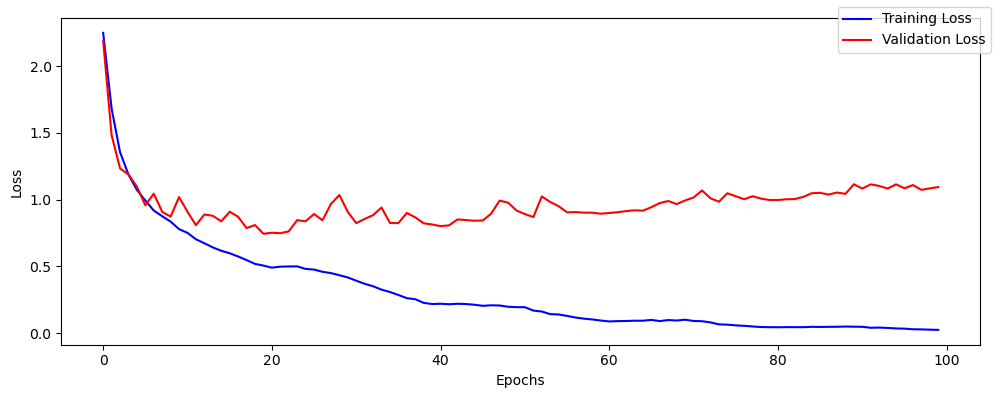

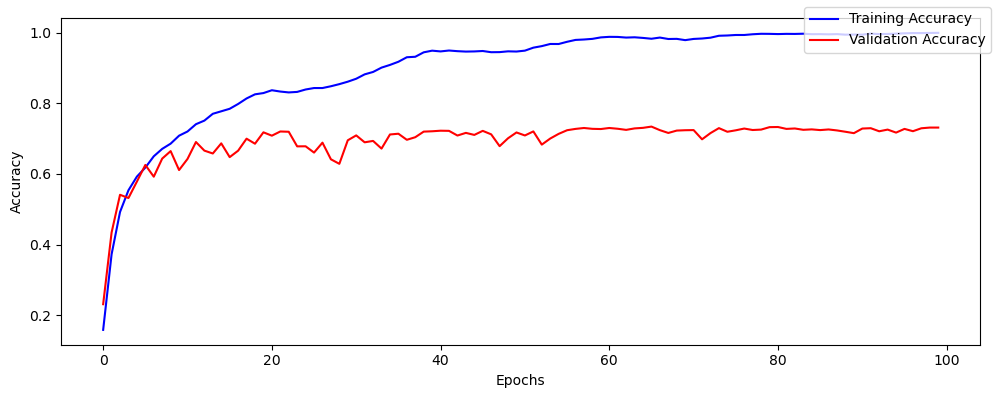

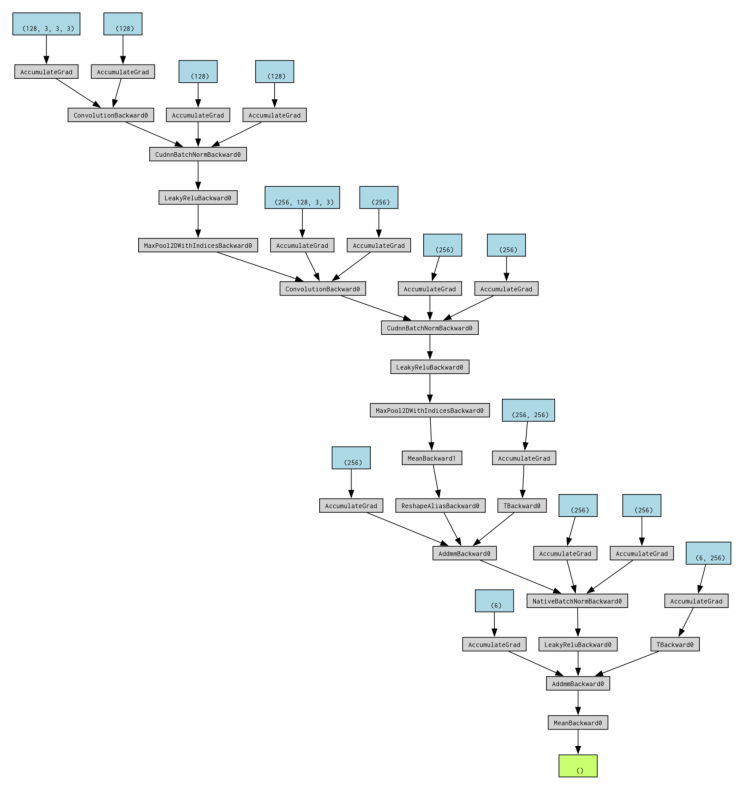

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 64, 32, 32]           1,792
├─BatchNorm2d: 1-2                       [1, 64, 32, 32]           128
├─LeakyReLU: 1-3                         [1, 64, 32, 32]           --
├─MaxPool2d: 1-4                         [1, 64, 16, 16]           --
├─Conv2d: 1-5                            [1, 64, 16, 16]           36,928
├─BatchNorm2d: 1-6                       [1, 64, 16, 16]           128
├─LeakyReLU: 1-7                         [1, 64, 16, 16]           --
├─MaxPool2d: 1-8                         [1, 64, 8, 8]             --
├─Flatten: 1-9                           [1, 4096]                 --
├─Linear: 1-10                           [1, 256]                  1,048,832
├─LeakyReLU: 1-11                        [1, 256]                  --
├─Linear: 1-12                           [1, 10]                   2,

In [61]:


m2o =  nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=3, padding=1),  
    nn.BatchNorm2d(64), 
    nn.LeakyReLU(),  
    nn.MaxPool2d(2, 2),  

    nn.Conv2d(64, 64, kernel_size=3, padding=1),  
    nn.BatchNorm2d(64),
    nn.LeakyReLU(),  
    nn.MaxPool2d(2, 2),  

    nn.Flatten(),
    nn.Linear(64 * 8 * 8, 256), 
    nn.LeakyReLU(),
    nn.Linear(256, 10)  

)


print("--------------")



#optimizer = optim.AdamW(
#    m2o.parameters(),
#    lr=0.00003, 
#    weight_decay=0.001,
#)

optimizer = optim.SGD(
    m2o.parameters(),
    lr=0.00003,  
    momentum=0.9,
    weight_decay=0.001,
)



scheduler = CyclicLR(optimizer, base_lr=0.000001, max_lr=0.001, step_size_up=10)

# train the model
model_buildero = ModelBuilder(m2o, loss, optimizer, print_loss_freq=1)
model_buildero.set_loaders(train_loader, val_loader)

for epoch in range(100):  
    print(f"Epoch {epoch + 1}/{100}")
    model_buildero.train(n_epochs=1)  
    scheduler.step()  

model_buildero.save_checkpoint("checkpoint112.pth")
model_buildero.plot_losses()
model_buildero.plot_accuracies()
plt.show()

#sample input/output for summary()
sample_input = torch.randn(2, 3, 32, 32).to(device) 
output = m2o(sample_input)


# render and plot the model archietichure using make_dot() and summary 
make_dot(output.mean(), params=dict(m2o.named_parameters())).render("images/cifar10_model_m2_2_2o", format="png")
img = Image.open("images/cifar10_model_m2_2_2o.png")
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")  
plt.show()


print(summary(m2o, input_size=(1, 3, 32, 32)))

### 5.2.11  M2 - Bad ( 71% accuracy + class balanced + cosine warm scheduler )

In [69]:
m2o =  nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=3, padding=1),  
    nn.BatchNorm2d(64),  
    nn.LeakyReLU(),  
    nn.MaxPool2d(2, 2), 

    nn.Conv2d(64, 64, kernel_size=3, padding=1),  
    nn.BatchNorm2d(64), 
    nn.LeakyReLU(), 
    nn.MaxPool2d(2, 2),

    nn.Flatten(),
    nn.Linear(64 * 8 * 8, 256),
    nn.LeakyReLU(),
    nn.Linear(256, 6)     

)


print("--------------")


optimizer = optim.AdamW(
    m2o.parameters(),
    lr=0.000005,  
    weight_decay=0.001,
)


scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)  

# train the model
model_buildero = ModelBuilder(m2o, loss, optimizer, print_loss_freq=1)
model_buildero.set_loaders(train_loader, val_loader)


for epoch in range(500):  
    print(f"Epoch {epoch + 1}/{500}")
    model_buildero.train(n_epochs=1)  
    scheduler.step()  

# plot results
model_buildero.save_checkpoint("checkpoint1_2_3.pth")
model_buildero.plot_losses()
model_buildero.plot_accuracies()
plt.show()


#sample input/output for summary()
sample_input = torch.randn(2, 3, 32, 32).to(device) 
output = m2o(sample_input)

# render and plot the model archietichure using make_dot() and summary 
make_dot(output.mean(), params=dict(m2o.named_parameters())).render("images/m2o", format="png")
img = Image.open("images/m2o.png")
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")  
plt.show()


print(summary(m2o, input_size=(1, 3, 32, 32)))

--------------
Epoch 1/500
Epoch 1, Training loss: 1.5889, accuracy: 0.3947, Validation loss: 1.4146, accuracy: 0.4852
Epoch 2/500
Epoch 1, Training loss: 1.3622, accuracy: 0.4939, Validation loss: 1.2859, accuracy: 0.5293
Epoch 3/500
Epoch 1, Training loss: 1.2583, accuracy: 0.5374, Validation loss: 1.2188, accuracy: 0.5510
Epoch 4/500
Epoch 1, Training loss: 1.1996, accuracy: 0.5631, Validation loss: 1.1735, accuracy: 0.5759
Epoch 5/500
Epoch 1, Training loss: 1.1530, accuracy: 0.5785, Validation loss: 1.1658, accuracy: 0.5611
Epoch 6/500
Epoch 1, Training loss: 1.1283, accuracy: 0.5834, Validation loss: 1.1275, accuracy: 0.5791
Epoch 7/500
Epoch 1, Training loss: 1.1119, accuracy: 0.5922, Validation loss: 1.1254, accuracy: 0.5771
Epoch 8/500
Epoch 1, Training loss: 1.1038, accuracy: 0.5937, Validation loss: 1.1152, accuracy: 0.5815
Epoch 9/500
Epoch 1, Training loss: 1.0883, accuracy: 0.5980, Validation loss: 1.1070, accuracy: 0.5848
Epoch 10/500
Epoch 1, Training loss: 1.1013, accu

KeyboardInterrupt: 

### 5.2.12 M3 - Okay (72% accuracy + NO SHCUDELER + class balanced)

--------------
Epoch 1, Training loss: 1.5606, accuracy: 0.3488, Validation loss: 1.4085, accuracy: 0.4298
Epoch 2, Training loss: 1.3534, accuracy: 0.4561, Validation loss: 1.3621, accuracy: 0.4699
Epoch 3, Training loss: 1.2655, accuracy: 0.5022, Validation loss: 1.2641, accuracy: 0.5194
Epoch 4, Training loss: 1.1910, accuracy: 0.5324, Validation loss: 1.2286, accuracy: 0.5107
Epoch 5, Training loss: 1.1556, accuracy: 0.5447, Validation loss: 1.1982, accuracy: 0.5295
Epoch 6, Training loss: 1.1194, accuracy: 0.5663, Validation loss: 1.1352, accuracy: 0.5629
Epoch 7, Training loss: 1.0913, accuracy: 0.5735, Validation loss: 1.0906, accuracy: 0.5848
Epoch 8, Training loss: 1.0696, accuracy: 0.5808, Validation loss: 1.0564, accuracy: 0.5999
Epoch 9, Training loss: 1.0629, accuracy: 0.5876, Validation loss: 1.0595, accuracy: 0.5884
Epoch 10, Training loss: 1.0492, accuracy: 0.5910, Validation loss: 1.0621, accuracy: 0.5896
Epoch 11, Training loss: 1.0229, accuracy: 0.6016, Validation lo

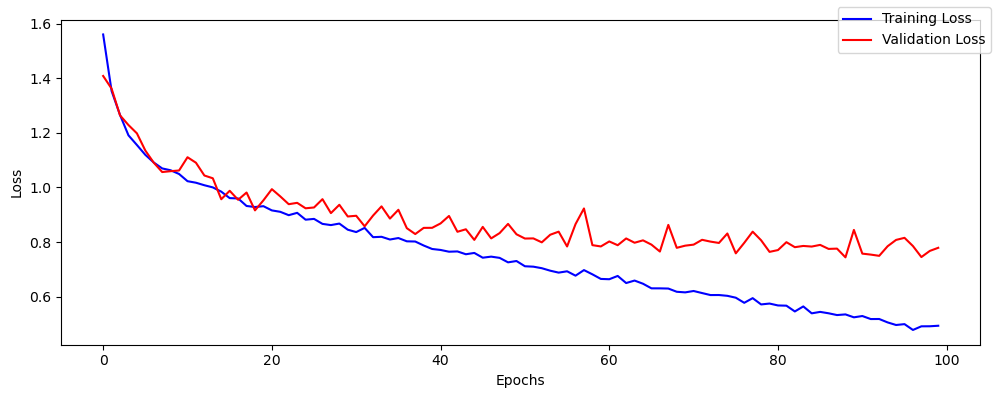

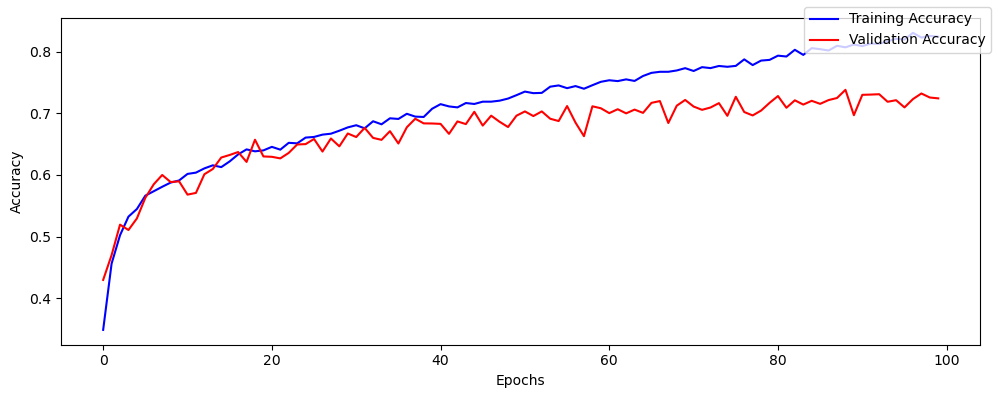

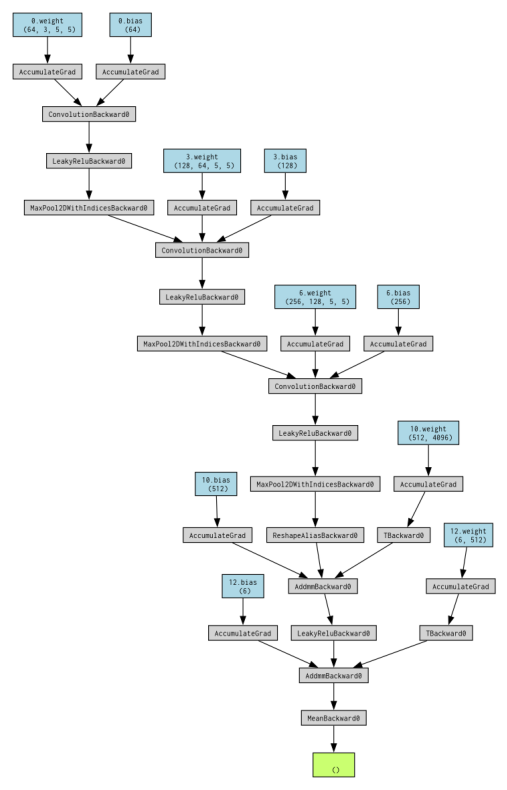

Model Architecture:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           4,864
         LeakyReLU-2           [-1, 64, 32, 32]               0
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4          [-1, 128, 16, 16]         204,928
         LeakyReLU-5          [-1, 128, 16, 16]               0
         MaxPool2d-6            [-1, 128, 8, 8]               0
            Conv2d-7            [-1, 256, 8, 8]         819,456
         LeakyReLU-8            [-1, 256, 8, 8]               0
         MaxPool2d-9            [-1, 256, 4, 4]               0
          Flatten-10                 [-1, 4096]               0
           Linear-11                  [-1, 512]       2,097,664
        LeakyReLU-12                  [-1, 512]               0
           Linear-13                    [-1, 6]           3,078
Total params: 3,129

In [47]:
m3 = nn.Sequential(
    
    # 1st conv block
    nn.Conv2d(3, 64, kernel_size=5, padding=2),  
    nn.LeakyReLU(0.1),
    nn.MaxPool2d(2, 2),
            
    # 2nd conv block
    nn.Conv2d(64, 128, kernel_size=5, padding=2),  
    nn.LeakyReLU(0.1),
    nn.MaxPool2d(2, 2),
    
    # 3rd conv block
    nn.Conv2d(128, 256, kernel_size=5, padding=2),  
    nn.LeakyReLU(0.1),
    nn.MaxPool2d(2, 2),
        
    # flatten layer
    nn.Flatten(),

    # fc
    nn.Linear(256 * 4 * 4, 512),
    nn.LeakyReLU(),

    nn.Linear(512, 6)  
)

loss = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    m3.parameters(),
    lr=0.00003,
    weight_decay=0.015,
)

print("--------------")


model_builder = ModelBuilder(m3, loss, optimizer, print_loss_freq=1)
model_builder.set_loaders(train_loader, val_loader)


model_builder.train(n_epochs=100)
model_builder.save_checkpoint("checkpoint2")

# plot training results
model_builder.plot_losses()
model_builder.plot_accuracies()
plt.show()


# render and plot the model archietichure using make_dot() and summary
sample_input = torch.randn(2, 3, 32, 32).to(device)
output = m3(sample_input)

make_dot(output.mean(), params=dict(m3.named_parameters())).render("images/cifar10_model_m3", format="png")
img = Image.open("images/cifar10_model_m3.png")
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")  
plt.show()


print("Model Architecture:")
print(summary(m3, input_size=(3, 32, 32)))  

### 5.2.13 M2 - Okay (72% accuracy + class balanced + oncecyleLR schudler)

Epoch 1/200
Epoch 1, Training loss: 1.7366, accuracy: 0.3628, Validation loss: 1.4767, accuracy: 0.4626
Epoch 2/200
Epoch 1, Training loss: 1.3798, accuracy: 0.4971, Validation loss: 1.3028, accuracy: 0.5307
Epoch 3/200
Epoch 1, Training loss: 1.2590, accuracy: 0.5386, Validation loss: 1.2297, accuracy: 0.5510
Epoch 4/200
Epoch 1, Training loss: 1.1969, accuracy: 0.5590, Validation loss: 1.1727, accuracy: 0.5645
Epoch 5/200
Epoch 1, Training loss: 1.1379, accuracy: 0.5824, Validation loss: 1.1361, accuracy: 0.5799
Epoch 6/200
Epoch 1, Training loss: 1.0937, accuracy: 0.5936, Validation loss: 1.1036, accuracy: 0.5864
Epoch 7/200
Epoch 1, Training loss: 1.0708, accuracy: 0.6070, Validation loss: 1.0842, accuracy: 0.5878
Epoch 8/200
Epoch 1, Training loss: 1.0345, accuracy: 0.6182, Validation loss: 1.0661, accuracy: 0.5943
Epoch 9/200
Epoch 1, Training loss: 1.0126, accuracy: 0.6223, Validation loss: 1.0374, accuracy: 0.6082
Epoch 10/200
Epoch 1, Training loss: 0.9868, accuracy: 0.6380, V

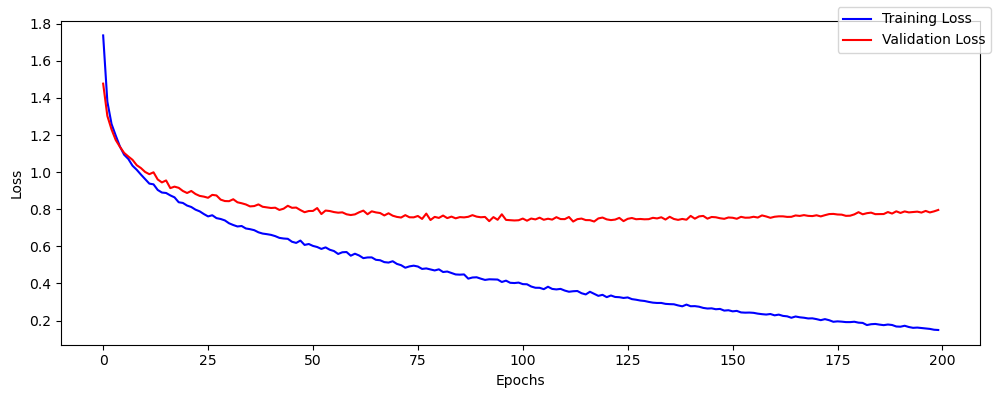

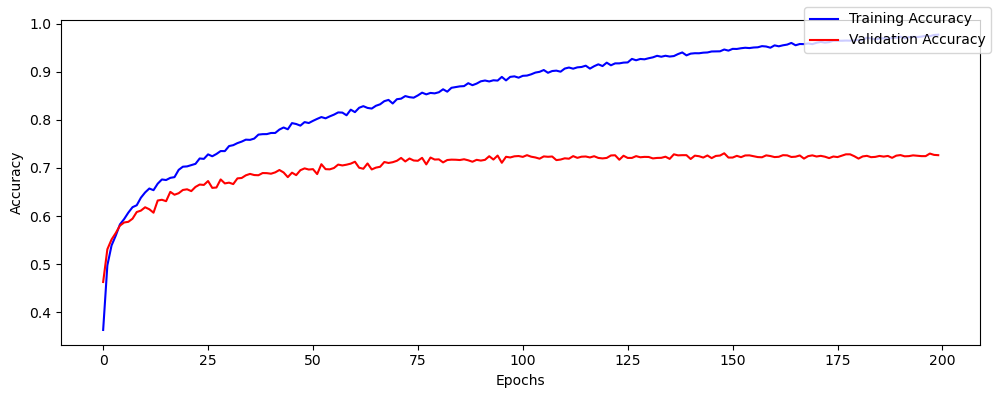

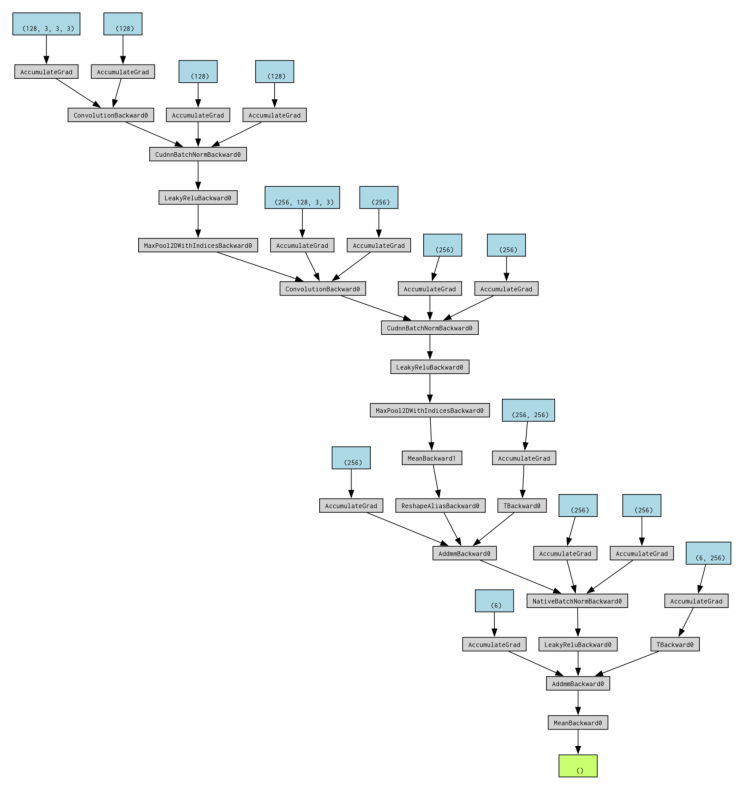

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 64, 32, 32]           1,792
├─BatchNorm2d: 1-2                       [1, 64, 32, 32]           128
├─ReLU: 1-3                              [1, 64, 32, 32]           --
├─MaxPool2d: 1-4                         [1, 64, 16, 16]           --
├─Conv2d: 1-5                            [1, 128, 16, 16]          73,856
├─BatchNorm2d: 1-6                       [1, 128, 16, 16]          256
├─ReLU: 1-7                              [1, 128, 16, 16]          --
├─MaxPool2d: 1-8                         [1, 128, 8, 8]            --
├─Flatten: 1-9                           [1, 8192]                 --
├─Linear: 1-10                           [1, 128]                  1,048,704
├─ReLU: 1-11                             [1, 128]                  --
├─ReLU: 1-12                             [1, 128]                  --

In [103]:
m2o_2 =  nn.Sequential(

    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(), 
    nn.MaxPool2d(2, 2),
    
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(12648), 
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    nn.Flatten(),
    
    nn.Linear(64 * 8 * 8, 64),
    nn.ReLU(),
    nn.ReLU(), 
    nn.Linear(64, 6)
)


optimizer = optim.AdamW(
    m2o_2.parameters(),
    lr=0.0000003, 
    weight_decay=0.1 
)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.0001,
    epochs=200,
    steps_per_epoch=len(train_loader),
    pct_start=0.3
)

model_buildero = ModelBuilder(m2o_2, loss, optimizer, print_loss_freq=1)
model_buildero.set_loaders(train_loader, val_loader)

for epoch in range(200):
    print(f"Epoch {epoch + 1}/{200}")
    model_buildero.train(n_epochs=1)
    scheduler.step() 

# plot results
model_buildero.save_checkpoint("m2o_2.pth")
model_buildero.plot_losses()
model_buildero.plot_accuracies()
plt.show()

#sample input/output for summary()
sample_input = torch.randn(2, 3, 32, 32).to(device) 
output = m2o_2(sample_input)


# render and plot the model archietichure using make_dot() and summary 
make_dot(output.mean(), params=dict(m2o_2.named_parameters())).render("images/m2o_2", format="png")
img = Image.open("images/m2o_2.png")
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")
plt.show()

print(summary(m2o_2, input_size=(1, 3, 32, 32)))


### 5.2.14 M2 - Okay (72% accuracy + class balanced + onecycleLR scheudler)

Epoch 1/200
Epoch 1, Training loss: 1.7779, accuracy: 0.3534, Validation loss: 1.5340, accuracy: 0.4407
Epoch 2/200
Epoch 1, Training loss: 1.4192, accuracy: 0.4870, Validation loss: 1.3523, accuracy: 0.5075
Epoch 3/200
Epoch 1, Training loss: 1.2971, accuracy: 0.5275, Validation loss: 1.2522, accuracy: 0.5421
Epoch 4/200
Epoch 1, Training loss: 1.2279, accuracy: 0.5458, Validation loss: 1.2039, accuracy: 0.5502
Epoch 5/200
Epoch 1, Training loss: 1.1770, accuracy: 0.5674, Validation loss: 1.1746, accuracy: 0.5548
Epoch 6/200
Epoch 1, Training loss: 1.1267, accuracy: 0.5828, Validation loss: 1.1246, accuracy: 0.5775
Epoch 7/200
Epoch 1, Training loss: 1.0975, accuracy: 0.5935, Validation loss: 1.0971, accuracy: 0.5860
Epoch 8/200
Epoch 1, Training loss: 1.0840, accuracy: 0.5998, Validation loss: 1.0691, accuracy: 0.6005
Epoch 9/200
Epoch 1, Training loss: 1.0480, accuracy: 0.6142, Validation loss: 1.0739, accuracy: 0.5906
Epoch 10/200
Epoch 1, Training loss: 1.0230, accuracy: 0.6240, V

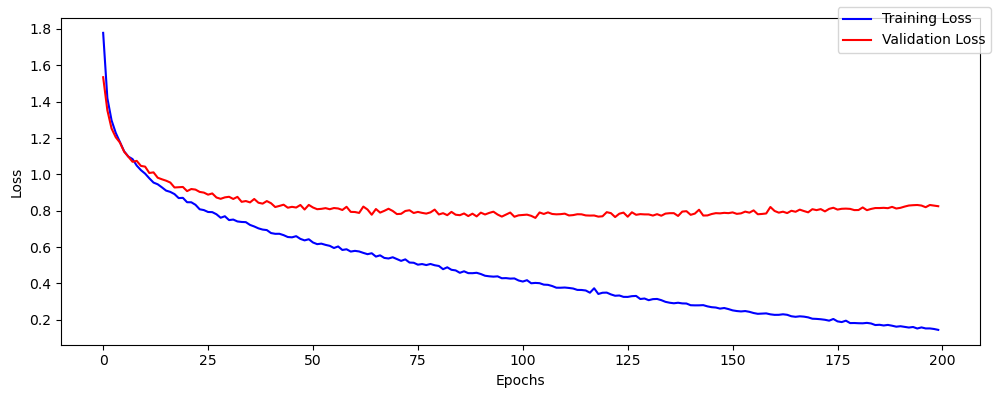

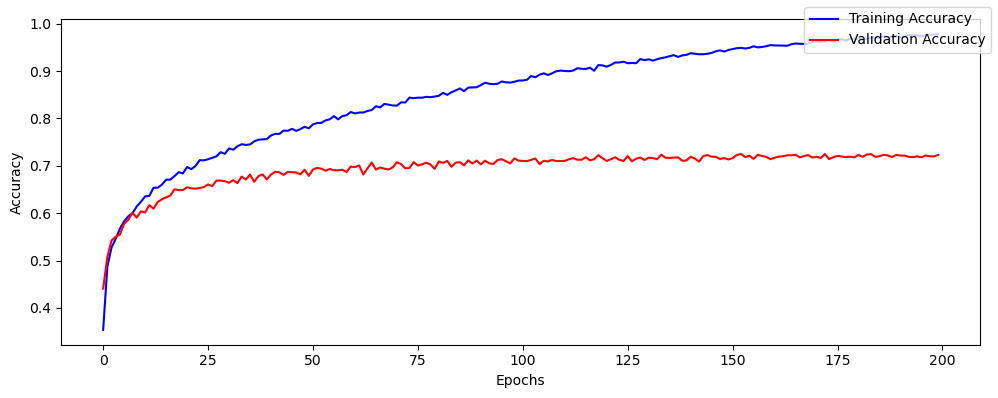

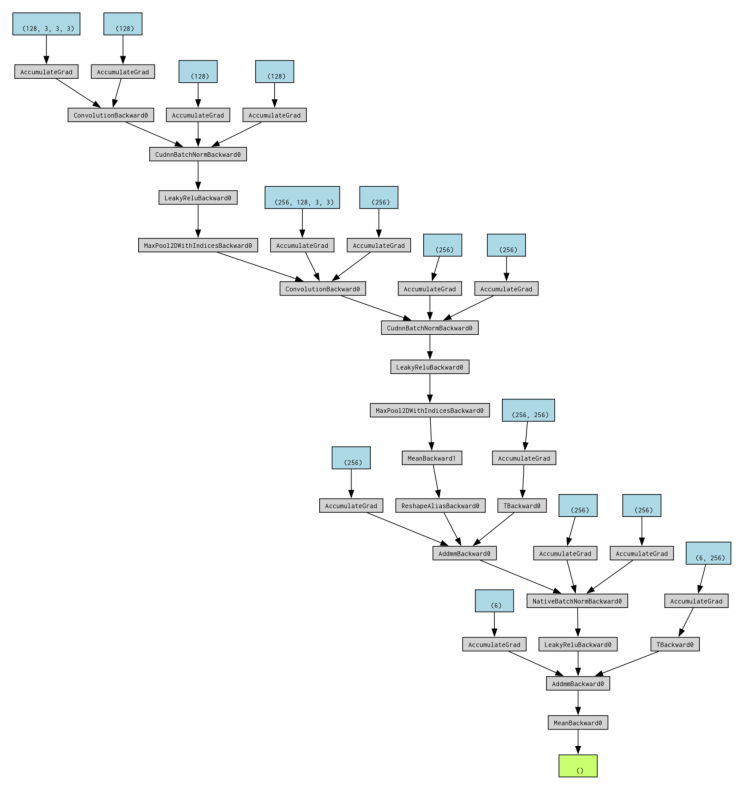

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 64, 32, 32]           4,864
├─BatchNorm2d: 1-2                       [1, 64, 32, 32]           128
├─ReLU: 1-3                              [1, 64, 32, 32]           --
├─MaxPool2d: 1-4                         [1, 64, 16, 16]           --
├─Conv2d: 1-5                            [1, 100, 16, 16]          160,100
├─BatchNorm2d: 1-6                       [1, 100, 16, 16]          200
├─ReLU: 1-7                              [1, 100, 16, 16]          --
├─MaxPool2d: 1-8                         [1, 100, 8, 8]            --
├─Flatten: 1-9                           [1, 6400]                 --
├─Linear: 1-10                           [1, 100]                  640,100
├─ReLU: 1-11                             [1, 100]                  --
├─Linear: 1-12                           [1, 10]                   1,0

In [124]:

m2o_22 = nn.Sequential(
    
    nn.Conv2d(3, 64, kernel_size=5, padding=2),  
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    nn.Conv2d(64, 100, kernel_size=5, padding=2),
    nn.BatchNorm2d(100),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    nn.Flatten(),
    nn.Linear(100 * 8 * 8, 100),
    nn.ReLU(),
    nn.Linear(100, 10)
)


optimizer = optim.AdamW(
    m2o_22.parameters(),
    lr=0.0000003,
    weight_decay=0.1
)


scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.0001,
    epochs=200,
    steps_per_epoch=len(train_loader),
    pct_start=0.3
)

model_buildero = ModelBuilder(m2o_22, loss, optimizer, print_loss_freq=1)
model_buildero.set_loaders(train_loader, val_loader)

for epoch in range(200):
    print(f"Epoch {epoch + 1}/{200}")
    model_buildero.train(n_epochs=1)
    scheduler.step() 

# train the model
model_buildero.save_checkpoint("m2o_22.pth")
model_buildero.plot_losses()
model_buildero.plot_accuracies()
plt.show()

# render and plot the model architecture
#sample input/output for summary()
sample_input = torch.randn(2, 3, 32, 32).to(device) 
output = m2o_22(sample_input)



make_dot(output.mean(), params=dict(m2o_22.named_parameters())).render("images/m2o_22", format="png")
img = Image.open("images/m2o_22.png")
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")
plt.show()

print(summary(m2o_22, input_size=(1, 3, 32, 32)))


### 5.2.15 M3 - Okay (72% accuracy + NO SCHUDELER)

Epoch 1, Training loss: 1.5245, accuracy: 0.3743, Validation loss: 1.3713, accuracy: 0.4577
Epoch 2, Training loss: 1.3471, accuracy: 0.4636, Validation loss: 1.3107, accuracy: 0.4838
Epoch 3, Training loss: 1.2666, accuracy: 0.5078, Validation loss: 1.2151, accuracy: 0.5502
Epoch 4, Training loss: 1.1990, accuracy: 0.5339, Validation loss: 1.1804, accuracy: 0.5459
Epoch 5, Training loss: 1.1440, accuracy: 0.5546, Validation loss: 1.1293, accuracy: 0.5720
Epoch 6, Training loss: 1.1030, accuracy: 0.5669, Validation loss: 1.0987, accuracy: 0.5799
Epoch 7, Training loss: 1.0810, accuracy: 0.5793, Validation loss: 1.0667, accuracy: 0.5882
Epoch 8, Training loss: 1.0699, accuracy: 0.5813, Validation loss: 1.0746, accuracy: 0.5872
Epoch 9, Training loss: 1.0497, accuracy: 0.5950, Validation loss: 1.0341, accuracy: 0.6092
Epoch 10, Training loss: 1.0325, accuracy: 0.6006, Validation loss: 1.0091, accuracy: 0.6161
Epoch 11, Training loss: 1.0045, accuracy: 0.6071, Validation loss: 1.0313, acc

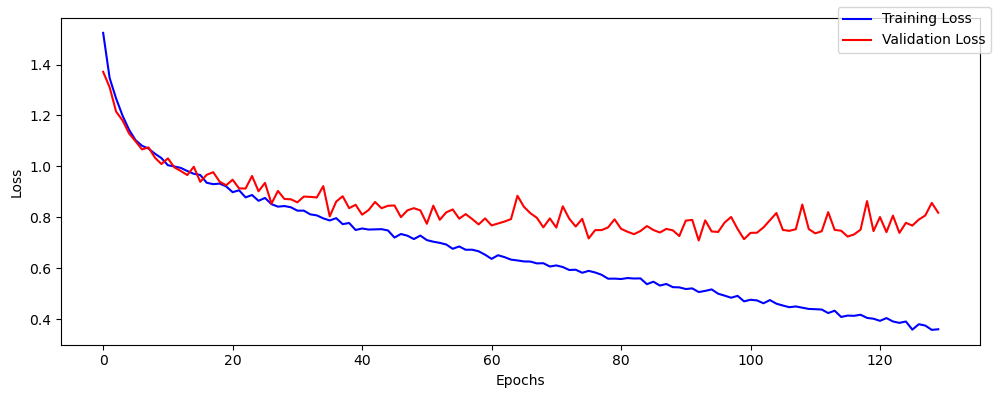

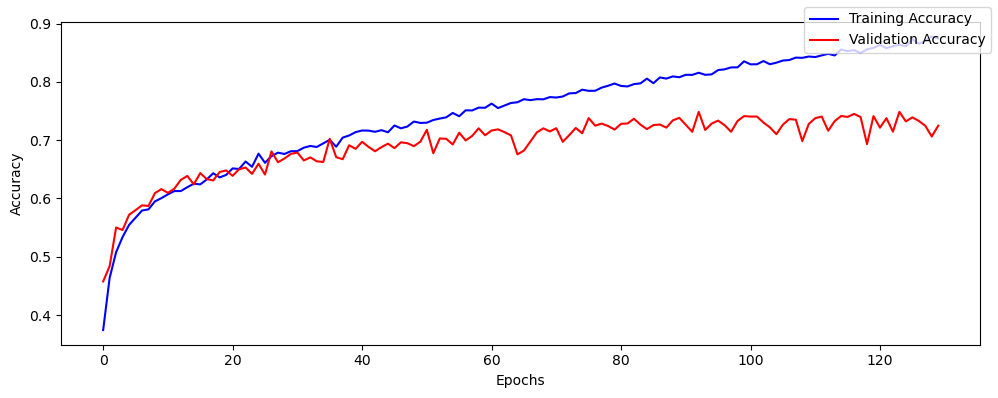

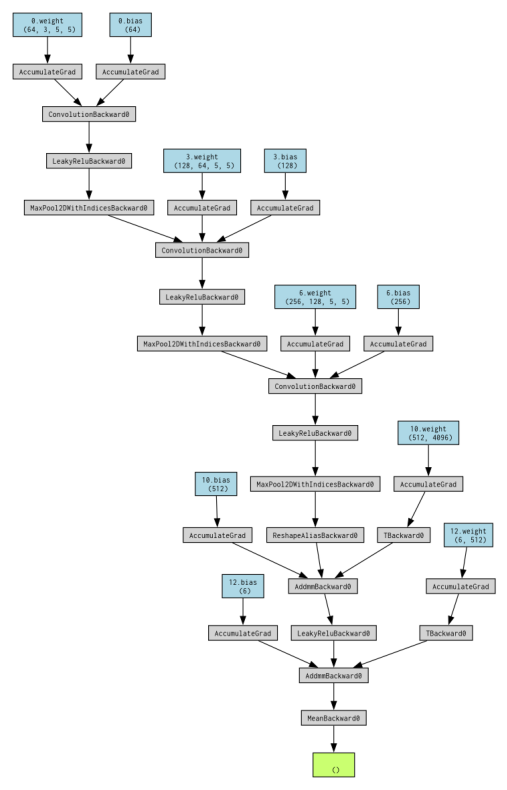

Model Architecture:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           4,864
         LeakyReLU-2           [-1, 64, 32, 32]               0
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4          [-1, 128, 16, 16]         204,928
         LeakyReLU-5          [-1, 128, 16, 16]               0
         MaxPool2d-6            [-1, 128, 8, 8]               0
            Conv2d-7            [-1, 256, 8, 8]         819,456
         LeakyReLU-8            [-1, 256, 8, 8]               0
         MaxPool2d-9            [-1, 256, 4, 4]               0
          Flatten-10                 [-1, 4096]               0
           Linear-11                  [-1, 512]       2,097,664
        LeakyReLU-12                  [-1, 512]               0
           Linear-13                    [-1, 6]           3,078
Total params: 3,129

In [53]:
m3 = nn.Sequential(
    
    nn.Conv2d(3, 64, kernel_size=5, padding=2),  
    nn.LeakyReLU(0.2),
    nn.MaxPool2d(2, 2),
            
    nn.Conv2d(64, 128, kernel_size=5, padding=2),  
    nn.LeakyReLU(0.2),
    nn.MaxPool2d(2, 2),
    
    
    nn.Conv2d(128, 256, kernel_size=5, padding=2),  
    nn.LeakyReLU(0.2),
    nn.MaxPool2d(2, 2),
        
    nn.Flatten(),
    
    nn.Linear(256 * 4 * 4, 512),
    nn.LeakyReLU(0.2),

    nn.Linear(512, 6)  
)



loss = nn.CrossEntropyLoss()

optimizer = optim.AdamW(
    m3.parameters(),
    lr=0.00003,
    weight_decay=0.015,
)


model_builder = ModelBuilder(m3, loss, optimizer, print_loss_freq=1)
model_builder.set_loaders(train_loader, val_loader)



# train the model
model_builder.train(n_epochs=130)
model_builder.save_checkpoint("checkpoint2")

# plot results
model_builder.plot_losses()
model_builder.plot_accuracies()
plt.show()


#sample input/output for summary()
sample_input = torch.randn(2, 3, 32, 32).to(device)
output = m3(sample_input)

# render and plot the model archietichure using make_dot() and summary 
make_dot(output.mean(), params=dict(m3.named_parameters())).render("images/cifar10_model_m3", format="png")
img = Image.open("images/cifar10_model_m3.png")
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")  
plt.show()




print("Model Architecture:")
print(summary(m3, input_size=(3, 32, 32)))  
print("--------------")


### 5.1.16 M3 - Good (75% accuracy + optimised + cosine annealer warm scheduler)

Epoch 1/300
Epoch 1, Training loss: 1.5953, accuracy: 0.3465, Validation loss: 1.3132, accuracy: 0.4523
Epoch 2/300
Epoch 1, Training loss: 1.4021, accuracy: 0.4243, Validation loss: 1.1888, accuracy: 0.5311
Epoch 3/300
Epoch 1, Training loss: 1.3157, accuracy: 0.4700, Validation loss: 1.1349, accuracy: 0.5376
Epoch 4/300
Epoch 1, Training loss: 1.2856, accuracy: 0.4810, Validation loss: 1.1119, accuracy: 0.5595
Epoch 5/300
Epoch 1, Training loss: 1.2392, accuracy: 0.5066, Validation loss: 1.0781, accuracy: 0.5589
Epoch 6/300
Epoch 1, Training loss: 1.2152, accuracy: 0.5092, Validation loss: 1.0308, accuracy: 0.5934
Epoch 7/300
Epoch 1, Training loss: 1.1782, accuracy: 0.5271, Validation loss: 1.0192, accuracy: 0.5837
Epoch 8/300
Epoch 1, Training loss: 1.1740, accuracy: 0.5352, Validation loss: 1.0377, accuracy: 0.5789
Epoch 9/300
Epoch 1, Training loss: 1.1423, accuracy: 0.5413, Validation loss: 0.9946, accuracy: 0.6017
Epoch 10/300
Epoch 1, Training loss: 1.1446, accuracy: 0.5447, V

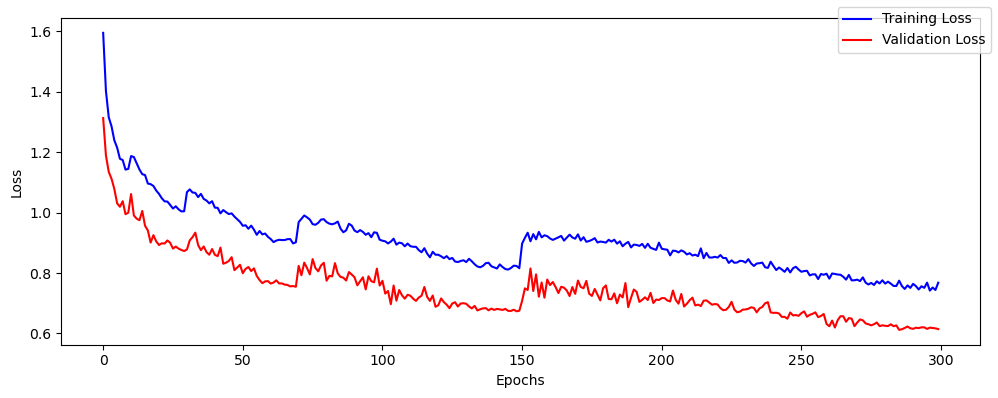

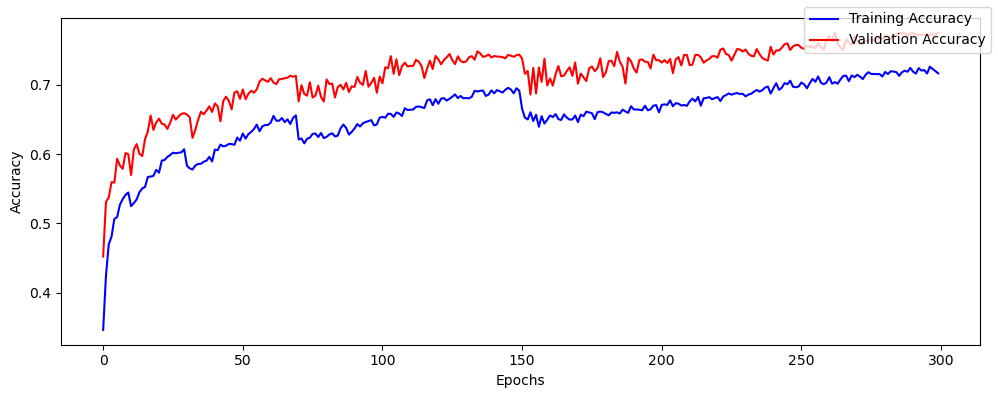

NameError: name 'output' is not defined

In [30]:
m3_o = nn.Sequential(

    nn.Conv2d(3, 24, kernel_size=3, padding=1),
    nn.BatchNorm2d(24),
    nn.ReLU(),
    nn.Dropout2d(0.2),  
    nn.MaxPool2d(2, 2),
    
    nn.Conv2d(24, 48, kernel_size=3, padding=1),
    nn.BatchNorm2d(48),
    nn.ReLU(),
    nn.Dropout2d(0.3), 
    nn.MaxPool2d(2, 2),
    
    nn.Conv2d(48, 96, kernel_size=3, padding=1),
    nn.BatchNorm2d(96),
    nn.ReLU(),
    nn.Dropout2d(0.4), 
    nn.MaxPool2d(2, 2),
    
    nn.Flatten(),
    nn.Linear(96 * 4 * 4, 100),
    nn.ReLU(),
    nn.Dropout(0.5), 
    nn.Linear(100, 10)
)

loss = nn.CrossEntropyLoss()

optimizer = optim.AdamW(
    m3_o.parameters(),
    lr=0.001,  
    weight_decay=0.1 
)


scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=10,  
    T_mult=2,
    eta_min=0.000001
)

# train the model
model_buildero = ModelBuilder(m3_o, loss, optimizer, print_loss_freq=1)
model_buildero.set_loaders(train_loader, val_loader)


for epoch in range(300):
    print(f"Epoch {epoch + 1}/{300}")
    model_buildero.train(n_epochs=1)
    scheduler.step()  


#model_buildero.save_checkpoint("m3_o.pth")
model_buildero.plot_losses()
model_buildero.plot_accuracies()
plt.show()


sample_input = torch.randn(2, 3, 32, 32).to(device) 
output = m3_o(sample_input)

make_dot(output.mean(), params=dict(m3_o.named_parameters())).render("images/m3_o", format="png")
img = Image.open("images/m3_o.png")
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")
plt.show()

print(summary(m3_o, input_size=(1, 3, 32, 32)))


## 5.3 Attempted transform hyper-parameters

In [ ]:
#
# Those hyper parameters were tried but not used eventually due to signficintly slowing down the network with current availble compute units (Nvidia T4 - 4 Cores)
#

transform = transforms.Compose([
    # geometric transformations
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    # colour transformations
    transforms.ColorJitter(
        brightness=0.1,
        contrast=0.1,
        saturation=0.1,
        hue=0.1
    ), 
    # normalisation (using CIFAR-10 specific values)
    v2.Normalize(
        mean=[0.4914, 0.4822, 0.4465],  # CIFAR 10 specific means
        std=[0.2470, 0.2435, 0.2616]     # CIFAR 10 specific stds
    ),])



# 6. Refrences


- [How to Develop a CNN from Scratch for CIFAR-10 Photo Classification](https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/)
- [Writing ResNet from Scratch in PyTorch](https://www.digitalocean.com/community/tutorials/writing-resnet-from-scratch-in-pytorch)
- [CIFAR-10 Image Classification in TensorFlow](https://www.geeksforgeeks.org/cifar-10-image-classification-in-tensorflow/)
- [PyTorchViz GitHub Repository](https://github.com/szagoruyko/pytorchviz)
- [CIFAR-10 Challenge CNN Checkpoints on GitHub](https://github.com/rcalix1/DeepLearningAlgorithms/blob/main/SecondEdition/chapter6_CNNs/CheckPoints_DH_CIFAR10_challenge_CNN.ipynb)
- [CIFAR-10 Prediction Project on GitHub](https://github.com/mumuljuve/CIFAR-10-pic-pred/tree/main)
- [Convolutional Neural Network CIFAR Dataset on GitHub](https://github.com/FranklinBarto/convolution-neural-network-cifar-dataset/tree/main)
- [Image Classification using CNN for Beginners on Kaggle](https://www.kaggle.com/code/anandhuh/image-classification-using-cnn-for-beginners)
- [Basic CNN Model for CIFAR-10 on Kaggle](https://www.kaggle.com/code/utkuefeakdoan/cifar-10-basic-cnn-model/notebook)
- [CIFAR-10 Explanation with PyTorch on Kaggle](https://www.kaggle.com/code/fanbyprinciple/cifar10-explanation-with-pytorch)
- [CIFAR-10 Image Classification with CNN on Kaggle](https://www.kaggle.com/code/farzadnekouei/cifar-10-image-classification-with-cnn)
- [Understanding Convolutional NNs Simplified on Kaggle](https://www.kaggle.com/code/matinmahmoudi/understanding-convolutional-nns-simplified)
- [CIFAR-10 Image Classification with CNN in PyTorch on Kaggle](https://www.kaggle.com/code/stefancomanita/cifar-10-image-classification-with-cnn-in-pytorch)
- [VGG Transfer Learning with CIFAR-10 on Kaggle](https://www.kaggle.com/code/hossamahmedsalah/vgg-transfer-learning-with-cifar-10)
- [Claude 3.5 Sonnet LLM - General Debugging and Hyperparameters Exploration](https://claude.ai/new)

